In [1]:
## import libraries
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from math import sqrt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from bs4 import BeautifulSoup
import requests
import lxml
import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from pybaseball import batting_stats_bref
from pybaseball import statcast_batter_expected_stats
from pybaseball import statcast_pitcher_expected_stats
from pybaseball import pitching_stats
from pybaseball import cache
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from scipy.optimize import minimize
import pulp
from pulp import *
import datetime
import random
import pickle
import cProfile
import time
# import logistic regression and accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
import statsmodels.api as sm
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
# cache.enable()

optional = ''

In [2]:
# functions



# get today's date formatted as yyyy-mm-dd
def get_todays_date():
  # get the current date
  today = datetime.date.today()
  # format the date as yyyy-mm-dd
  date = today.strftime('%Y-%m-%d')
  # return the date
  return date

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


def get_starters(date):
  # url for the website
  url = 'https://www.fangraphs.com/livescoreboard.aspx?date=' + date
  # get the website with bs
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tables = soup.find_all('table', class_='lineup')

  starting = []
  for table in tables:
    row = table.find_all('tr')
    for r in row:
      col = r.find_all('td')
      for c in col:
        a = c.find_all('a')
        if len(a) > 0:
          for i in a:
            name = i.text
            # change names which are not in the correct format
            if name == 'Cedric Mullins II':
              starting.append('Cedric Mullins')
            elif name == 'Mike Siani':
              starting.append('Michael Siani')
            elif name == 'Enrique Hernandez':
              starting.append('Kike Hernandez')
            elif name == 'J.J. Bleday':
              starting.append('JJ Bleday')
            elif name == 'D.J. Stewart':
              starting.append('DJ Stewart')
            else:
              starting.append(name)


  starting_df = pd.DataFrame(starting)
  return starting_df

            
def calculate_batting_fantasy_points(row):
  points = 0
  if row['events']=='single' or row['events'] == 'walk':
    points = points + 3
  elif row['events']=='double':
    points = points + 5
  elif row['events']=='triple':
    points = points + 8
  elif row['events']=='home_run':
    points = points + 10

  points = points + 4 * (row['post_bat_score']- row['bat_score'])

  return points

def calculate_pitching_fantasy_points(row):
  points = 0
  if row['events']=='strikeout':
    points = points + 2.75
  elif row['events']=='double_play' or row['events']=='grounded_into_double_play':
    points = points + 1.5
  elif row['events']=='strikeout_double_play' or row['events']=='strikeout_double_play':
    points = points + 3.5
  elif row['events']=='triple_play':
    points = points + 2.25
  elif row['events']=='single' or row['events'] == 'walk' or row['events'] == 'hit_by_pitch' or row['events'] == 'double' or row['events'] == 'triple' or row['events'] == 'home_run':
    points = points - .6
  else:
    points = points + .75

  points = points - 2 * (row['post_bat_score']- row['bat_score'])
  return points

def total_ball_movement(row):
  # return calculation if is a number else return 0
  x = row['pfx_x']
  z = row['pfx_z']
  if np.isnan(x):
    x = 0
  if np.isnan(z):
    z = 0
  total_movement = sqrt(x**2 + z**2)
  return total_movement

def batter_adjusted_plate_x(row):
  if row['stand'] == 'R':
    return row['plate_x']
  else:
    return -row['plate_x']

# sum batter stats per team for each game
def team_batters_games(df):
  df['team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])
  team_batters = df.groupby(['game_pk', 'team'])['batter_fp'].sum().reset_index()
  return team_batters
    
# determine team based on inning_topbot
def team(row):
  if row['inning_topbot'] == 'Top':
    return row['away_team']
  else:
    return row['home_team']
  
# sum pitcher stats per team for each game
def team_pitchers_games(df):
  df['team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])
  team_pitchers = df.groupby(['game_pk', 'team', 'player_name'])['pitcher_fp'].sum().reset_index()
  # get batters faced per pitcher
  batters_faced = df.groupby(['game_pk', 'team', 'player_name'])['batter'].count().reset_index()
  # merge the two dataframes
  team_pitchers = pd.merge(team_pitchers, batters_faced, on=['game_pk', 'team', 'player_name'])
  # for each game, select the pitcher with the most batters faced
  team_pitchers = team_pitchers.sort_values(by=['game_pk', 'batter'], ascending=False).drop_duplicates(subset=['game_pk', 'team'])
  return team_pitchers

# batter fantasy points by game
def batter_fp(df):
  df['batter_fp'] = df.apply(calculate_batting_fantasy_points, axis=1)

  # return points
  batter_game_fp = df.groupby(['game_pk', 'batter'])['batter_fp'].sum().reset_index()
  return batter_game_fp

# get number of plate appearances for each batter
def get_plate_appearances(df):
  plate_appearances = df.groupby(['batter'])['batter'].count().reset_index(name='pa')
  return plate_appearances

# filter the df to only the last x days
def last_x_days(df, x):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=x)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  # filter the df to only the last x days
  df = df[df['game_date'] > x_days_ago]
  return df

# fix player names to remove latin characters
def fix_player_names(df, column_name):
  df.loc[:, column_name] = df.loc[:, column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  # remove suffixes
  df = remove_suffixes(df, column_name)
  # change to all lower_case
  df[column_name] = df[column_name].str.lower()
  return df

# fix players names to move first name to the front and remove commas
def fix_player_names2(df, column_name):
  df[column_name] = df[column_name].str.split(',').str[1] + ' ' + df[column_name].str.split(',').str[0]
  df[column_name] = df[column_name].str.lower()

  return df

# get the frequency that a player has a stat between two values
def player_stat_frequency(df, player_name, column_name, lower, upper, is_batter=True):
  # filter the df to the selected player depending on if they are a batter or pitcher
  if is_batter:
    df = df[df['batter'] == player_name]
  else:
    df = df[df['player_name'] == player_name]

  # fix for when tyring to divide by zero
  if df.shape[0] == 0:
    return 0
  # find how often column name is between lower and upper
  freq = df[(df[column_name] >= lower) & (df[column_name] <= upper)].shape[0] / df.shape[0]
  return freq

# reformatting for merge
def convert_to_player_name(row):
  name = row['Name']
  # handle case for names with two spaces
  if len(name.split(' ')) > 2:
    return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
  else:
    return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
# get data before date x
def data_before_date(df, y, m, d):
  x = y + "-" + m + "-" + d
  # filter the df to only the last x days
  df = df[df['game_date'] < x]
  # replace WSH with WAS and AZ with ARI
  df['home_team'] = df['home_team'].replace('WSH', 'WAS')
  df['away_team'] = df['away_team'].replace('WSH', 'WAS')
  df['home_team'] = df['home_team'].replace('AZ', 'ARI')
  df['away_team'] = df['away_team'].replace('AZ', 'ARI')
  return df


def get_batter_game_fp(pregame_info):
    # batter game fp
    batter_game_fp = batter_fp(pregame_info) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(pregame_info) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    # batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    # batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    return batter_game_fp



def get_pitcher_exp(pregame_info):
    # get all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_speed', 100, 150, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)
    return pitcher_exp


def get_batter_exp(pregame_info):
    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, 20)

    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    return batter_exp


def get_pregame_batting_order(pregame_info):
    # get only the last game for each team
    #pregame_info = pregame_info.groupby(['game_pk', 'team']).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
    # get only the first at bat for each batter per game
    pregame_batting_order = pregame_info.sort_values(by=['game_pk', 'at_bat_number'])
    pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    pregame_batting_order["batting_order"] = pregame_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    pregame_batting_order = pregame_batting_order[pregame_batting_order['batting_order'] <= 9]
    return pregame_batting_order

def trim(col):
    return col.str.strip()

def remove_suffixes(df, col):
    # df[col] = df[col].str.replace(' Jr.', '')
    # df[col] = df[col].str.replace(' Sr.', '')
    # df[col] = df[col].str.replace(' II', '')
    # df[col] = df[col].str.replace(' III', '')
    # df[col] = df[col].str.replace(' IV', '')

    #do the above without chained indexing
    df.loc[:, col] = df.loc[:, col].str.replace(' Jr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' Sr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' III', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' II', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' IV', '')
    return df

def adjust_player_name(row):
  first_name = row['name_first']
  last_name = row['name_last']
  # fix names which are not in the correct format
  if last_name == 'vogelbach':
    return 'dan vogelbach'
  elif last_name == 'siani':
    return 'michael siani'
  elif first_name == 'j. d.':
    return 'j.d. martinez'
  elif row['batter_name'] == 'Michael A. Taylor':
    return 'michael taylor'

  return row['batter_name']

def filter_from_last_game_pks(df, last_game_pks):
  # remove rows in which team and game_pks pairs are not in last_game_pks
  for index, row in df.iterrows():
    if row['game_pk'] not in last_game_pks['game_pk']:
      df = df.drop(index)
    elif row['team'] not in last_game_pks['team']:
      df = df.drop(index)
    elif not(last_game_pks['team'].index_of(row['team']) == last_game_pks['game_pk'].index_of(row['game_pk'])):
      df = df.drop(index)
  return df


def get_past_date(days=30):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=days)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  return x_days_ago

def get_pitcher_averages_by_handedness(df):
  l_data = df[df['stand'] == 'L']
  r_data = df[df['stand'] == 'R']
  l_data = l_data.groupby(['Name', 'player_name']).mean(numeric_only=True).reset_index()
  r_data = r_data.groupby(['Name', 'player_name']).mean(numeric_only=True).reset_index()
  columns = l_data.columns
  columns = columns.drop(['Name', 'player_name'])
  l_data = add_suffix_to_columns(l_data, columns, '_vs_l_batter')
  r_data = add_suffix_to_columns(r_data, columns, '_vs_r_batter')
  pitcher_data = pd.merge(df, l_data, on=['Name', 'player_name'], how='left')
  pitcher_data = pd.merge(pitcher_data, r_data, on=['Name', 'player_name'], how='left')
  return pitcher_data

def get_batter_averages_by_handedness(df):
  l_data = df[df['p_throws'] == 'L']
  r_data = df[df['p_throws'] == 'R']
  l_data = l_data.groupby('batter').mean(numeric_only=True).reset_index()
  r_data = r_data.groupby('batter').mean(numeric_only=True).reset_index()
  columns = l_data.columns
  columns = columns.drop('batter')
  l_data = add_suffix_to_columns(l_data, columns, '_vs_l_pitcher')
  r_data = add_suffix_to_columns(r_data, columns, '_vs_r_pitcher')
  batter_data = pd.merge(df, l_data, on='batter', how='left')
  batter_data = pd.merge(batter_data, r_data, on='batter', how='left')
  return batter_data


def add_suffix_to_columns(df, columns, suffix):
  for col in columns:
    df = df.rename(columns={col: col + suffix})
  return df

def reduce_columns_by_handedness(df):
  # get handedness columns
  columns = df.columns
  # keep only columns containing '_vs_'
  columns = [col for col in columns if '_vs_' in col]

  for column in columns:
    # remove any that include _pitcher and _batter
    if ('_pitcher' in column) and ('_batter' in column):
      continue
    elif '_vs_l_pitcher' in column:
      new_column = column.replace('_vs_l_pitcher', '_by_pitcher_handedness')
      opposite_column = column.replace('_vs_l_pitcher', '_vs_r_pitcher')
      df[new_column] = np.where(df['p_throws'] == 'L', df[column], df[opposite_column])
    elif '_vs_l_batter' in column:
      new_column = column.replace('_vs_l_batter', '_by_batter_handedness')
      opposite_column = column.replace('_vs_l_batter', '_vs_r_batter')
      df[new_column] = np.where(df['stand'] == 'L', df[column], df[opposite_column])

  df = df.drop(columns, axis=1)
  return df

def select_best_features(df, target):
    # get only numeric columns
    df = df.select_dtypes(include=[np.number])
    bad_cols = ['avg_batter_fpts_last_10','team_batter_fp_pred_x', 'team_batter_fp_pred_y', 'pitcher_payoff', 'payoff', 'batter_drafted', 'batter_fpts', 'batter_fp', 'batter_fp_pred', 'team_batter_fp_pred', 'pitcher_fp', 'pitcher_drafted', 'pitcher_fpts', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'est_ba', 'batting_order_change', 'avg_batting_order_pitcher', 'est_ba_pitcher', 'batting_order_change_pitcher']
    for col in bad_cols:
      if col in df.columns:
        df = df.drop(col, axis=1)
    # function to select the best features for a model
    # # create a summary table
    # summary_table = pd.DataFrame(columns=['Feature', 'Coefficient', 'P-Value'])
    # # for each feature, calculate the p-value and coefficient
    # for i in range(df.shape[1]):
    #     feature = df.columns[i]
    #     X = df[feature]
    #     X = sm.add_constant(X).astype(float)
    #     model = sm.OLS(target, X).fit()
    #     summary_table = pd.concat([summary_table, pd.DataFrame({'Feature': [feature], 'Coefficient': [model.params[0]], 'P-Value': [model.pvalues[0]]})])
    # # select features with p-value < 0.05
    # threshold = 0.05
    # model_features = summary_table[summary_table['P-Value'] < threshold]['Feature']
    # while(len(model_features) == 0):
    #   threshold = threshold + 0.01
    #   model_features = summary_table[summary_table['P-Value'] < threshold]['Feature']
    # model_data = df[model_features]
    
    # # instead, just get the top 10 features
    # model_features = summary_table.sort_values(by='P-Value').head(10)['Feature']
    # model_data = df[model_features]

    # remove nas
    df = df.dropna()

    # standardize the data
    model_data = df
    model_data = (model_data - model_data.mean()) / model_data.std()

    # do a linear regression
    model = LinearRegression()
    model.fit(model_data, target)
    # get the coefficients
    coef = model.coef_
    
    threshold = 0.1
    # remove model_features with small coefficients
    model_features = model_data.columns[np.abs(coef) > threshold]
    while model_features.shape[0] == 0:
      threshold = threshold - 0.005
      model_features = model_data.columns[np.abs(coef) > threshold]
    model_data = model_data[model_features]

    return model_features, model_data


# define functions for analysis

def get_leaderboard_rank(leaderboard, lineup_fpts):
    # rather than iterate through leaderboard, start in the middle and go up or down based on lineup_fpts
    # if lineup_fpts is greater than the fpts of the middle row, go up; if less, go down
    
    while leaderboard.shape[0] > 0:
        mid = int(leaderboard.shape[0]/2)
        if lineup_fpts < leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[mid:]
        elif lineup_fpts > leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[:mid]
        else:
            return leaderboard['Rank'].iloc[mid]
        if leaderboard.shape[0] == 1:
            return leaderboard['Rank'].iloc[0]

    return leaderboard['Rank'].iloc[0]


def get_payoff(rank):
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]
    if rank <= 20:
        return payoffs[rank - 1]
    elif rank <= 100:
        return 150
    elif rank <= 300:
        return 50
    elif rank <= 3500:
        return 15
    else:
        return -15

In [3]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

starters = get_starters(todays_date)
# print to csv
starters.to_csv('C:\\Users\\jorda\\Downloads\\starters.csv')

In [4]:
# get base df

# Get all Statcast data from 2024
df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# Only include events
df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
df = fix_player_names(df, 'player_name')

# change AZ to ARI and WAS to WSH
df['home_team'] = df['home_team'].replace('AZ', 'ARI')
df['away_team'] = df['away_team'].replace('AZ', 'ARI')
df['home_team'] = df['home_team'].replace('WAS', 'WSH')
df['away_team'] = df['away_team'].replace('WAS', 'WSH')

# get more info
df['pitcher_fp'] = df.apply(lambda row: calculate_pitching_fantasy_points(row), axis=1)
df['batter_fp'] = df.apply(lambda row: calculate_batting_fantasy_points(row), axis=1)
df['total_ball_movement'] = df.apply(lambda row: total_ball_movement(row), axis=1)
df['batter_adjusted_plate_x'] = df.apply(lambda row: batter_adjusted_plate_x(row), axis=1)



This is a large query, it may take a moment to complete


100%|██████████| 123/123 [00:31<00:00,  3.91it/s]


In [5]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,pitcher_fp,batter_fp,total_ball_movement,batter_adjusted_plate_x
2944,FC,2024-07-27,89.0,-2.23,5.61,"jarvis, bryce",678225,686826,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,Ji Hwan Bae flies out to left fielder Lourdes ...,R,L,R,ARI,PIT,X,7,fly_ball,0,0,2024,0.04,0.27,0.42,1.65,<NA>,<NA>,663647,2,9,Top,78.0,92.27,<NA>,<NA>,672515,<NA>,<NA>,6.364035,-129.550599,-4.23667,-0.871754,26.82586,-28.493574,3.14,1.45,274,89.1,46,88.5,2185,5.9,747171,686826,672515,572233,606466,553993,672695,666971,664983,682998,54.56,0.003,0.003,0.0,1,0,0,3,78,1,Cutter,9,5,5,9,5,9,5,9,Standard,Standard,155,0.003,-0.228,72.70759,7.36567,0.75,0,0.272947,-0.42
3073,SI,2024-07-27,94.5,-1.93,5.67,"jarvis, bryce",663698,686826,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,5,Joey Bart flies out sharply to left fielder Lo...,R,R,R,ARI,PIT,X,7,fly_ball,2,2,2024,-1.12,0.78,-0.17,2.34,<NA>,<NA>,663647,1,9,Top,81.56,50.3,<NA>,<NA>,672515,<NA>,<NA>,7.049204,-137.515564,-4.788371,-15.658321,27.104698,-21.387607,3.48,1.6,382,106.4,40,94.7,1955,6.2,747171,686826,672515,572233,606466,553993,672695,666971,664983,682998,54.33,0.486,0.986,0.0,1,0,0,6,77,6,Sinker,9,5,5,9,5,9,5,9,Standard,Standard,223,0.01,-0.269,79.51183,7.79925,0.75,0,1.364844,-0.17
3755,SI,2024-07-27,95.4,-2.06,5.58,"jarvis, bryce",663647,686826,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,4,Ke'Bryan Hayes singles on a line drive to righ...,R,R,R,ARI,PIT,X,9,line_drive,2,2,2024,-1.25,0.7,-0.33,2.29,<NA>,<NA>,<NA>,1,9,Top,188.49,101.71,<NA>,<NA>,672515,<NA>,<NA>,7.316781,-138.850741,-4.646566,-17.759144,28.784302,-22.251968,3.21,1.55,251,94.7,13,95.4,2004,6.1,747171,686826,672515,572233,606466,553993,672695,666971,664983,682998,54.39,0.937,0.879,0.9,1,1,0,4,76,5,Sinker,9,5,5,9,5,9,5,9,Strategic,Standard,231,-0.008,0.284,65.4772,6.20725,-0.60,3,1.432655,-0.33
4285,FF,2024-07-27,95.6,-2.13,5.76,"jarvis, bryce",641943,686826,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,"Joshua Palacios grounds out, second baseman Ke...",R,L,R,ARI,PIT,X,4,ground_ball,2,1,2024,-0.65,1.14,0.62,2.11,<NA>,<NA>,<NA>,0,9,Top,150.65,146.75,<NA>,<NA>,672515,<NA>,<NA>,8.671121,-139.007382,-6.592543,-10.2075,28.328121,-16.053941,3.55,1.74,19,101.0,-5,95.6,2116,6.1,747171,686826,672515,572233,606466,553993,672695,666971,664983,682998,54.37,0.297,0.291,0.0,1,0,0,2,75,4,4-Seam Fastball,9,5,5,9,5,9,5,9,Standard,Standard,214,0.008,-0.266,69.86805,6.77349,0.75,0,1.312288,-0.62
825,SL,2024-07-27,83.9,-1.18,5.98,"priester, quinn",553993,682990,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,Eugenio Suárez flies out to center fielder Mic...,R,R,R,ARI,PIT,X,8,fly_ball,0,2,2024,0.54,-0.25,0.43,2.19,<NA>,<NA>,664983,2,8,Bot,153.83,86.75,<NA>,<NA>,663698,<NA>,<NA>,2.648533,-122.237853,-1.921713,4.993942,21.852915,-34.596055,3.5,1.6,287,87.9,44,84.1,2594,6.2,747171,682990,663698,656582,669707,663647,665833,641943,572191,678225,54.35,0.006,0.008,0.0,1,0,0,3,74,3,Slider,9,5,9,5,5,9,9,5,Standard,Standard,94,-0.001,-0.

In [6]:

def get_pregame_info(df, year, month, day):
    df = data_before_date(df, year, month, day)
    # get team batters
    team_batters = team_batters_games(df)

    # get team pitchers
    team_pitchers = team_pitchers_games(df)
    # get game_pks and game_dates
    game_info = df[['game_pk', 'game_date', 'away_team', 'home_team']].drop_duplicates()

    # combine team batters and team pitchers
    team_stats = pd.merge(team_batters, team_pitchers, on=['game_pk', 'team'])
    # merge with game info
    team_stats = pd.merge(team_stats, game_info, on='game_pk')

    # get 75th percentile outcomes for batter_fp and pitcher_fp for pitchers and teams
    team_stats['batter_fp'] = team_stats['batter_fp'].astype(float)
    team_stats['pitcher_fp'] = team_stats['pitcher_fp'].astype(float)

    # use a dataframe for team-based stats that only uses data from the last 10 days
    team_info_df = last_x_days(team_stats, 10)
    team_info_df['team_fp_75'] = team_info_df.groupby('team')['batter_fp'].transform(lambda x: x.quantile(.75))
    team_info_df['opp_pitcher_fp_75'] = team_info_df.groupby('team')['pitcher_fp'].transform(lambda x: x.quantile(.75))
    # team_info_df['team_fp_75'] = team_info_df['team_fp_75'].fillna(0)
    # team_info_df['opp_pitcher_fp_75'] = team_info_df['opp_pitcher_fp_75'].fillna(0)

    # pitchers can have full season stats
    team_stats['pitcher_fp_75'] = team_stats.groupby('player_name')['pitcher_fp'].transform(lambda x: x.quantile(.75))
    team_stats['opp_team_fp_75'] = team_stats.groupby('player_name')['batter_fp'].transform(lambda x: x.quantile(.75))
    # team_stats['pitcher_fp_75'] = team_stats['pitcher_fp_75'].fillna(0)
    # team_stats['opp_team_fp_75'] = team_stats['opp_team_fp_75'].fillna(0)

    # separate teams and pitchers 75th percentiles, and drop duplicates
    pitcher_outliers = team_stats[['player_name', 'pitcher_fp_75', 'opp_team_fp_75']].drop_duplicates()
    pitcher_outliers = fix_player_names(pitcher_outliers, 'player_name')
    team_outliers = team_info_df[['team', 'team_fp_75', 'opp_pitcher_fp_75']].drop_duplicates()

    #pitcher_outliers.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_outliers.csv', index=False)
    team_outliers.to_csv('C:\\Users\\jorda\\Downloads\\team_outliers.csv', index=False)

    # use last_x_days to filter df for recency
    # batter_recent_info = last_x_days(df, 10)
    

    # finding recency bias to be problematic, so we will use all data

    # batter game fp
    batter_game_fp = batter_fp(df) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(df) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs)
    # batter_game_fp = pd.merge(batter_game_fp, plate_appearances)

    # filter out batters with less than 14 plate appearances
    #batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    # batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    # batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    batter_game_fp['batter_fp_mean'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.mean())

    # select only batter_name and batter_fp_75 and drop duplicates
    batter_outliers = batter_game_fp[['batter_name', 'batter_fp_25', 'batter_fp_75', 'batter_fp_mean', 'batter']].drop_duplicates()
    # batter_outliers.to_csv('C:\\Users\\jorda\\Downloads\\batter_outliers.csv', index=False)



    # get data for all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=1)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
#     pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)
    # def convert_to_player_name(row):
    #     name = row['Name']
    #     # handle case for names with two spaces
    #     if len(name.split(' ')) > 2:
    #         return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
    #     else:
    #         return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
    # replace function without using apply
    pitcher_exp['Name'] = pitcher_exp['Name'].str.lower()
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)
    pitcher_exp['player_name'] = trim(pitcher_exp['player_name'])
    
    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)

    # merge with pitcher_outliers
    pitcher_exp = pd.merge(pitcher_exp, pitcher_outliers)
    #pitcher_exp.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_exp.csv', index=False)

    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, minPA=1)
    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    # merge with batter_outliers

    batter_exp = pd.merge(batter_exp.drop('batter_name', axis=1), batter_outliers)
    #batter_exp.to_csv('C:\\Users\\jorda\\Downloads\\batter_exp.csv', index=False)
    #rename pa to year_pa
    batter_exp = batter_exp.rename(columns={'pa': 'year_pa'})

    # merge with plate_appearances
    batter_exp = pd.merge(batter_exp, plate_appearances)


    # summarize df
    batter_summary = batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()

    # get only the first at bat for each batter per game
    batting_order = df.sort_values(by=['game_pk', 'at_bat_number'])
    batting_order = batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    batting_order["batting_order"] = batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    batting_order = batting_order[batting_order['batting_order'] <= 9]

    #pitcher_exp["player_name"] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    model_data = pd.merge(batter_summary, batting_order)
    model_data = pd.merge(model_data, batter_exp)
    model_data = pd.merge(model_data, pitcher_exp).reset_index(drop=True)

    # make all names lowercase
    model_data['batter_name'] = model_data['batter_name'].str.lower()
    model_data['player_name'] = model_data['player_name'].str.lower()
    model_data['Name'] = model_data['Name'].str.lower()

    pitcher_summary = df.groupby(['game_pk', 'player_name'])['pitcher_fp'].sum().reset_index()
    pitcher_summary = fix_player_names(pitcher_summary, 'player_name')
    pitcher_summary = fix_player_names2(pitcher_summary, 'player_name')
    pitcher_summary['player_name'] = trim(pitcher_summary['player_name'])
    pitcher_summary.rename(columns={'player_name': 'Name'}, inplace=True)
    model_data = pd.merge(model_data.drop('pitcher_fp', axis=1), pitcher_summary)


    model_data = get_pitcher_averages_by_handedness(model_data)
    model_data = get_batter_averages_by_handedness(model_data)
    game_model_outcome_data = reduce_columns_by_handedness(model_data)
    game_model_outcome_data['batter_name'] = game_model_outcome_data['batter_name'].str.title()

    # fix names which have multiple capital letters
    # just making names lowercase via fix_names functions instead
    # corrections = {'Mj Melendez': 'MJ Melendez', 'Reese Mcguire':'Reese McGuire', 'Jeff Mcneil':'Jeff McNeil', 'Jd Martinez':'JD Martinez', 'Jj Bleday':'JJ Bleday', 'Jd Davis':'JD Davis', 'Paul Dejong':'Paul DeJong', 'Zach Mckinstry':'Zach McKinstry', 'Ryan Mcmahon':'Ryan McMahon', 'Cj Abrams':'CJ Abrams', 'Chas Mccormick':'Chas McCormick', 'Andrew Mccutchen':'Andrew McCutchen'}
    # for key in corrections:
    #     game_model_outcome_data['batter_name'] = game_model_outcome_data['batter_name'].replace(key, corrections[key])
        
    return game_model_outcome_data

game_model_outcome_data = get_pregame_info(df, year, month, day)


In [7]:
# get mean pitch coordinates
# mean_pitch_coordinates = df.groupby(['pitcher', 'player_name'])[['plate_x', 'plate_z', 'batter_adjusted_plate_x']].mean()
# mean_pitch_coordinates.rename(columns={'plate_x':'mean_pitcher_plate_x', 'plate_z':'mean_pitcher_plate_z', 'batter_adjusted_plate_x':'mean_pitcher_batter_adjusted_plate_x'}, inplace=True)
# mean_pitch_coordinates.to_csv("C:\\Users\\jorda\\Downloads\\pitch_coordinates.csv")
# mean_pitch_coordinates.head()
# df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# # Only include events
# df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
# df = fix_player_names(df, 'player_name')

game_model_outcome_data.head()


,game_pk,batter,batter_fp,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,total_ball_movement,batter_adjusted_plate_x,team,batting_order,year,year_pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_name,batter_fp_25,batter_fp_75,batter_fp_mean,pa,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75,opp_team_fp_75,pitcher_fp,game_pk_by_batter_handedness,batter_by_batter_handedness,batter_fp_by_batter_handedness,release_speed_by_batter_handedness,release_pos_x_by_batter_handedness,release_pos_z_by_batter_handedness,pitcher_by_batter_handedness,zone_by_batter_handedness,balls_by_batter_handedness,strikes_by_batter_handedness,game_year_by_batter_handedness,pfx_x_by_batter_handedness,pfx_z_by_batter_handedness,plate_x_by_batter_handedness,plate_z_by_batter_handedness,outs_when_up_by_batter_handedness,inning_by_batter_handedness,fielder_2_by_batter_handedness,vx0_by_batter_handedness,vy0_by_batter_handedness,vz0_by_batter_handedness,ax_by_batter_handedness,ay_by_batter_handedness,az_by_batter_handedness,sz_top_by_batter_handedness,sz_bot_by_batter_handedness,pitcher.1_by_batter_handedness,fielder_2.1_by_batter_handedness,fielder_3_by_batter_handedness,fielder_4_by_batter_handedness,fielder_5_by_batter_handedness,fielder_6_by_batter_handedness,fielder_7_by_batter_handedness,fielder_8_by_batter_handedness,fielder_9_by_batter_handedness,release_pos_y_by_batter_handedness,woba_value_by_batter_handedness,babip_value_by_batter_handedness,iso_value_by_batter_handedness,at_bat_number_by_batter_handedness,pitch_number_by_batter_handedness,home_score_by_batter_handedness,away_score_by_batter_handedness,bat_score_by_batter_handedness,fld_score_by_batter_handedness,post_away_score_by_batter_handedness,post_home_score_by_batter_handedness,post_bat_score_by_batter_handedness,post_fld_score_by_batter_handedness,delta_home_win_exp_by_batter_handedness,delta_run_exp_by_batter_handedness,total_ball_movement_by_batter_handedness,batter_adjusted_plate_x_by_batter_handedness,batting_order_by_batter_handedness,year_by_batter_handedness,year_pa_by_batter_handedness,bip_by_batter_handedness,ba_by_batter_handedness,est_ba_by_batter_handedness,est_ba_minus_ba_diff_by_batter_handedness,slg_by_batter_handedness,est_slg_by_batter_handedness,est_slg_minus_slg_diff_by_batter_handedness,woba_by_batter_handedness,est_woba_by_batter_handedness,est_woba_minus_woba_diff_by_batter_handedness,hr_friendly_launch_speed_freq_by_batter_handedness,hr_friendly_launch_angle_freq_by_batter_handedness,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_mean_by_batter_handedness,pa_by_batter_handedness,WHIP_by_batter_handedness,Stuff+_by_batter_handedness,Location+_by_batter_handedness,Pitching+_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75_by_batter_handedness,pitc

Analysis of Past Slates

In [8]:


batter_predictive_pregame_features = ['batter_fp_mean','batting_order_by_pitcher_handedness', 'est_slg', 'est_woba', 
                                      'batter_fp_25_by_pitcher_handedness', 'batter_fp_75_by_pitcher_handedness', 'WHIP', 
                                      'Stuff+', 'Location+', 'Pitching+', 'hr_friendly_launch_speed_freq', 
                                      'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 
                                      'hr_friendly_launch_angle_pitcher', 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']
pitcher_predictive_pregame_features = ['batter_fp_mean', 'WHIP', 'Stuff+', 'Location+', 'Pitching+', 'est_slg', 'est_woba', 
                                       'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness', 'hr_friendly_launch_speed_freq', 
                                       'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 
                                       'pitcher_fp_75_by_batter_handedness', 'opp_team_fp_75']

# set clip values for all features which will be used in predictive models
clip_values = {
    'batter_fp_mean': (0, 16),
    'batting_order_by_pitcher_handedness': (1, 9),
    'batting_order': (1, 9),
    'est_slg': (0.150, 0.550),
    'est_woba': (0.200, 0.400),
    'batter_fp_25_by_pitcher_handedness': (0, 7),
    'batter_fp_75_by_pitcher_handedness': (3, 22),
    'WHIP': (0.8, 2),
    'Stuff+': (85, 115),
    'Location+': (85, 115),
    'Pitching+': (85, 115),
    'hr_friendly_launch_speed_freq': (0, 0.35),
    'hr_friendly_launch_angle_freq': (0, 0.35),
    'hr_friendly_launch_speed_pitcher': (0, 0.35),
    'hr_friendly_launch_angle_pitcher': (0, 0.35),
    'batter_fp_25_by_batter_handedness': (0, 7),
    'batter_fp_75_by_batter_handedness': (3, 22),
    'pitcher_fp_75_by_batter_handedness': (7, 28),
    'opp_team_fp_75': (50, 100),
    'teams_in_game_pk': (2, 30),
    'is_of': (0, 1),
    'team_batter_fp_pred': (45,115),
    'pitcher_salary': (4000, 13000),
    'batter_salary': (2000, 7000),
    'pitcher_value': (0, 0.004),
    'team_batter_salary': (0, 60000),
    'team_avg_drafted': (0, 100)
}

Model R2:  0.017468884704626264
Model RMSE:  4.255107193833034


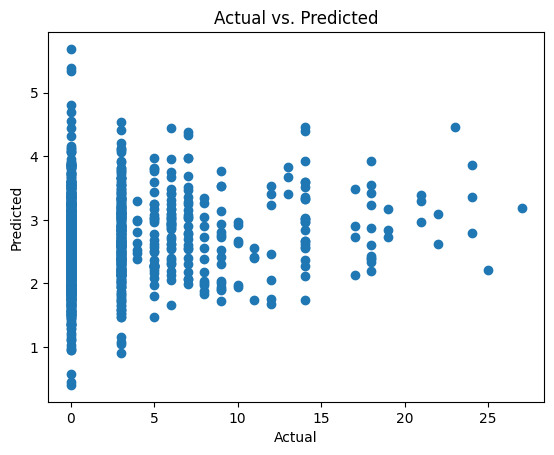

,week,batter,batter_fp,game_pk,pa,batting_order,est_slg,est_woba,batter_fp_25,batter_fp_75,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,pa_per_game
1882,19,592206,45.0,3,1293,4.333333,0.426,0.316,0.0,11.50,1.306667,88.000000,100.333333,97.333333,0.157773,0.067285,0.195987,0.059871,1.173901,9.295704,17.129167,79.833333,431.0
5257,30,595879,40.0,3,714,9.000000,0.323,0.257,0.0,7.00,1.273333,97.666667,101.666667,102.333333,0.193277,0.063025,0.143297,0.060943,1.130030,8.573120,22.100000,72.666667,238.0
1973,19,656555,39.0,3,957,5.333333,0.422,0.315,3.0,12.25,1.123333,97.666667,103.666667,102.333333,0.131661,0.059561,0.155597,0.071348,1.072277,8.649132,21.683333,72.000000,319.0
296,14,595777,34.0,3,1272,6.000000,0.451,0.364,3.0,12.00,1.286667,103.333333,103.666667,104.000000,0.193396,0.073113,0.180845,0.073456,1.134207,8.589996,16.591667,75.416667,424.0
4142,26,624424,33.0,3,915,6.333333,0.463,0.334,0.0,10.00,1.246667,96.333333,101.000000,99.000000,0.163934,0.059016,0.140737,0.076305,0.713889,8.461574,15.108333,81.833333,305.0


In [9]:
# get batter results by week so we have a bigger sample size
weekly_results = game_model_outcome_data
weekly_results['game_date'] = pd.to_datetime(weekly_results['game_date'])
weekly_results['week'] = weekly_results['game_date'].dt.isocalendar().week
# divide week by 2 so we get biweekly info
weekly_results['week'] = weekly_results['week']
# round
weekly_results['week'] = weekly_results['week'].round()

# get sum of batter_fp and mean of everything else
aggregations = {
    'batter_fp': 'sum',
    'game_pk': 'count',
    'pa': 'sum',
    'batting_order': 'mean',
    'est_slg': 'mean',
    'est_woba': 'mean',
    'batter_fp_25': 'mean',
    'batter_fp_75': 'mean',
    'WHIP': 'mean',
    'Stuff+': 'mean',
    'Location+': 'mean',
    'Pitching+': 'mean',
    'hr_friendly_launch_speed_freq': 'mean',
    'hr_friendly_launch_angle_freq': 'mean',
    'hr_friendly_launch_speed_pitcher': 'mean',
    'hr_friendly_launch_angle_pitcher': 'mean',
    'batter_fp_25_by_batter_handedness': 'mean',
    'batter_fp_75_by_batter_handedness': 'mean',
    'pitcher_fp_75_by_batter_handedness': 'mean',
    'opp_team_fp_75': 'mean',
}
# get keys in clip_values
keys = list(aggregations.keys())
weekly_results = weekly_results[['week', 'batter'] + keys]
weekly_results = weekly_results.groupby(['week', 'batter']).agg(aggregations).reset_index()
# filter pa < 10
#weekly_results = weekly_results[weekly_results['pa'] >= 10]
# weekly_results['batter_fp_per_pa'] = weekly_results['batter_fp'] / weekly_results['pa'] # average by plate appearances
weekly_results['pa_per_game'] = weekly_results['pa'] / weekly_results['game_pk']
# weekly_results['batter_fp_per_game'] = weekly_results['batter_fp'] / weekly_results['game_pk']

# predict batter_fp based on the other aggregated factors
weekly_prediction_features = weekly_results.columns.drop(['week', 'batter', 'batter_fp', 'pa', 'game_pk'])
X_train, X_test, y_train, y_test = train_test_split(weekly_results[weekly_prediction_features], weekly_results['batter_fp'], test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Model R2: ', r2)
print('Model RMSE: ', rmse)

# plot results
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()
weekly_results.sort_values(by='batter_fp', ascending=False).head()

In [10]:

def cluster_data(test_df=game_model_outcome_data, n_clusters=16):
  # remove non-numerics and batter_fp
  test_results = test_df[['batter_fp']]
  test_df = test_df[batter_predictive_pregame_features]
  test_model = KMeans(n_clusters=n_clusters)
  test_model.fit(test_df)
  test_df['cluster'] = test_model.labels_
  test_df['batter_fp'] = test_results

  # get number of times each cluster scores 0, 10+, and 20+
  test_df['zero_fp'] = np.where(test_df['batter_fp'] == 0, 1, 0)
  test_df['ten_fp'] = np.where(test_df['batter_fp'] >= 10, 1, 0)
  test_df['twenty_fp'] = np.where(test_df['batter_fp'] >= 20, 1, 0)

  # groupby cluster
  test_df = test_df.groupby('cluster').mean().reset_index()

  return test_df, test_model

clustered_data, clustered_model = cluster_data(game_model_outcome_data)


In [11]:
# identify best and worst clusters
best_clusters = clustered_data.sort_values(by='twenty_fp', ascending=False).head(round(len(clustered_data)*0.5))
best_clusters

,cluster,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp,zero_fp,ten_fp,twenty_fp
5,5,4.953614,6.681488,0.360472,0.288061,0.233885,6.810540,1.292326,92.337108,98.817073,96.873693,0.133126,0.059809,0.147372,0.067598,0.989139,8.334056,1.402439,0.729094,0.033101,0.003484
1,1,5.057143,6.536692,0.364295,0.291273,0.263952,7.052392,1.173747,96.579727,104.536446,103.583144,0.131863,0.061418,0.146336,0.064832,0.984996,8.519464,1.462415,0.746014,0.041002,0.003417
3,3,7.868533,3.382226,0.454007,0.340433,2.579098,11.730328,1.310393,87.488525,100.029508,96.662295,0.183309,0.064696,0.157907,0.066469,1.161475,8.693972,1.880328,0.673770,0.059016,0.003279
14,14,5.588482,5.840011,0.382349,0.301003,0.799528,7.985849,1.373333,84.267296,95.232704,92.550314,0.146099,0.058967,0.142074,0.055485,0.994240,8.472619,1.534591,0.691824,0.025157,0.003145
4,4,6.174299,5.410361,0.398053,0.310458,1.123950,8.889356,1.326737,111.829132,96.729692,100.266106,0.153887,0.062778,0.137628,0.057998,1.065294,8.713034,1.515406,0.686275,0.030812,0.002801
7,7,5.351518,6.129242,0.370106,0.294991,0.625283,7.479355,1.325713,83.168552,101.687783,96.967195,0.139810,0.059517,0.159656,0.061428,1.060145,8.451496,1.399321,0.707014,0.023756,0.002262
15,15,6.043498,5.425832,0.393307,0.308282,1.054305,8.545988,1.197750,88.761252,106.463796,102.583170,0.149033,0.062099,0.153860,0.078011,1.061996,8.592606,1.440313,0.731898,0.035225,0.001957
11,11,7.174473,4.128064,0.431783,0.329055,2.022314,10.530992,1.379967,96.704132,96.251240,95.659504,0.171355,0.064800,0.148079,0.063153,1.148485,8.704168,1.624793,0.662810,0.036364,0.001653


In [12]:
def normalize_features(data):
    normalized_data = data.copy()
    features = []
    for feature in clip_values:
        if feature in normalized_data.columns:
            features.append(feature)
            normalized_data[feature] = normalized_data[feature].clip(clip_values[feature][0], clip_values[feature][1])
    normalized_data[features] = normalize(normalized_data[features])
    return normalized_data

# get batter and pitcher fp models using predictive features; make it a keras model
def get_normalized_model(data, target, features):
    normalized_data = data.copy()
    # clip values
    for feature in features:
        if feature in clip_values:
            normalized_data[feature] = normalized_data[feature].clip(clip_values[feature][0], clip_values[feature][1])

    # normalize data
    normalized_data[features] = normalize(normalized_data[features])

    return get_linear_model(normalized_data, target, features)



def get_linear_model(data, target, features):
    X = data[features]
    # standardize X
    X = (X - X.mean()) / X.std()
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print('Model R2: ', r2)
    print('Model RMSE: ', rmse)
    return model

def standardized_predict(model, df):
    
    df = (df - df.mean()) / df.std()
        # print standard deviations for each feature used in model_batter_payoff
    df.fillna(0, inplace=True)
    return model.predict(df)

In [13]:
game_model_outcome_data.head()

,game_pk,batter,batter_fp,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,total_ball_movement,batter_adjusted_plate_x,team,batting_order,year,year_pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_name,batter_fp_25,batter_fp_75,batter_fp_mean,pa,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75,opp_team_fp_75,pitcher_fp,game_pk_by_batter_handedness,batter_by_batter_handedness,batter_fp_by_batter_handedness,release_speed_by_batter_handedness,release_pos_x_by_batter_handedness,release_pos_z_by_batter_handedness,pitcher_by_batter_handedness,zone_by_batter_handedness,balls_by_batter_handedness,strikes_by_batter_handedness,game_year_by_batter_handedness,pfx_x_by_batter_handedness,pfx_z_by_batter_handedness,plate_x_by_batter_handedness,plate_z_by_batter_handedness,outs_when_up_by_batter_handedness,inning_by_batter_handedness,fielder_2_by_batter_handedness,vx0_by_batter_handedness,vy0_by_batter_handedness,vz0_by_batter_handedness,ax_by_batter_handedness,ay_by_batter_handedness,az_by_batter_handedness,sz_top_by_batter_handedness,sz_bot_by_batter_handedness,pitcher.1_by_batter_handedness,fielder_2.1_by_batter_handedness,fielder_3_by_batter_handedness,fielder_4_by_batter_handedness,fielder_5_by_batter_handedness,fielder_6_by_batter_handedness,fielder_7_by_batter_handedness,fielder_8_by_batter_handedness,fielder_9_by_batter_handedness,release_pos_y_by_batter_handedness,woba_value_by_batter_handedness,babip_value_by_batter_handedness,iso_value_by_batter_handedness,at_bat_number_by_batter_handedness,pitch_number_by_batter_handedness,home_score_by_batter_handedness,away_score_by_batter_handedness,bat_score_by_batter_handedness,fld_score_by_batter_handedness,post_away_score_by_batter_handedness,post_home_score_by_batter_handedness,post_bat_score_by_batter_handedness,post_fld_score_by_batter_handedness,delta_home_win_exp_by_batter_handedness,delta_run_exp_by_batter_handedness,total_ball_movement_by_batter_handedness,batter_adjusted_plate_x_by_batter_handedness,batting_order_by_batter_handedness,year_by_batter_handedness,year_pa_by_batter_handedness,bip_by_batter_handedness,ba_by_batter_handedness,est_ba_by_batter_handedness,est_ba_minus_ba_diff_by_batter_handedness,slg_by_batter_handedness,est_slg_by_batter_handedness,est_slg_minus_slg_diff_by_batter_handedness,woba_by_batter_handedness,est_woba_by_batter_handedness,est_woba_minus_woba_diff_by_batter_handedness,hr_friendly_launch_speed_freq_by_batter_handedness,hr_friendly_launch_angle_freq_by_batter_handedness,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_mean_by_batter_handedness,pa_by_batter_handedness,WHIP_by_batter_handedness,Stuff+_by_batter_handedness,Location+_by_batter_handedness,Pitching+_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75_by_batter_handedness,pitc

In [14]:
# # get draftkings salaries based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLBMMDDYYYY.csv"
# def get_pregame_info(df, year, month, day):
#     pregame_info = data_before_date(df, year, month, day)

#     pregame_batter_game_fp = get_batter_game_fp(pregame_info)
#     pregame_pitcher_exp = get_pitcher_exp(pregame_info)
#     pregame_batter_exp = get_batter_exp(pregame_info)

#     # summarize df
#     pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


#     pregame_batting_order = get_pregame_batting_order(pregame_info)

#     # get batter, game_pk, and batting order from pregame_batting_order
#     pregame_batting_order = get_pregame_batting_order(pregame_info)
#     pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

#     # merge all pregame data
#     pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'])
#     pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter')

#     pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name')

#     # add pitcher_fp to pregame_data
#     pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'])

#     pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
#     pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean().reset_index()
#     pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
#     # merge the two dataframes
#     pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name')
#     # add a column for the change in batting order
#     pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']

#     return pregame_data

def get_dk_salaries(year, month, day, optional=""):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\DKSalariesMLB" + month + day + year + optional + ".csv"
    salaries = pd.read_csv(string)
    salaries['Name'] = salaries['Name'].str.lower()
    return salaries

# get contest standings based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandingsMMDDYYYY.csv"
def get_contest_standings(year, month, day):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\MLBContestStandings" + month + day + year + ".csv"
    print(string)
    contest_data = pd.read_csv(string)
    return contest_data

def get_contest_results(contest_data):
    contest_player_results = contest_data[['Player', '%Drafted', 'FPTS']]
    # drop nas
    contest_player_results = contest_player_results.dropna()
    # convert %Drafted to a float
    contest_player_results['%Drafted'] = contest_player_results['%Drafted'].str.replace('%', '').astype(float)
    # convert FPTS to a float
    contest_player_results['FPTS'] = contest_player_results['FPTS'].astype(float)
    # fix player names
    contest_player_results = fix_player_names(contest_player_results, 'Player')
    # remove suffixes
    contest_player_results = remove_suffixes(contest_player_results, 'Player')
    return contest_player_results

def get_leaderboard(contest_data):
    leaderboard = contest_data[['Rank', 'Points', 'Lineup']]
    leaderboard = leaderboard.dropna()
    # convert Points to a float
    leaderboard['Points'] = leaderboard['Points'].astype(float)
    return leaderboard

# get files in folder "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\" and return their names
def get_files():
    files = []
    for file in os.listdir("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\"):
        if file.endswith(".csv"):
            files.append(file)
    return files

In [15]:
this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
this_day_statcast

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length


In [16]:
get_dk_salaries(year, month, day, "")

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,SP,Tarik Skubal (35229123),tarik skubal,35229123,P,10800,MIN@DET 07/28/2024 01:40PM ET,DET,24.04
1,RP,Garrett Crochet (35228450),garrett crochet,35228450,P,10300,SEA@CWS 07/28/2024 02:10PM ET,CWS,21.18
2,SP,Freddy Peralta (35229124),freddy peralta,35229124,P,10300,MIA@MIL 07/28/2024 02:10PM ET,MIL,17.98
3,SP,Justin Verlander (35229125),justin verlander,35229125,P,10200,LAD@HOU 07/28/2024 02:10PM ET,HOU,14.84
4,SP,Chris Sale (35229126),chris sale,35229126,P,10200,ATL@NYM 07/28/2024 01:40PM ET,ATL,25.03
...,...,...,...,...,...,...,...,...,...
1199,3B,Rylan Bannon (35229095),rylan bannon,35229095,3B,2000,ATL@NYM 07/28/2024 01:40PM ET,NYM,0.00
1200,SS,Yolbert Sanchez (35229098),yolbert sanchez,35229098,SS,2000,ATL@NYM 07/28/2024 01:40PM ET,ATL,0.00
1201,2B/OF,Carlos Cortes (35229107),carlos cortes,35229107,2B/OF,2000,ATL@NYM 07/28/2024 01:40PM ET,NYM,0.00
1202,OF,Skye Bolt (35229113),skye bolt,35229113,OF,2000,ATL@NYM 07/28/2024 01:40PM ET,ATL,0.00


In [17]:

def compile_data_from_date(df, year, month, day):
    # merge dk salaries with pregame_data by batter_name
    salaries = get_dk_salaries(year, month, day, "")
    # select Name, Roster Position, batter_salary, and TeamAbbrev from salaries
    salaries = salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # only keep Name and batter_salary for pitchers
    pitcher_salaries = pitcher_salaries[['Name', 'Salary', 'TeamAbbrev']]
    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name', 'TeamAbbrev':'pitcher_team'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})

    this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
    this_day_statcast['player_name'] = this_day_statcast['player_name'].str.lower()
    # set 'team' as home_team if inning_topbot is 'Bot', and away_team if 'Top'
    this_day_statcast['team'] = this_day_statcast.apply(team, axis=1)
    # get only the first at bat for each batter per game
    this_day_batting_order = this_day_statcast.sort_values(by=['game_pk', 'at_bat_number'])
    this_day_batting_order = this_day_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    this_day_batting_order["batting_order"] = this_day_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    this_day_batting_order = this_day_batting_order[this_day_batting_order['batting_order'] <= 9]

    # get batter_name for this_day_batting_order
    batter_ids = this_day_batting_order['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.lower() + ' ' + batter_name_id_pairs['name_last'].str.lower()

    this_day_batting_order
    # merge this_day_batting_order with batter_name_id_pairs
    this_day_batting_order = pd.merge(this_day_batting_order, batter_name_id_pairs)

    # get pitcher_name for this_day_batting_order based on player_name
    this_day_batting_order = fix_player_names(this_day_batting_order, 'player_name')
    this_day_batting_order= fix_player_names2(this_day_batting_order, 'player_name')
    # rename player_name to Name
    this_day_batting_order = this_day_batting_order.rename(columns={'player_name': 'Name'})
    # merge with pitcher_salaries
    bo_with_salaries = pd.merge(this_day_batting_order, hitter_salaries)
    # only keep Name, team, batting_order, batter_name, Roster Position, Salary
    bo_with_salaries = bo_with_salaries[['Name', 'team', 'batting_order', 'batter_name', 'Roster Position', 'Salary']]
    bo_with_salaries = bo_with_salaries.rename(columns={'Salary': 'batter_salary'})
    bo_with_salaries = bo_with_salaries.rename(columns={'Name': 'pitcher_name'})
    # trim pitcher_name in bo_with_salaries
    bo_with_salaries['pitcher_name'] = trim(bo_with_salaries['pitcher_name'])
    # merge with pitcher_salaries
    new_merge = pd.merge(bo_with_salaries, pitcher_salaries)


    # use historic data to determine hitter and pitcher quality, with the goal of predicting batter_fp and pitcher_fp
    pregame_data = get_pregame_info(df, year, month, day)

    # get pitcher names, plus WHIP, Pitching+
    pitcher_names = pregame_data[['player_name', 'WHIP', 'Pitching+', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # rename player_name to pitcher_name
    pitcher_names = pitcher_names.rename(columns={'player_name': 'pitcher_name'})
    # fix names
    pitcher_names = fix_player_names(pitcher_names, 'pitcher_name')
    pitcher_names = fix_player_names2(pitcher_names, 'pitcher_name')
    # trim names
    pitcher_names['pitcher_name'] = trim(pitcher_names['pitcher_name'])
    # drop duplicates
    pitcher_names = pitcher_names.drop_duplicates()
    # get batter names, plus 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp'
    batter_names = pregame_data[['batter_name', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # trim names
    batter_names['batter_name'] = trim(batter_names['batter_name'])
    # drop duplicates
    batter_names = batter_names.drop_duplicates()

    new_merge['pitcher_name'] = new_merge['pitcher_name'].str.lower()
    pitcher_names['pitcher_name'] = pitcher_names['pitcher_name'].str.lower()
    batter_names['batter_name'] = batter_names['batter_name'].str.lower()

    # merge with new_merge by names to set up predictions
    all_data = pd.merge(new_merge, pitcher_names)
    all_data = pd.merge(all_data, batter_names)
    
    cols_allowed = all_data.columns
    # remove cols_allowed which are not in pregame_data
    cols_allowed = [col for col in cols_allowed if col in pregame_data.columns]
    # establish a model for each batter depending on the quality of pitchers they are facing
    target = pregame_data['batter_fp']
    # select only the relevant columns
    batter_model_features, batter_model_data = select_best_features(pregame_data[cols_allowed], target)
    batter_model = get_linear_model(pregame_data, ['batter_fp'], batter_model_features)
    # predict batter_fp and pitcher_fp for all_data
    all_data['batter_fp_pred'] = standardized_predict(batter_model, all_data[batter_model_features])

    
    pitcher_data = all_data.groupby('pitcher_name').mean(numeric_only=True).reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    
    target = pregame_data['pitcher_fp']
    # select only the relevant columns
    pitcher_model_features, pitcher_model_data = select_best_features(pregame_data[cols_allowed], target)
    pitcher_model = get_linear_model(pregame_data, ['pitcher_fp'], pitcher_model_features)
    # predict batter_fp and pitcher_fp for all_data
    pitcher_data['pitcher_fp_pred'] = standardized_predict(pitcher_model, pitcher_data[pitcher_model_features])

    # all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size
    teams_in_game_pk = all_data['team'].unique()
    all_data['teams_in_game_pk'] = teams_in_game_pk.size
    # get is_of
    all_data['is_of'] = all_data['Roster Position'].apply(lambda x: 1 if x == 'OF' else 0)
    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby('team')['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on='team')

    # select only pitcher_name and pitcher_fp_pred, then merge with all_data
    pitcher_data = pitcher_data[['pitcher_name', 'pitcher_fp_pred']]
    all_data = pd.merge(all_data, pitcher_data)

    # use leaderboard and results to determine the success of each player
    contest_data = get_contest_standings(year, month, day)
    contest_player_results = get_contest_results(contest_data)
    leaderboard = get_leaderboard(contest_data)
    leaderboard['payoff'] = leaderboard.apply(lambda x: get_payoff(x['Rank']), axis=1)

    # Establish payoffs for each player based on their performance as well as their appearance in the leaderboard's top 100
    # get the top 20 lineups
    #top_20 = leaderboard.head(20)
    # get all players in the all_data dataframe
    all_players = all_data['batter_name'].unique()
    # get pitchers as well
    pitchers = all_data['pitcher_name'].unique()
    # combine those vectors
    all_players = np.concatenate((all_players, pitchers))

    # enumerate payoffs for placements in the top 20
    #payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]

    # create a dictionary for player payoffs
    player_payoffs = {}

    # for each lineup in top_20, look for each player in all_players and increase their payoff by the corresponding value in payoffs if found
    for row in leaderboard.iterrows():
        lineup = row[1]['Lineup']
        payoff = row[1]['payoff']
        for player in lineup.split(','):
            if player in all_players:
                if player in player_payoffs:
                    player_payoffs[player] += payoff
                else:
                    player_payoffs[player] = payoff

    # for each player in all_players, if they are not in player_payoffs, set their payoff to 0
    for player in all_players:
        if player not in player_payoffs:
            player_payoffs[player] = 0

    # add player payoffs to all_data
    all_data['payoff'] = all_data['batter_name'].map(player_payoffs)

    # add pitcher payoffs to all_data
    all_data['pitcher_payoff'] = all_data['pitcher_name'].map(player_payoffs)


    # add contest results to all_data
    all_data_with_results = pd.merge(all_data, contest_player_results, left_on='batter_name', right_on='Player', how='left')
    # rename %drafted to batter_drafted and FPTS to batter_fpts
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'batter_drafted', 'FPTS': 'batter_fpts'})
    # drop Player column
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # do the same for pitchers
    all_data_with_results = pd.merge(all_data_with_results, contest_player_results, left_on='pitcher_name', right_on='Player', how='left')
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'pitcher_drafted', 'FPTS': 'pitcher_fpts'})
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # divide payoff and pitcher_payoff by (leaderboard_size * percent_drafted) to get payoff per usage
    leaderboard_size = leaderboard.shape[0]
    all_data_with_results['payoff'] = all_data_with_results['payoff'] / (leaderboard_size * all_data_with_results['batter_drafted']/100)
    all_data_with_results['pitcher_payoff'] = all_data_with_results['pitcher_payoff'] / (leaderboard_size * all_data_with_results['pitcher_drafted']/100)

    # get mean drafted % by team for pitchers
    team_pitcher_drafted = all_data_with_results.groupby('team')['pitcher_drafted'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted': 'opp_pitcher_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_pitcher_drafted)

    # get mean drafted % by pitcher_team for batters
    team_batter_drafted = all_data_with_results.groupby('pitcher_team')['batter_drafted'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted': 'opp_batter_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_drafted)

    # add a column for team_batter_fp_pred
    team_batter_fp_pred = all_data_with_results.groupby('team')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data_with_results = all_data_with_results.drop(columns=['team_batter_fp_pred'])
    all_data_with_results = pd.merge(all_data_with_results, team_batter_fp_pred)
    
    # X = all_data_with_results[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']]
    # y = all_data_with_results['batter_drafted']
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # # build a linear regression model to predict the ownership of each batter
    # model_batter_drafted = LinearRegression()
    # model_batter_drafted.fit(X_train, y_train)
    # y_pred = model_batter_drafted.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Ownership Model R2: ', r2)
    # print('Ownership Model RMSE: ', rmse)

    return all_data_with_results


def get_opposing_team(team, game_info):
    # if game info includes Postponed or game_info dtype is float return None
    if game_info == 'Postponed':
        return None
    if type(game_info) == float:
        return None
    # get the opposing team from the game_info
    matchup = game_info.split(' ')[0]
    teams = matchup.split('@')
    if teams[0] == team:
        return teams[1]
    else:
        return teams[0]


In [18]:
# def get_all_data_from_draftkings():
    # run compile_data_from_date for all dates and combine the results into a single dataframe
if True:
    all_data = pd.DataFrame()
    files = get_files()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            new_data = compile_data_from_date(df, y, m, d)
            new_data['game_date'] = y + '-' + m + '-' + d
            all_data = pd.concat([all_data, new_data])
            print(all_data.shape)

    # drop NaNs
    all_data = all_data.dropna()
    # add a column with value 1 if Roster Position contains OF or /
    all_data['is_of'] = all_data['Roster Position'].str.contains('OF|/').astype(int)

    # save all_data to csv in case of loss
    all_data.to_csv('C:\\Users\\jorda\\Downloads\\all_data.csv', index=False)


This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Model R2:  0.004859080212826994
Model RMSE:  3.056922367822807
Model R2:  0.19983599384684658
Model RMSE:  8.09898052506249
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
(32, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Model R2:  0.0016540021306428176
Model RMSE:  3.073636756256099
Model R2:  0.16565870043473652
Model RMSE:  8.484289245675024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
(214, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Model R2:  0.01485507700974864
Model RMSE:  3.1447411676022363
Model R2:  0.18029907594388694
Model RMSE:  8.51432962583185
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
(348, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Model R2:  0.013002439909269525
Model RMSE:  3.1497909925600447
Model R2:  0.15498549907867065
Model RMSE:  8.310488894190623
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
(450, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Model R2:  0.015458214980636487
Model RMSE:  2.954741318581577
Model R2:  0.1773011642910557
Model RMSE:  8.419061437953403
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
(586, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Model R2:  0.004340681475344721
Model RMSE:  3.25174039313384
Model R2:  0.19236107470433406
Model RMSE:  7.823199697408947
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
(690, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Model R2:  0.008322038696380374
Model RMSE:  3.3301908566881986
Model R2:  0.15441004017370852
Model RMSE:  8.472781503136677
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
(713, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Model R2:  -0.007817125791789836
Model RMSE:  2.9265585407363504
Model R2:  0.14184904132697396
Model RMSE:  8.219193179789999
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
(909, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Model R2:  0.010144938000882786
Model RMSE:  3.3268843493458
Model R2:  0.13198953530068203
Model RMSE:  8.097968423653628
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06022024.csv
(1064, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Model R2:  0.013392702934433398
Model RMSE:  2.894378429362808
Model R2:  0.14975213651365027
Model RMSE:  8.500468052941311
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
(1180, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Model R2:  0.004479629751543923
Model RMSE:  3.249829753671057
Model R2:  0.1733164015974058
Model RMSE:  8.404058235273373
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
(1319, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Model R2:  0.020873994239879012
Model RMSE:  3.118134090251252
Model R2:  0.14751670359791236
Model RMSE:  8.292163432493853
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
(1433, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Model R2:  0.015858420392814265
Model RMSE:  3.219925032288403
Model R2:  0.1508916011596022
Model RMSE:  8.384733526588269
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
(1542, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Model R2:  0.012368826258140286
Model RMSE:  3.036821589175888
Model R2:  0.18606339677801775
Model RMSE:  8.301647565667196
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
(1702, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Model R2:  0.017055140148849013
Model RMSE:  3.353626670764541
Model R2:  0.14352777848795029
Model RMSE:  8.330759467076255
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
(1850, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Model R2:  0.006886635429049104
Model RMSE:  3.3794458290607143
Model R2:  0.15702502061513046
Model RMSE:  8.297865632103115
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
(1986, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Model R2:  0.016661801309693525
Model RMSE:  2.9033012489294476
Model R2:  0.16840225004486864
Model RMSE:  8.348695338711225
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
(2072, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Model R2:  0.012578186743033681
Model RMSE:  2.962980089180706
Model R2:  0.14936763910633077
Model RMSE:  8.507134748899075
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
(2227, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Model R2:  0.014256741390295868
Model RMSE:  2.929132284606611
Model R2:  0.1634039474315715
Model RMSE:  8.282100220693708
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
(2286, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Model R2:  0.0238657241820881
Model RMSE:  3.0611974000611886
Model R2:  0.17578470966293225
Model RMSE:  8.360203372939553
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
(2346, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Model R2:  0.005625002391265954
Model RMSE:  3.0369911085569954
Model R2:  0.15821905417181858
Model RMSE:  8.10532498733569
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv
(2541, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Model R2:  0.015475437998181074
Model RMSE:  2.9429601306600213
Model R2:  0.1893087581140449
Model RMSE:  8.451801098628202
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv
(2650, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Model R2:  0.01505494426395726
Model RMSE:  3.181718920690043
Model R2:  0.15323492004607275
Model RMSE:  8.697284361031103
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv
(2799, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Model R2:  0.005636813165619481
Model RMSE:  3.191804096944597
Model R2:  0.1438599176354649
Model RMSE:  8.555112781046892
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv
(2927, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Model R2:  0.01522871772088552
Model RMSE:  3.2426125081509998
Model R2:  0.1830329059695368
Model RMSE:  7.970086520728048
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv
(3084, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Model R2:  0.015411448020773433
Model RMSE:  3.123497975186486
Model R2:  0.15855898900274956
Model RMSE:  8.428871717782734
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
(3147, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Model R2:  0.011287991501804928
Model RMSE:  3.1418758239780242
Model R2:  0.16275929405672174
Model RMSE:  8.604860667284752
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
(3262, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Model R2:  0.01111253061759776
Model RMSE:  3.1236541806423515
Model R2:  0.16001549805633775
Model RMSE:  8.51847017779435
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv
(3406, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Model R2:  0.008862829730611033
Model RMSE:  3.2228166966807708
Model R2:  0.1395446666046085
Model RMSE:  8.520718351443335
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv
(3527, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Model R2:  0.010846795483205551
Model RMSE:  3.2335463598435137
Model R2:  0.15212127800226272
Model RMSE:  8.414083625852149
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07142024.csv
(3651, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Model R2:  0.009956368303147056
Model RMSE:  2.9410033320730644
Model R2:  0.16608222040040987
Model RMSE:  8.15318958983849
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07192024.csv
(3800, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Model R2:  0.009309827598848575
Model RMSE:  3.1440070054513067
Model R2:  0.17960511775940113
Model RMSE:  8.407106640428266
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07202024.csv
(3955, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Model R2:  0.00229456622047175
Model RMSE:  2.999641264111355
Model R2:  0.16856873362850455
Model RMSE:  8.533100726337299
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07212024.csv
(4120, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Model R2:  0.005809979999762738
Model RMSE:  3.346461020558606
Model R2:  0.15262928331146042
Model RMSE:  8.632153267875362
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07222024.csv
(4253, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Model R2:  0.0025895427470723487
Model RMSE:  3.0984079623144196
Model R2:  0.13592456866179314
Model RMSE:  8.571157732697445
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07232024.csv
(4386, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Model R2:  0.013649795595798708
Model RMSE:  3.2609117889110806
Model R2:  0.18144783541071452
Model RMSE:  8.320108498635634
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07242024.csv
(4485, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Model R2:  0.012064959779990558
Model RMSE:  2.897504099050652
Model R2:  0.16223087094234756
Model RMSE:  8.532981235268391
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07252024.csv
(4563, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Model R2:  0.007980323656709198
Model RMSE:  3.1559298313522577
Model R2:  0.1718442198468937
Model RMSE:  8.68986855876858
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07262024.csv
(4730, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Model R2:  0.01635965558888175
Model RMSE:  3.10971371825259
Model R2:  0.17967036276669623
Model RMSE:  8.344922299567285
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07272024.csv
(4871, 31)


Below, use to get all old contest data; should not be run more than once per day as all data can be read from CSV

In [19]:
# uncomment the line below to get all data from DraftKings
#get_all_data_from_draftkings()

In [20]:
# read from all_data to save time
all_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_data.csv')
all_data.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date
0,jack flaherty,TOR,6.0,george springer,OF,4000,8400,DET,0.96,104.0,0.119266,0.059633,0.338,0.428,0.266,0.156757,0.075676,1.412875,4,1,18.475173,0.0,0.0,15.20,2.0,57.42,21.45,57.42,21.555714,7.349543,2024-05-23
1,kevin gausman,DET,5.0,gio urshela,3B,3000,8000,TOR,1.31,106.0,0.178010,0.078534,0.314,0.399,0.282,0.097561,0.036585,1.457369,4,0,14.976790,0.0,0.0,26.74,0.0,52.82,32.50,52.82,23.110000,10.757403,2024-05-23
2,jack flaherty,TOR,9.0,kevin kiermaier,OF,2800,8400,DET,0.96,104.0,0.119266,0.059633,0.229,0.278,0.186,0.098901,0.054945,0.790738,4,1,18.475173,0.0,0.0,20.57,10.0,57.42,21.45,57.42,21.555714,7.349543,2024-05-23
3,kevin gausman,DET,9.0,carson kelly,C,2700,8000,TOR,1.31,106.0,0.178010,0.078534,0.335,0.436,0.248,0.162791,0.023256,1.818754,4,0,14.976790,0.0,0.0,19.03,3.0,52.82,32.50,52.82,23.110000,10.757403,2024-05-23
4,jack flaherty,TOR,2.0,danny jansen,C,4700,8400,DET,0.96,104.0,0.119266,0.059633,0.308,0.380,0.221,0.182927,0.146341,0.987052,4,0,18.475173,0.0,0.0,32.82,16.0,57.42,21.45,57.42,21.555714,7.349543,2024-05-23


In [21]:
# for each date after 4/7, get avg batter_fpts for the previous 10 days
def get_avg_batter_fpts(df):
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(by='game_date')
    df['avg_batter_fpts_last_10'] = df['batter_fpts'].rolling(window=10).mean()
    # fill NaNs with 0
    df['avg_batter_fpts_last_10'] = df['avg_batter_fpts_last_10'].fillna(0)
    return df

all_data = get_avg_batter_fpts(all_data)


Model R2:  0.051611549559224645
Model RMSE:  6.8015697143234055


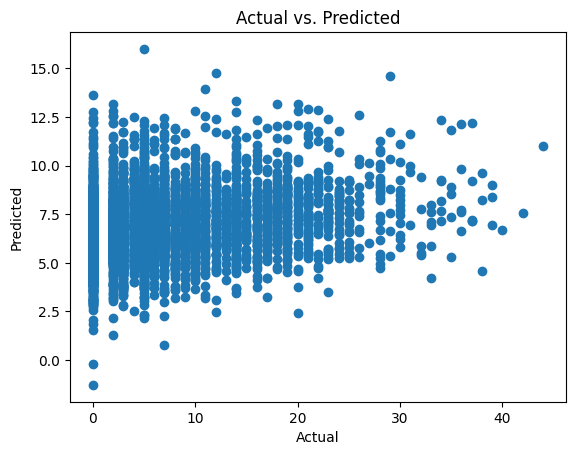

In [22]:

# batter_fp_model = get_normalized_model(game_model_outcome_data, 'batter_fp', batter_predictive_pregame_features)
# pitcher_fp_model = get_normalized_model(game_model_outcome_data, 'pitcher_fp', pitcher_predictive_pregame_features)
all_data=all_data.rename(columns={'batter_fpts':'batter_fp', 'pitcher_fpts':'pitcher_fp'})
batter_fp_model_data = all_data.drop(columns=['batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred'])

# create models by selecting best features via function
target = batter_fp_model_data['batter_fp']
batter_fp_features, batter_fp_data = select_best_features(batter_fp_model_data.drop(columns='batter_fp'), target)

batter_fp_model = get_linear_model(batter_fp_model_data, ['batter_fp'], batter_fp_features)

# plot predicted vs actual
y_pred = standardized_predict(batter_fp_model, batter_fp_model_data[batter_fp_features])
plt.scatter(batter_fp_model_data['batter_fp'], y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [23]:
target = batter_fp_model_data['pitcher_fp']
pitcher_fp_features, pitcher_fp_data = select_best_features(batter_fp_model_data.drop(columns='pitcher_fp'), target)

pitcher_fp_model = get_linear_model(batter_fp_model_data, ['pitcher_fp'], pitcher_fp_features)

Model R2:  0.1308800101305262
Model RMSE:  10.529973375345744


In [24]:


# # get team_batter_fp_pred
# team_batter_fp_pred = all_data.groupby(['team', 'pitcher_name'])['batter_fp_pred'].mean().reset_index()
# team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
# all_data = pd.merge(all_data, team_batter_fp_pred, on=['team', 'pitcher_name'])

# # multiply by 9 for team_batter_fp_pred
# all_data['team_batter_fp_pred'] = all_data['team_batter_fp_pred'] * 9
# drop payoff and pitcher_payoff
all_data = all_data.drop(columns=['payoff', 'pitcher_payoff'], axis=1)


In [25]:
# remove duplicates from all_data
# all_data = all_data.drop_duplicates(keep='first', subset=['batter_name', 'pitcher_name', 'game_date'])
# # change team from AZ to ARI
# all_data['team'] = all_data['team'].replace('AZ', 'ARI')
# all_data.shape

In [26]:
# get other needed data for models
# batter_fp_mean
batter_fp_mean = all_data.groupby('batter_name')['batter_fp'].mean().reset_index()
batter_fp_mean = batter_fp_mean.rename(columns={'batter_fp': 'batter_fp_mean'})
all_data = pd.merge(all_data, batter_fp_mean)

In [27]:
# get team_avg_drafted to plug into the model
team_avg_drafted_pred = all_data.groupby(['team'])['batter_drafted'].mean().reset_index()
team_avg_drafted_pred = team_avg_drafted_pred.rename(columns={'batter_drafted': 'team_avg_drafted'})
all_data = pd.merge(all_data, team_avg_drafted_pred)

In [28]:
# get team_against_pitcher_avg_drafted to plug into the model
team_against_pitcher_avg_drafted = all_data.groupby(['pitcher_name'])['batter_drafted'].mean().reset_index()
team_against_pitcher_avg_drafted = team_against_pitcher_avg_drafted.rename(columns={'batter_drafted': 'team_against_pitcher_avg_drafted'})
all_data = pd.merge(all_data, team_against_pitcher_avg_drafted)
all_data.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted
0,jack flaherty,TOR,6.0,george springer,OF,4000,8400,DET,0.96,104.0,0.119266,0.059633,0.338,0.428,0.266,0.156757,0.075676,1.412875,4,1,18.475173,15.20,2.0,57.42,21.45,57.42,21.555714,7.349543,2024-05-23,0.0,6.869565,5.540208,7.102963
1,grayson rodriguez,CWS,7.0,korey lee,C,3700,9400,BAL,1.22,106.0,0.130178,0.059172,0.273,0.373,0.224,0.186275,0.058824,1.200143,4,0,18.049459,11.89,0.0,63.93,19.85,63.93,16.057778,11.197672,2024-05-23,0.0,4.700000,3.676278,4.567925
2,grayson rodriguez,CWS,3.0,andrew vaughn,1B,3300,9400,BAL,1.22,106.0,0.130178,0.059172,0.326,0.450,0.249,0.215789,0.084211,1.368577,4,0,18.049459,12.79,7.0,63.93,19.85,63.93,16.057778,11.197672,2024-05-23,0.0,7.272727,3.676278,4.567925
3,mike clevinger,BAL,1.0,gunnar henderson,SS,6200,5000,CWS,1.94,100.0,0.111111,0.111111,0.389,0.532,0.290,0.238095,0.061905,2.267671,4,0,10.631589,49.80,11.0,23.55,4.50,23.55,28.867778,18.878813,2024-05-23,0.0,11.045455,6.661882,28.867778
4,mike clevinger,BAL,6.0,colton cowser,OF,4500,5000,CWS,1.94,100.0,0.111111,0.111111,0.353,0.491,0.245,0.206667,0.053333,2.273710,4,1,10.631589,20.29,0.0,23.55,4.50,23.55,28.867778,18.878813,2024-05-23,0.0,9.000000,6.661882,28.867778


Batter Drafted % Linear Regression model

In [29]:


# create a model to predict batter_drafted; select features with function
target = all_data['batter_drafted']
batter_drafted_features, batter_drafted_data = select_best_features(all_data.drop(columns='batter_drafted'), target)

model_batter_drafted = get_linear_model(all_data, 'batter_drafted', batter_drafted_features)


# # model batter_drafted from all_data
# X = all_data[batter_drafted_features]
# y = all_data['batter_drafted']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # build a linear regression model to predict the ownership of each batter
# model_batter_drafted = LinearRegression()
# model_batter_drafted.fit(X_train, y_train)
# y_pred = model_batter_drafted.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Ownership Model R2: ', r2)
# print('Ownership Model RMSE: ', rmse)

# get normalized model
# model_batter_drafted = get_normalized_model(all_data, 'batter_drafted', batter_drafted_features)


Model R2:  0.5051249676945311
Model RMSE:  3.424276625285674


In [30]:
all_data[all_data.isna().any(axis=1)]

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted


In [31]:
# def add_batter_ownership(all_data=all_data, model_batter_drafted=model_batter_drafted, X=X):
#     # create a copy of all_data and add the predicted ownership to it
#     all_data_with_ownership = all_data.copy()
#     all_data_with_ownership['batter_drafted_pred'] = model_batter_drafted.predict(X)
#     all_data_with_ownership['batter_drafted_pred'] = all_data_with_ownership['batter_drafted_pred']
#     all_data_with_ownership.head()
#     return all_data_with_ownership

all_data_with_ownership = all_data.copy()
all_data_with_ownership['batter_drafted_pred'] = standardized_predict(model_batter_drafted, all_data[batter_drafted_features])

In [32]:
# get pitcher_against_team_avg_drafted and pitcher_average_drafted to plug into the model
pitcher_against_team_avg_drafted = all_data_with_ownership.groupby(['team'])['pitcher_drafted'].mean().reset_index()
pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_against_team_avg_drafted'})
all_data_with_ownership = pd.merge(all_data_with_ownership, pitcher_against_team_avg_drafted, on='team')

pitcher_avg_drafted = all_data_with_ownership.groupby(['pitcher_name'])['pitcher_drafted'].mean().reset_index()
pitcher_avg_drafted = pitcher_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_avg_drafted'})
all_data_with_ownership = pd.merge(all_data_with_ownership, pitcher_avg_drafted)

In [33]:
all_data_with_ownership['team'].unique()

array(['TOR', 'CWS', 'BAL', 'DET', 'LAD', 'CIN', 'COL', 'LAA', 'CLE',
       'PHI', 'BOS', 'MIL', 'AZ', 'MIA', 'HOU', 'OAK', 'NYM', 'SF', 'SD',
       'NYY', 'TEX', 'MIN', 'STL', 'WSH', 'ATL', 'CHC', 'KC', 'SEA', 'TB',
       'PIT'], dtype=object)

In [34]:
# reduce df to pitcher name, batter_salary, pitcher_salary, WHIP, Pitching+, team, pitcher_fp_pred, pitcher_drafted, team_batter_fp_pred, and teams_in_game_pk; get sum of batter_salary and mean of everything else
pitcher_avg_drafted_pred = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'team', 'pitcher_fp_pred', 'pitcher_drafted', 'team_batter_fp_pred', 'teams_in_game_pk', 'pitcher_avg_drafted', 'pitcher_against_team_avg_drafted']]
pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.groupby(['pitcher_name', 'pitcher_drafted']).agg({'batter_salary': 'sum', 'pitcher_salary': 'mean', 'WHIP': 'mean', 'Pitching+': 'mean', 'pitcher_fp_pred': 'mean', 'team_batter_fp_pred': 'mean', 'teams_in_game_pk': 'mean', 'pitcher_avg_drafted':'mean', 'pitcher_against_team_avg_drafted':'mean'}).reset_index()
# merge this with unique pitcher_name and pitcher_drafted
pitcher_avg_drafted_pred.head()

,pitcher_name,pitcher_drafted,batter_salary,pitcher_salary,WHIP,Pitching+,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,pitcher_avg_drafted,pitcher_against_team_avg_drafted
0,aaron civale,0.81,34500,7800.0,1.38,101.0,13.825643,14.187198,20.0,9.83871,10.335000
1,aaron civale,1.95,37600,7200.0,1.38,101.0,14.454050,14.228403,26.0,9.83871,8.205323
2,aaron civale,17.69,31700,6400.0,1.38,101.0,13.892695,13.925959,21.0,9.83871,10.335000
3,aaron civale,20.20,20900,6200.0,1.38,101.0,14.384890,10.816552,18.0,9.83871,17.156918
4,aaron nola,21.77,35800,10000.0,1.04,105.0,20.072768,11.127630,13.0,21.77000,10.335000


In [35]:
# # create a model to predict pitcher_drafted; select features with function
target = pitcher_avg_drafted_pred['pitcher_drafted']
pitcher_drafted_features, pitcher_drafted_data = select_best_features(pitcher_avg_drafted_pred.drop(columns='pitcher_drafted'), target)

model_pitcher_drafted = get_linear_model(pitcher_avg_drafted_pred, 'pitcher_drafted', pitcher_drafted_features)

# linear regression model to predict pitcher_drafted
# # rename batter_salary to team_batter_salary
# pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.rename(columns={'batter_salary': 'team_batter_salary'})
# pitcher_drafted_features = ['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk', 'pitcher_avg_drafted', 'pitcher_against_team_avg_drafted']
# X = pitcher_avg_drafted_pred[pitcher_drafted_features]
# y = pitcher_avg_drafted_pred['pitcher_drafted']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# model_pitcher_drafted = LinearRegression()
# model_pitcher_drafted.fit(X_train, y_train)
# y_pred = model_pitcher_drafted.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Pitcher Ownership Model R2: ', r2)
# print('Pitcher Ownership Model RMSE: ', rmse)

# get normalized model
# model_pitcher_drafted = get_normalized_model(pitcher_avg_drafted_pred, 'pitcher_drafted', pitcher_drafted_features)

Model R2:  0.6730554237692212
Model RMSE:  8.137160391766798


In [36]:

# get team_batter_salary for all_data_with_ownership
team_batter_salary = all_data_with_ownership.groupby('team')['batter_salary'].sum().reset_index()
team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
all_data_with_ownership = pd.merge(all_data_with_ownership, team_batter_salary)



In [37]:

# add pitcher_drafted_pred to all_data_with_ownership
all_data_with_ownership['pitcher_drafted_pred'] = standardized_predict(model_pitcher_drafted, all_data_with_ownership[pitcher_drafted_features])

In [38]:
# fix payoffs; previous function made them all 0 so we will simulate them as a function of the player's performance and drafted percentage
all_data_with_ownership['payoff'] = all_data_with_ownership['batter_fp'] * (1-all_data_with_ownership['batter_drafted']/100)
all_data_with_ownership['pitcher_payoff'] = all_data_with_ownership['pitcher_fp'] * (1-all_data_with_ownership['pitcher_drafted']/100)
all_data_with_ownership.sort_values(by='payoff', ascending=False).head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,team_batter_salary,pitcher_drafted_pred,payoff,pitcher_payoff
3480,jose quintana,COL,7.0,michael toglia,1B,3900,7900,NYM,1.26,93.0,0.160584,0.041363,0.354,0.535,0.243,0.202128,0.069149,1.860790,18,0,15.079967,1.34,42.0,37.03,14.55,37.03,1.576667,13.076587,2024-07-14,15.8,9.210526,5.076161,5.052333,5.078642,21.006741,11.554667,868300,16.948728,41.4372,9.162135
2421,spencer arrighetti,DET,3.0,riley greene,OF,5200,7800,HOU,1.60,98.0,0.104167,0.070833,0.361,0.497,0.256,0.190972,0.062500,1.798069,14,1,12.733303,8.30,44.0,27.71,-11.80,27.71,5.407500,13.022611,2024-06-15,14.5,9.333333,5.231538,6.020750,8.337553,19.622692,22.743750,448500,29.324468,40.3480,-8.530220
3479,jose quintana,COL,2.0,ezequiel tovar,SS,4000,7900,NYM,1.26,93.0,0.160584,0.041363,0.282,0.394,0.232,0.120482,0.062651,1.083568,18,0,15.079967,2.65,39.0,37.03,14.55,37.03,1.576667,13.076587,2024-07-14,13.4,11.846154,5.076161,5.052333,8.040796,21.006741,11.554667,868300,16.948728,37.9665,9.162135
3266,corbin burnes,HOU,9.0,chas mccormick,OF,3300,9100,BAL,1.04,108.0,0.121951,0.032520,0.289,0.358,0.229,0.107692,0.069231,1.355820,16,1,18.109880,0.22,38.0,20.15,14.75,20.15,2.448000,6.584687,2024-06-22,8.2,5.928571,4.461074,1.500909,-0.650143,7.877521,19.372500,439600,16.435181,37.9164,11.777875
4615,marcus stroman,BOS,5.0,tyler o'neill,OF,5300,7600,NYY,1.32,93.0,0.145299,0.068376,0.344,0.495,0.223,0.202572,0.067524,1.876923,18,1,11.539284,4.34,39.0,0.87,-4.50,0.87,7.210000,15.220522,2024-07-27,13.0,14.142857,7.366000,4.410556,6.629297,8.832821,3.680556,790100,0.811402,37.3074,-4.460850


In [39]:
# create a model to predict payoff for each player, select features with function

target = all_data_with_ownership['payoff']
batter_payoff_features, batter_payoff_data = select_best_features(all_data_with_ownership.drop(columns=['payoff', 'teams_in_game_pk', 'is_of']), target)

model_batter_payoff = get_linear_model(all_data_with_ownership, 'payoff', batter_payoff_features)

# batter_payoff_features = ['teams_in_game_pk', 'batting_order',  'est_woba',  'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq','team_batter_fp_pred', 'team_batter_fp_pred']
# # create a tensorflow model to predict payoff for each player
# X = all_data_with_ownership[batter_payoff_features]
# y = all_data_with_ownership['payoff'] / (all_data_with_ownership['batter_drafted']/100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# model_batter_payoff = LinearRegression()
# model_batter_payoff.fit(X_train, y_train)

# y_pred = model_batter_payoff.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Payoff Model R2: ', r2)
# print('Payoff Model RMSE: ', rmse)

# get normalized model
# model_batter_payoff = get_normalized_model(all_data_with_ownership, 'payoff', batter_payoff_features)



Model R2:  0.12407265963408176
Model RMSE:  6.0858357019077225


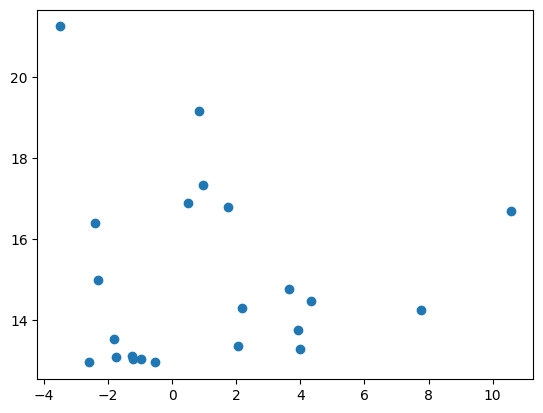

In [40]:
player_historic_payoffs = all_data_with_ownership[['pitcher_name', 'team', 'payoff', 'team_batter_fp_pred', 'batter_drafted', 'batter_drafted_pred']]
team_avg_drafted = player_historic_payoffs.groupby('team')[['batter_drafted', 'batter_drafted_pred']].mean().reset_index()
team_avg_drafted = team_avg_drafted.rename(columns={'batter_drafted': 'team_avg_drafted', 'batter_drafted_pred': 'team_avg_drafted_pred'})
team_against_pitcher_avg_drafted = player_historic_payoffs.groupby(['pitcher_name'])[['batter_drafted', 'batter_drafted_pred']].mean().reset_index()
team_against_pitcher_avg_drafted = team_against_pitcher_avg_drafted.rename(columns={'batter_drafted': 'team_against_pitcher_avg_drafted', 'batter_drafted_pred': 'team_against_pitcher_avg_drafted_pred'})
player_historic_payoffs = player_historic_payoffs.groupby(['pitcher_name', 'team']).agg({'payoff':'mean', 'team_batter_fp_pred':'mean', 'batter_drafted':'mean', 'batter_drafted_pred':'mean'}).reset_index()
player_historic_payoffs = pd.merge(player_historic_payoffs, team_avg_drafted)
player_historic_payoffs = pd.merge(player_historic_payoffs, team_against_pitcher_avg_drafted)
player_historic_payoffs['batter_drafted_pred_delta'] = player_historic_payoffs['batter_drafted_pred'] - ( player_historic_payoffs['team_avg_drafted_pred'])
top_historic_payoffs = player_historic_payoffs.sort_values(by='payoff', ascending=False).head(22)

# plot payoff vs batter_drafted_pred_delta
plt.scatter(top_historic_payoffs['batter_drafted_pred_delta'], top_historic_payoffs['payoff'])

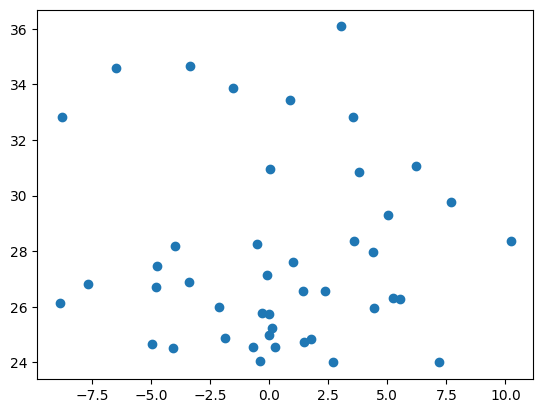

In [41]:
pitcher_historic_payoffs = all_data_with_ownership[['pitcher_name', 'team', 'pitcher_payoff', 'pitcher_drafted', 'pitcher_drafted_pred']]
pitcher_avg_drafted = pitcher_historic_payoffs.groupby('pitcher_name')[['pitcher_drafted', 'pitcher_drafted_pred']].mean().reset_index()
pitcher_avg_drafted = pitcher_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_avg_drafted', 'pitcher_drafted_pred': 'pitcher_avg_drafted_pred'})
pitcher_against_team_avg_drafted = pitcher_historic_payoffs.groupby(['team'])[['pitcher_drafted', 'pitcher_drafted_pred']].mean().reset_index()
pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_against_team_avg_drafted', 'pitcher_drafted_pred': 'pitcher_against_team_avg_drafted_pred'})
pitcher_historic_payoffs = pitcher_historic_payoffs.groupby(['pitcher_name', 'team']).agg({'pitcher_payoff':'mean', 'pitcher_drafted':'mean', 'pitcher_drafted_pred':'mean'}).reset_index()
pitcher_historic_payoffs = pd.merge(pitcher_historic_payoffs, pitcher_avg_drafted)
pitcher_historic_payoffs = pd.merge(pitcher_historic_payoffs, pitcher_against_team_avg_drafted)
pitcher_historic_payoffs['pitcher_drafted_pred_delta'] = pitcher_historic_payoffs['pitcher_drafted_pred'] - ( pitcher_historic_payoffs['pitcher_avg_drafted_pred'])
top_pitcher_historic_payoffs = pitcher_historic_payoffs.sort_values(by='pitcher_payoff', ascending=False).head(44)

# plot payoff vs pitcher_drafted_pred_delta
plt.scatter(top_pitcher_historic_payoffs['pitcher_drafted_pred_delta'], top_pitcher_historic_payoffs['pitcher_payoff'])

In [42]:
team_avg_drafted_pred = player_historic_payoffs.groupby('team')[['team_avg_drafted_pred', 'team_avg_drafted',]].first().reset_index()
# change AZ to ARI and WSH to WAS
#team_avg_drafted_pred = team_avg_drafted_pred.replace({'team': {'AZ': 'ARI', 'WAS': 'WSH'}})

team_against_pitcher_avg_drafted_pred = player_historic_payoffs.groupby('pitcher_name')[['team_against_pitcher_avg_drafted', 'team_against_pitcher_avg_drafted_pred']].first().reset_index()

In [43]:
# create a model to predict pitcher_payoff; select features with function
target = all_data_with_ownership['pitcher_payoff']
pitcher_payoff_features, pitcher_payoff_data = select_best_features(all_data_with_ownership.drop(columns=['pitcher_payoff', 'teams_in_game_pk', 'is_of']), target)

model_pitcher_payoff = get_linear_model(all_data_with_ownership, 'pitcher_payoff', pitcher_payoff_features)

# # build a model for pitcher payoffs
# pitcher_payoff_features = ['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']
# just_pitcher_payoff_data = all_data_with_ownership[pitcher_payoff_features + ['pitcher_payoff', 'pitcher_drafted']]
# just_pitcher_payoff_data = just_pitcher_payoff_data.drop_duplicates()
# X = just_pitcher_payoff_data[pitcher_payoff_features]
# y = just_pitcher_payoff_data['pitcher_payoff'] / (just_pitcher_payoff_data['pitcher_drafted']/100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # build a linear regression model to predict the payoff of each pitcher
# model_pitcher_payoff = LinearRegression()
# model_pitcher_payoff.fit(X_train, y_train)
# y_pred = model_pitcher_payoff.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Pitcher Payoff Model R2: ', r2)
# print('Pitcher Payoff Model RMSE: ', rmse)

# get normalized model
# model_pitcher_payoff = get_normalized_model(all_data_with_ownership, 'pitcher_payoff', pitcher_payoff_features)

Model R2:  0.09250456355195658
Model RMSE:  8.944210032590682


In [44]:
# show which players correspond to the highest predicted payoffs
all_data_with_payoff_pred  = all_data_with_ownership.copy()
all_data_with_payoff_pred['batter_payoff_pred'] = standardized_predict(model_batter_payoff, all_data_with_payoff_pred[batter_payoff_features])
all_data_with_payoff_pred = all_data_with_payoff_pred.sort_values(by='batter_payoff_pred', ascending=False)
all_data_with_payoff_pred[batter_payoff_features]

,batting_order,batter_salary,pitcher_salary,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_slg,hr_friendly_launch_speed_freq,pitcher_fp_pred,batter_fp_mean,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,pitcher_drafted_pred
4645,5.0,4000,5300,1.45,100.0,0.140167,0.066946,0.351,0.139130,11.202310,18.000000,9.355122,10.690121,8.591530,2.092927,0.099910
1329,5.0,5200,5800,2.40,95.0,0.200000,0.150000,0.495,0.174419,2.929249,14.142857,15.282500,15.854909,8.832821,1.460000,4.952448
4517,2.0,3500,5500,1.54,97.0,0.162791,0.051163,0.351,0.127273,10.890293,18.000000,9.785556,11.841320,8.591530,4.745000,0.537999
3677,9.0,4100,5700,1.54,97.0,0.162304,0.052356,0.351,0.081395,11.290840,18.000000,9.785556,7.793147,8.591530,4.745000,3.027136
3709,8.0,3000,5200,1.49,101.0,0.126214,0.064725,0.533,0.236364,12.524323,16.500000,11.472609,11.110343,10.650654,2.153478,2.628424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,8.0,4400,8300,1.08,103.0,0.146739,0.103261,0.335,0.129032,19.111689,0.000000,3.590926,-1.328522,7.225574,15.064815,10.429851
382,9.0,2700,8500,1.31,106.0,0.177083,0.078125,0.327,0.238095,13.985033,0.000000,5.742667,2.126664,24.151333,31.244889,34.789702
362,8.0,3500,8800,1.16,99.0,0.102128,0.046809,0.350,0.207317,17.955191,0.000000,1.467083,-0.564176,14.054741,24.239167,23.785100
4163,9.0,2600,9800,0.95,103.0,0.124413,0.032864,0.326,0.250000,22.171414,1.000000,2.470625,-1.301795,7.225574,30.695000,25.605017


In [45]:

# get avg_batter_fp, avg_batting_order, and for pregame_data
# pregame_data = get_pregame_info(df, year, month, day)

In [46]:
features_from_batters = ['batting_order_by_pitcher_handedness',
    'est_slg',
    'est_woba',
    'batter_fp_25_by_pitcher_handedness',
    'batter_fp_75_by_pitcher_handedness',
    'hr_friendly_launch_speed_freq',
    'hr_friendly_launch_angle_freq',
 ]

features_from_pitchers = ['WHIP','Stuff+',
    'Location+',
    'Pitching+','hr_friendly_launch_speed_pitcher',
    'hr_friendly_launch_angle_pitcher',
    'pitcher_fp_75_by_batter_handedness',
    'opp_team_fp_75','batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']

In [47]:
game_model_outcome_data.head(2)

,game_pk,batter,batter_fp,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,total_ball_movement,batter_adjusted_plate_x,team,batting_order,year,year_pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_name,batter_fp_25,batter_fp_75,batter_fp_mean,pa,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75,opp_team_fp_75,pitcher_fp,game_pk_by_batter_handedness,batter_by_batter_handedness,batter_fp_by_batter_handedness,release_speed_by_batter_handedness,release_pos_x_by_batter_handedness,release_pos_z_by_batter_handedness,pitcher_by_batter_handedness,zone_by_batter_handedness,balls_by_batter_handedness,strikes_by_batter_handedness,game_year_by_batter_handedness,pfx_x_by_batter_handedness,pfx_z_by_batter_handedness,plate_x_by_batter_handedness,plate_z_by_batter_handedness,outs_when_up_by_batter_handedness,inning_by_batter_handedness,fielder_2_by_batter_handedness,vx0_by_batter_handedness,vy0_by_batter_handedness,vz0_by_batter_handedness,ax_by_batter_handedness,ay_by_batter_handedness,az_by_batter_handedness,sz_top_by_batter_handedness,sz_bot_by_batter_handedness,pitcher.1_by_batter_handedness,fielder_2.1_by_batter_handedness,fielder_3_by_batter_handedness,fielder_4_by_batter_handedness,fielder_5_by_batter_handedness,fielder_6_by_batter_handedness,fielder_7_by_batter_handedness,fielder_8_by_batter_handedness,fielder_9_by_batter_handedness,release_pos_y_by_batter_handedness,woba_value_by_batter_handedness,babip_value_by_batter_handedness,iso_value_by_batter_handedness,at_bat_number_by_batter_handedness,pitch_number_by_batter_handedness,home_score_by_batter_handedness,away_score_by_batter_handedness,bat_score_by_batter_handedness,fld_score_by_batter_handedness,post_away_score_by_batter_handedness,post_home_score_by_batter_handedness,post_bat_score_by_batter_handedness,post_fld_score_by_batter_handedness,delta_home_win_exp_by_batter_handedness,delta_run_exp_by_batter_handedness,total_ball_movement_by_batter_handedness,batter_adjusted_plate_x_by_batter_handedness,batting_order_by_batter_handedness,year_by_batter_handedness,year_pa_by_batter_handedness,bip_by_batter_handedness,ba_by_batter_handedness,est_ba_by_batter_handedness,est_ba_minus_ba_diff_by_batter_handedness,slg_by_batter_handedness,est_slg_by_batter_handedness,est_slg_minus_slg_diff_by_batter_handedness,woba_by_batter_handedness,est_woba_by_batter_handedness,est_woba_minus_woba_diff_by_batter_handedness,hr_friendly_launch_speed_freq_by_batter_handedness,hr_friendly_launch_angle_freq_by_batter_handedness,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_mean_by_batter_handedness,pa_by_batter_handedness,WHIP_by_batter_handedness,Stuff+_by_batter_handedness,Location+_by_batter_handedness,Pitching+_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75_by_batter_handedness,pitc

In [48]:
dupe_cols = all_data_with_payoff_pred.columns
pitcher_data = game_model_outcome_data[['Name', 'p_throws', 'stand'] + features_from_pitchers].drop_duplicates(subset=['Name', 'p_throws', 'stand'], keep='last')
pitcher_data = fix_player_names(pitcher_data, 'Name')
pitcher_data = pitcher_data.rename(columns={'Name': 'pitcher_name'})

batter_data = game_model_outcome_data[['batter_name', 'p_throws', 'stand'] + features_from_batters].drop_duplicates(subset=['batter_name', 'p_throws', 'stand'], keep='last')
batter_data = fix_player_names(batter_data, 'batter_name')

for col in dupe_cols:
    if col in all_data_with_payoff_pred.columns:
        if col in pitcher_data.columns and col not in ['pitcher_name', 'p_throws', 'stand']:
            pitcher_data = pitcher_data.drop(columns=col)
        if col in batter_data.columns and col not in ['batter_name', 'p_throws', 'stand']:
            batter_data = batter_data.drop(columns=col)

In [49]:
all_data_with_payoff_pred.sort_values(by="batter_payoff_pred", ascending=False).head()#[all_data_with_payoff_pred.isna().any(axis=1)]

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,team_batter_salary,pitcher_drafted_pred,payoff,pitcher_payoff,batter_payoff_pred
4645,ryan feltner,SF,5.0,tyler fitzgerald,2B/SS,4000,5300,COL,1.45,100.0,0.140167,0.066946,0.285,0.351,0.234,0.139130,0.069565,1.628909,18,1,11.202310,18.33,3.0,4.51,18.10,4.51,6.210000,14.823952,2024-07-27,6.5,18.000000,6.123169,9.355122,10.690121,8.591530,2.092927,674400,0.099910,2.4501,17.28369,17.200661
1329,jake woodford,BOS,5.0,tyler o'neill,OF,5200,5800,CWS,2.40,95.0,0.200000,0.150000,0.344,0.495,0.223,0.174419,0.069767,2.437207,14,1,2.929249,6.16,12.0,1.46,-7.40,1.46,15.282500,18.758981,2024-06-06,10.1,14.142857,7.366000,15.282500,15.854909,8.832821,1.460000,790100,4.952448,11.2608,-7.29196,17.199754
4517,kyle freeland,SF,2.0,tyler fitzgerald,2B/SS,3500,5500,COL,1.54,97.0,0.162791,0.051163,0.285,0.351,0.234,0.127273,0.063636,1.420991,21,1,10.890293,18.47,37.0,5.89,7.60,5.89,6.977778,16.756092,2024-07-26,11.9,18.000000,6.123169,9.785556,11.841320,8.591530,4.745000,674400,0.537999,30.1661,7.15236,16.866773
3677,kyle freeland,SF,9.0,tyler fitzgerald,SS/OF,4100,5700,COL,1.54,97.0,0.162304,0.052356,0.285,0.351,0.234,0.081395,0.058140,1.748354,18,1,11.290840,7.39,21.0,3.60,17.90,3.60,12.593333,14.599436,2024-07-20,8.3,18.000000,6.123169,9.785556,7.793147,8.591530,4.745000,674400,3.027136,19.4481,17.25560,16.861149
3709,kyle hendricks,AZ,8.0,alek thomas,OF,3000,5200,CHC,1.49,101.0,0.126214,0.064725,0.359,0.533,0.289,0.236364,0.018182,2.124819,18,1,12.524323,5.92,22.0,4.00,5.05,4.00,9.982857,12.660895,2024-07-20,6.0,16.500000,5.355514,11.472609,11.110343,10.650654,2.153478,426400,2.628424,20.6976,4.84800,16.589871


In [50]:
# define all_data_plus
all_data_plus = pd.merge(all_data_with_payoff_pred, pitcher_data, on='pitcher_name')
all_data_plus = pd.merge(all_data_plus, batter_data)
all_data_plus.head()




,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,team_batter_salary,pitcher_drafted_pred,payoff,pitcher_payoff,batter_payoff_pred,p_throws,stand,Stuff+,Location+,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batting_order_by_pitcher_handedness,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness
0,ryan feltner,SF,5.0,tyler fitzgerald,2B/SS,4000,5300,COL,1.45,100.0,0.140167,0.066946,0.285,0.351,0.234,0.139130,0.069565,1.628909,18,1,11.202310,18.33,3.0,4.51,18.10,4.51,6.210000,14.823952,2024-07-27,6.5,18.0,6.123169,9.355122,10.690121,8.591530,2.092927,674400,0.099910,2.4501,17.28369,17.200661,R,R,97.0,100.0,18.200,85.0,1.410000,9.250000,8.333333,3.00,14.0
1,kyle freeland,SF,2.0,tyler fitzgerald,2B/SS,3500,5500,COL,1.54,97.0,0.162791,0.051163,0.285,0.351,0.234,0.127273,0.063636,1.420991,21,1,10.890293,18.47,37.0,5.89,7.60,5.89,6.977778,16.756092,2024-07-26,11.9,18.0,6.123169,9.785556,11.841320,8.591530,4.745000,674400,0.537999,30.1661,7.15236,16.866773,L,R,82.0,101.0,16.675,123.5,0.714286,7.880952,8.200000,3.00,14.0
2,kyle freeland,SF,9.0,tyler fitzgerald,SS/OF,4100,5700,COL,1.54,97.0,0.162304,0.052356,0.285,0.351,0.234,0.081395,0.058140,1.748354,18,1,11.290840,7.39,21.0,3.60,17.90,3.60,12.593333,14.599436,2024-07-20,8.3,18.0,6.123169,9.785556,7.793147,8.591530,4.745000,674400,3.027136,19.4481,17.25560,16.861149,L,R,82.0,101.0,16.675,123.5,0.714286,7.880952,8.200000,3.00,14.0
3,kyle hendricks,AZ,8.0,alek thomas,OF,3000,5200,CHC,1.49,101.0,0.126214,0.064725,0.359,0.533,0.289,0.236364,0.018182,2.124819,18,1,12.524323,5.92,22.0,4.00,5.05,4.00,9.982857,12.660895,2024-07-20,6.0,16.5,5.355514,11.472609,11.110343,10.650654,2.153478,426400,2.628424,20.6976,4.84800,16.589871,R,L,96.0,105.0,12.725,94.5,0.650000,8.650000,7.666667,0.75,12.0
4,joe ryan,MIL,9.0,eric haase,C,3000,10000,MIN,1.00,105.0,0.117391,0.078261,0.262,0.336,0.214,0.166667,0.055556,1.017561,21,0,20.273695,0.73,33.0,23.99,13.30,23.99,1.715556,9.715649,2024-07-21,11.5,18.0,4.738667,1.738571,-0.187595,13.279289,21.557857,943500,19.088624,32.7591,10.10933,16.551265,R,R,100.0,107.0,24.150,68.0,0.687500,8.215278,8.500000,3.00,13.5


In [51]:
# use a single predictor to fill in missing values in a dataframe
def predict_nas(df, features, predictor):
    # for each feature in features
    for feature in features:
        # get the rows with missing values for that feature
        missing = df[df[feature].isna()]
        keep = df[df[feature].notna()]  
        # if there are missing values
        if missing.shape[0] > 0:
            # get a linear model from 'keep' using 'predictor' to predict 'feature'
            model = LinearRegression()
            model.fit(keep[[predictor]], keep[feature])

            # predict the missing values
            missing[feature] = model.predict(missing[[predictor]])
            
            # concatenate the missing and non-missing values
            df = pd.concat([keep, missing])
    return df


Get data for today, and apply knowledge from the past to predict payoffs

In [52]:
def get_todays_data(year, month, day, optional='', pregame_data=all_data_plus, df=df, team_avg_drafted_pred=team_avg_drafted_pred, pitcher_avg_drafted_pred=pitcher_avg_drafted_pred, team_against_pitcher_avg_drafted_pred=team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted=pitcher_against_team_avg_drafted):
# get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)
    df['team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])
    df = df.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    team_avg_drafted_pred = team_avg_drafted_pred.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    pregame_data = pregame_data.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    team_against_pitcher_avg_drafted_pred = team_against_pitcher_avg_drafted_pred.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)

    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')
    starters['batter_name'] = starters['batter_name'].str.lower()


    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = hitter_salaries[~hitter_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()

    # team_ga
    # if there are missing hitters
    if len(missing_hitters) > 0:
        starting_hitters = starting_hitters[~starting_hitters['TeamAbbrev'].isin(missing_hitters)]
        # first at bats for each team in their last recorded game:
        last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs)

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries).drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')
        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])

    starting_hitters = starting_hitters.drop_duplicates(subset='batter_name', keep='first')
    # rename Salary to batter_salary
    starting_hitters = starting_hitters.rename(columns={'Salary': 'batter_salary', 'Name':'batter_name'})
    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})
    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]
    # drop duplicates by team keep first
    pitcher_salaries = pitcher_salaries.drop_duplicates(subset='TeamAbbrev', keep='first')
    # merge starting_hitters with pitcher_salaries on TeamAbbrev
    all_players = pd.merge(starting_hitters, pitcher_salaries)
    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'p_throws', 'stand', 'batter_fp_mean'] + features_from_batters].drop_duplicates(subset=['batter_name', 'p_throws', 'stand', 'batter_fp_mean'], keep='last')
    pitcher_data = pregame_data[['pitcher_name', 'p_throws', 'stand'] + features_from_pitchers].drop_duplicates(subset=['pitcher_name', 'p_throws', 'stand'], keep='last')

    # drop nas
    batter_data = batter_data.dropna().drop_duplicates(subset='batter_name', keep='last')
    pitcher_data = pitcher_data.dropna().drop_duplicates(subset='pitcher_name', keep='last')



    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    # pitcher_data = fix_player_names(pitcher_data, 'player_name')
    # pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    # pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    pitcher_data = fix_player_names(pitcher_data, 'pitcher_name')

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'pitcher_name')

    # for pitchers who are not in pregame_data, use the range defined below for the columns times their salary/10000 to get a prediction for their stats
    pitcher_salaries_not_in_pregame_data = pitcher_salaries[~pitcher_salaries['pitcher_name'].isin(pitcher_data['pitcher_name'])][['pitcher_name', 'pitcher_salary']]
    # pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.rename(columns={'pitcher_name': 'player_name'})

    # merge both with pitcher_salaries
    pitcher_data = pd.merge(pitcher_data, pitcher_salaries)#, left_on='player_name', right_on='pitcher_name')
    # drop na rows
    pitcher_data = pitcher_data.dropna().drop_duplicates().drop(columns=['TeamAbbrev'])
    
    if len(pitcher_salaries_not_in_pregame_data) > 0:
        # get numeric columns from pitcher_data
        numeric_cols = pitcher_data.select_dtypes(include=[np.number]).columns.tolist()
        # model = LinearRegression() for stands L and R separately using salary as the only feature to predict the numeric columns
        pitcher_salaries_not_in_pregame_data['p_throws'] = 'R' 
        dupe = pitcher_salaries_not_in_pregame_data.copy()
        pitcher_salaries_not_in_pregame_data['stand'] = 'R'
        dupe['stand'] = 'L'
        pitcher_salaries_not_in_pregame_data = pd.concat([pitcher_salaries_not_in_pregame_data, dupe])

        for col in numeric_cols:
            for stand in ['L', 'R']:
                model = LinearRegression()
                model.fit(pitcher_data[(pitcher_data['stand'] == stand)][['pitcher_salary']], pitcher_data[(pitcher_data['stand'] == stand)][col])
                pitcher_salaries_not_in_pregame_data.loc[pitcher_salaries_not_in_pregame_data['stand'] == stand, col] = model.predict(pitcher_salaries_not_in_pregame_data[pitcher_salaries_not_in_pregame_data['stand'] == stand][['pitcher_salary']])


        need_avg_drafted = pitcher_salaries_not_in_pregame_data[(~pitcher_salaries_not_in_pregame_data['pitcher_name'].isin(pitcher_avg_drafted_pred['pitcher_name']))][['pitcher_name', 'pitcher_salary']]
        others_needed = pitcher_data[(~pitcher_data['pitcher_name'].isin(pitcher_avg_drafted_pred['pitcher_name']))][['pitcher_name']]
        # get names and salaries for others_needed from pitcher_salaries
        others_needed = pd.merge(others_needed, pitcher_salaries, how="left", on="pitcher_name")[['pitcher_name', 'pitcher_salary']]  

        need_avg_drafted = pd.concat([need_avg_drafted, others_needed])
        # need_avg_drafted = need_avg_drafted.rename(columns={'player_name': 'pitcher_name'})
        need_avg_drafted['pitcher_avg_drafted'] = 0.0001*need_avg_drafted['pitcher_salary']*2.7
        # drop pitcher_salary
        # pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.drop(columns='pitcher_salary')
        # add pitcher_salaries_not_in_pregame_data to pitcher_data
        pitcher_data = pd.concat([pitcher_data, pitcher_salaries_not_in_pregame_data])
    else:
        need_avg_drafted = pd.DataFrame(columns=['pitcher_name', 'pitcher_salary', 'pitcher_avg_drafted'])
    # pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})
    # rename pitcher_name to player_name in pitcher_avg_drafted_pred.rename(columns={'pitcher_name': 'player_name'})
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred[['pitcher_name', 'pitcher_avg_drafted']]
    pitcher_avg_drafted_pred = pd.concat([pitcher_avg_drafted_pred, need_avg_drafted[['pitcher_name', 'pitcher_avg_drafted']]])

    all_pitcher_names = all_players['pitcher_name'].unique()
    pitchers_in_data = pitcher_avg_drafted_pred['pitcher_name'].unique()
    missing_pitchers = [p for p in all_pitcher_names if p not in pitchers_in_data]

    # get teams missing_pitchers are facing
    missing_pitchers_teams = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(missing_pitchers)]['TeamAbbrev'].unique()

    # get pitchers_against_team_avg_drafted for missing_pitchers_teams
    missing_pitchers_against_team_avg_drafted = pitcher_against_team_avg_drafted.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})[pitcher_against_team_avg_drafted['team'].isin(missing_pitchers_teams)]

    # create dataframe for missing_pitchers and their pitcher_avg_drafted based on the team they are facing
    missing_pitchers_avg_drafted_pred = pd.DataFrame({'pitcher_name': missing_pitchers, 'pitcher_avg_drafted':missing_pitchers_against_team_avg_drafted['pitcher_against_team_avg_drafted']})
    
    # add missing_pitchers_avg_drafted_pred to pitcher_avg_drafted_pred
    pitcher_avg_drafted_pred = pd.concat([pitcher_avg_drafted_pred, missing_pitchers_avg_drafted_pred])
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.drop_duplicates(subset='pitcher_name', keep='first')
    #print(pitcher_avg_drafted_pred)
    # merge with pitcher_avg_drafted_pred
    pitcher_data = pd.merge(pitcher_data, pitcher_avg_drafted_pred)
    all_players_plus_data = pd.merge(all_players, batter_data, how="left")

    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data.drop(columns=['p_throws', 'stand']), how="left")
    # fix NaNs
# # print all_players_plus_data with nas
    if len(all_players_plus_data.isna().any(axis=1)) > 0:
       
        # get a list of factors being predicted by pitcher_salary
        pitching_factors = ['Pitching+', 'Stuff+', 'Location+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp_75_by_batter_handedness', 'opp_team_fp_75', 'pitcher_avg_drafted']
        # get a list of factors being predicted by batter_salary
        batting_factors = ['batter_fp_mean', 'batting_order_by_pitcher_handedness', 'est_slg', 'est_woba', 'batter_fp_25_by_pitcher_handedness', 'batter_fp_75_by_pitcher_handedness', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq'
                           , 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness'] 
        all_players_plus_data = predict_nas(all_players_plus_data, pitching_factors, 'pitcher_salary')
        all_players_plus_data = predict_nas(all_players_plus_data, batting_factors, 'batter_salary')
        
        all_players_plus_data['p_throws'] = np.where(all_players_plus_data['p_throws'].isna(), 'R', all_players_plus_data['p_throws'])
        all_players_plus_data['stand'] = np.where(all_players_plus_data['stand'].isna(), 'R', all_players_plus_data['stand'])
        if all_players_plus_data.isna().any(axis=1).sum() > 0:
            print(all_players_plus_data[all_players_plus_data.isna().any(axis=1)])
        all_players_plus_data = all_players_plus_data.dropna()

    # get teams in game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # predict batter_fp and pitcher_fp for all_players_plus_data
    all_players_plus_data['batter_fp_pred'] = standardized_predict(batter_fp_model, all_players_plus_data[batter_fp_features])
    all_players_plus_data['pitcher_fp_pred'] = standardized_predict(pitcher_fp_model, all_players_plus_data[pitcher_fp_features])

    # clip to >0
    all_players_plus_data['batter_fp_pred'] = all_players_plus_data['batter_fp_pred'].clip(0)
    all_players_plus_data['pitcher_fp_pred'] = all_players_plus_data['pitcher_fp_pred'].clip(0)

    # get team_batter_fp_pred
    # team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    # team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    # print(all_players_plus_data.head())
    # print(team_batter_fp_pred.head())

    # all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred)

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    # all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    # team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    # team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    # print(all_players_plus_data.head())
    # print(team_batter_salary.head())
    # all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary)

    team_avg_drafted_pred = team_avg_drafted_pred.rename(columns={'team': 'TeamAbbrev'})
    

    # merge with team_avg_drafted_pred & pitcher_avg_drafted_pred
    all_players_plus_data = pd.merge(all_players_plus_data, team_avg_drafted_pred, how="left")
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred[['pitcher_name', 'pitcher_avg_drafted']]

    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_avg_drafted_pred, how="left")

    # get all pitchers names which are not in team_against_pitcher_avg_drafted_pred
    pitchers_not_in_team_against_pitcher_avg_drafted_pred = all_players_plus_data[~all_players_plus_data['pitcher_name'].isin(team_against_pitcher_avg_drafted_pred['pitcher_name'])][['pitcher_name']].drop_duplicates()
    for p in pitchers_not_in_team_against_pitcher_avg_drafted_pred['pitcher_name']:
        pred = all_players_plus_data[all_players_plus_data['pitcher_name'] == p]['team_avg_drafted_pred'].mean()
        temp = pd.DataFrame({'pitcher_name': [p], 'team_against_pitcher_avg_drafted': [pred], 'team_against_pitcher_avg_drafted_pred': [pred]})
        team_against_pitcher_avg_drafted_pred = pd.concat([team_against_pitcher_avg_drafted_pred, temp])
    all_players_plus_data = pd.merge(all_players_plus_data, team_against_pitcher_avg_drafted_pred, how='left')

    # add pitcher_against_team_avg_drafted to all_players_plus_data
    pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.rename(columns={'team': 'TeamAbbrev'})
    # pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.replace({'TeamAbbrev': {'AZ': 'ARI', 'WSH': 'WAS'}})

    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_against_team_avg_drafted, how="left")


    all_players_plus_data['team_batter_fp_pred'] = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].transform('sum')
    all_players_plus_data['team_batter_salary'] = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].transform('sum')
    # print(all_players_plus_data[all_players_plus_data.isna().any(axis=1)])

    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = standardized_predict(model_batter_drafted, all_players_plus_data[batter_drafted_features])

    all_players_plus_data['pitcher_drafted_pred'] = standardized_predict(model_pitcher_drafted, all_players_plus_data[pitcher_drafted_features])

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0, 100)
    # predict payoff for all_players_plus_data
    print('\n\nPayoffs\n\n')
    all_players_plus_data['batter_payoff_pred'] = standardized_predict(model_batter_payoff, all_players_plus_data[batter_payoff_features])

    all_players_plus_data = all_players_plus_data.sort_values(by='batter_payoff_pred', ascending=False)

    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted)

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted)
    print(all_players_plus_data[all_players_plus_data.isna().any(axis=1)])
    # predict pitcher_payoff for all_players_plus_data

    print('\n\nPitcher Payoffs\n\n')
    all_players_plus_data['pitcher_payoff_pred'] = standardized_predict(model_pitcher_payoff, all_players_plus_data[pitcher_payoff_features])

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, how="left")

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')
    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data

In [53]:
optional= ''
year = '2024'
month = '07'
day = '14'

In [54]:
all_data_plus[model_batter_payoff.feature_names_in_].head()

,batting_order,batter_salary,pitcher_salary,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_slg,hr_friendly_launch_speed_freq,pitcher_fp_pred,batter_fp_mean,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,pitcher_drafted_pred
0,5.0,4000,5300,1.45,100.0,0.140167,0.066946,0.351,0.139130,11.202310,18.0,9.355122,10.690121,8.591530,2.092927,0.099910
1,2.0,3500,5500,1.54,97.0,0.162791,0.051163,0.351,0.127273,10.890293,18.0,9.785556,11.841320,8.591530,4.745000,0.537999
2,9.0,4100,5700,1.54,97.0,0.162304,0.052356,0.351,0.081395,11.290840,18.0,9.785556,7.793147,8.591530,4.745000,3.027136
3,8.0,3000,5200,1.49,101.0,0.126214,0.064725,0.533,0.236364,12.524323,16.5,11.472609,11.110343,10.650654,2.153478,2.628424
4,9.0,3000,10000,1.00,105.0,0.117391,0.078261,0.336,0.166667,20.273695,18.0,1.738571,-0.187595,13.279289,21.557857,19.088624


In [55]:
all_players_plus_data= get_todays_data(year, month, day, optional, pregame_data = all_data_plus, df = df)
#all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')
#pitcher_salaries_not_in_pregame_data #[pitcher_data['pitcher_name'].str.contains('Carson')]
#pitcher_data[pitcher_data['pitcher_name'].str.contains('Sonny')]
#all_players_plus_data[all_players_plus_data['TeamAbbrev'] == 'PIT']




Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_salary, batter_drafted_pred, pitcher_drafted_pred, batter_payoff_pred, opp_pitcher_drafted_mean, opp_batter_draf

In [56]:
all_players_plus_data.head()


,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,p_throws,stand,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred
0,shohei ohtani,8,1B/OF,6500,LAD,beau brieske,5500,R,L,14.000000,1.454545,0.666,0.451,3.00,20.0,0.318898,0.051181,1.23,109.0,102.0,103.0,0.146341,0.040650,9.4500,50.00,1.875000,10.000000,0.100000,20,1,9.593666,7.885135,7.098361,7.432000,6.550000,8.508152,4.716500,4.768295,59.205525,39100,8.103180,0.000000,12.675187,0.000000,8.704961,9.664523
1,tyler o'neill,3,OF,5200,BOS,brady singer,8500,L,R,14.142857,3.375000,0.495,0.344,3.00,13.5,0.176136,0.068182,1.22,86.0,101.0,94.0,0.159483,0.045259,22.7500,73.00,0.806250,7.975000,7.264500,20,1,8.475019,13.538735,7.632315,7.366000,3.711000,3.603402,8.832821,6.035660,61.163957,39400,5.690899,8.019893,12.340418,8.305055,3.644666,12.288667
2,xavier edwards,4,SS,2500,MIA,nick lodolo,9800,R,L,12.666667,6.000000,0.335,0.303,4.50,9.0,0.033333,0.111111,1.12,105.0,99.0,97.0,0.141975,0.061728,20.4750,61.75,1.035000,8.360000,14.450345,20,0,5.276580,18.842929,3.461375,3.509521,5.268621,4.648040,17.156918,15.877781,46.614312,23100,4.187929,22.126776,11.944856,21.837403,3.872499,14.430168
3,juan yepez,3,1B,2700,WSH,colin rea,7400,R,R,12.200000,4.666667,0.464,0.390,5.25,12.5,0.125000,0.078125,1.21,84.0,102.0,96.0,0.172249,0.069378,19.2125,81.50,1.389706,8.801471,10.386087,20,0,7.469583,14.257459,4.613570,4.562222,6.477826,7.359591,14.054741,15.333374,53.441119,31700,8.088999,14.377239,11.363855,13.685913,6.332374,12.666206
4,jj bleday,1,OF,3600,OAK,michael mercado,7700,R,L,8.700000,2.200000,0.426,0.331,3.00,9.0,0.175510,0.085714,1.71,97.0,96.0,94.0,0.171429,0.085714,10.0000,159.25,1.392857,8.928571,0.740000,20,1,10.319468,6.555399,4.631164,4.282831,6.675000,5.594692,24.233554,24.755798,86.267296,29500,9.070063,12.375998,11.060385,12.061776,6.745251,5.450689


In [57]:
teams_in_set = all_players_plus_data['TeamAbbrev'].unique()
for team in teams_in_set:
    team_data = all_players_plus_data[all_players_plus_data['TeamAbbrev'] == team]
    print(team, team_data.shape)

LAD (9, 46)
BOS (9, 46)
MIA (8, 46)
WSH (8, 46)
OAK (9, 46)
CIN (9, 46)
NYM (9, 46)
COL (9, 46)
TB (9, 46)
MIL (9, 46)
DET (10, 46)
CHC (9, 46)
PHI (9, 46)
KC (8, 46)
HOU (9, 46)
CLE (9, 46)
STL (9, 46)
PIT (8, 46)
TEX (9, 46)
CWS (8, 46)


In [58]:
# Start here if you have already run the above code
all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')

def remove_non_matching_players(salaries, all_players_plus_data, salaries_name, all_players_name):
    salaries_name_lower = salaries_name + '_lower'
    all_players_name_lower = all_players_name + '_lower'
    salaries[salaries_name_lower] = salaries[salaries_name].str.lower()
    all_players_plus_data[all_players_name_lower] = all_players_plus_data[all_players_name].str.lower()
    salaries = salaries[salaries[salaries_name_lower].isin(all_players_plus_data[all_players_name_lower])]
    return salaries
# show all_variables with numeric values formatted to 2 decimal places
def format_floats(floats):
    all_nums = []
    # Set the desired number of decimal places
    desired_decimal_places = 2

    # Convert the floats to strings with the desired number of decimal places
    modified_floats = [f"{num:.{desired_decimal_places}f}" for num in floats]

    # Print the modified floats
    for num in modified_floats:
        all_nums.append(num)
    return all_nums

def get_all_variables(year, month, day, optional='', df=df):
    # get rows from today's DKSalariesMLB which include player names in all_players_plus_data['batter_name'] or all_players_plus_data['pitcher_name']
    todays_salaries = get_dk_salaries(year, month, day, optional)
    todays_salaries = fix_player_names(todays_salaries, 'Name')
    todays_salaries = remove_suffixes(todays_salaries, 'Name')
    todays_salaries.loc[:,'Name'] = todays_salaries.loc[:,'Name'].str.strip()

    # pregame_data = get_pregame_info(df, year, month, day)
    all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=all_data_plus, df=df)
    print(all_players_plus_data.head())
    # get all players who are not Roster Position P
    hitter_salaries = todays_salaries[todays_salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # remove players who are not in all_players_plus_data
    hitter_salaries = remove_non_matching_players(hitter_salaries, all_players_plus_data, 'Name', 'batter_name')
    pitcher_salaries = remove_non_matching_players(pitcher_salaries, all_players_plus_data, 'Name', 'pitcher_name')

    # merge all_players_plus_data with hitter_salaries on batter_name
    variables = pd.merge(all_players_plus_data, hitter_salaries, left_on='batter_name', right_on='Name', how='left')

    # merge variables with pitcher_salaries on pitcher_name
    pitcher_variables = pd.merge(all_players_plus_data, pitcher_salaries, left_on='pitcher_name', right_on='Name', how='left')

    # drop mismatched col from variables and pitcher_variables
    variables = variables.drop(columns=['batter_name', 'pitcher_name'])
    pitcher_variables = pitcher_variables.drop(columns=['batter_name', 'pitcher_name'])

    # concat
    all_variables = pd.concat([variables, pitcher_variables])

    # get Name_lower and fp_pred from all_players_plus_data for hitters and pitchers
    hitters_fp_pred = all_players_plus_data[['batter_name_lower', 'batter_fp_pred', 'batter_drafted_pred']]
    pitchers_fp_pred = all_players_plus_data[['pitcher_name_lower', 'pitcher_fp_pred', 'pitcher_drafted_pred']]

    # for pitchers, get the mean of pitcher_fp_pred for each pitcher_name
    pitchers_fp_pred = pitchers_fp_pred.groupby('pitcher_name_lower').mean().reset_index()

    # set column names as the same and concatenate, then merge to all_variables
    hitters_fp_pred = hitters_fp_pred.rename(columns={'batter_name_lower': 'Name_lower', 'batter_fp_pred': 'player_fp_pred', 'batter_drafted_pred': 'player_drafted_pred'})
    pitchers_fp_pred = pitchers_fp_pred.rename(columns={'pitcher_name_lower': 'Name_lower', 'pitcher_fp_pred': 'player_fp_pred', 'pitcher_drafted_pred': 'player_drafted_pred'})
    fp_pred = pd.concat([hitters_fp_pred, pitchers_fp_pred])
    all_variables = pd.merge(all_variables, fp_pred, on='Name_lower', how='left')

    # drop batter_salary and pitcher_salary
    all_variables = all_variables.drop(columns=['batter_salary', 'pitcher_salary'])

    # add a column for payoff which is pitcher_payoff_pred if Roster Position is 'P' otherwise payoff_pred
    all_variables['payoff'] = np.where(all_variables['Position'] == 'SP', all_variables['pitcher_payoff_pred'], all_variables['batter_payoff_pred'])

    # remove TeamAbbrev_x and rename TeamAbbrev_y to team
    all_variables = all_variables.drop(columns='TeamAbbrev_x')
    all_variables = all_variables.rename(columns={'TeamAbbrev_y': 'team'})

    # add opponent based on team and Game Info
    all_variables['opp_team'] = all_variables.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    # keep only necessary info
    # all_variables = all_variables[['Name', 'ID', 'Roster Position_y', 'Salary', 'team', 'payoff', 'opp_team', 'player_fp_pred', 'player_drafted_pred']]
    all_variables = all_variables.rename(columns={'Roster Position_y':'position'})

    all_variables = all_variables.drop_duplicates()

    all_variables = all_variables.groupby('Name').first().reset_index()

    # get sum of player_fp_pred for opposing batters and add to all_variables as opp_sum_pred for pitchers
    # also get sum of player_fp_pred for opposing pitchers and add to all_variables as opp_sum_pred for batters
    # do this without using a for loop:
    # all_variables['opp_mean_pred'] = 0
    # for i in range(len(all_variables)):
    #     if all_variables.iloc[i]['position'] == 'P':
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['team'] == all_variables.iloc[i]['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean()
    #     else:
    #         # get the mean for opposing pitcher mean for i's pitcher_name_lower when position is P
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['pitcher_name_lower'] == all_variables.iloc[i]['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean()

    all_variables['opp_mean_pred'] = all_variables.apply(lambda row: all_variables[(all_variables['team'] == row['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean() if row['position'] == 'P' else all_variables[(all_variables['pitcher_name_lower'] == row['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean(), axis=1)

    # format floats to 2 decimal places
    # all_variables = all_variables.apply(lambda x: format_floats(x) if x.dtype == 'float64' else x)
    
    return all_variables



In [59]:
# comment out the following lines if you have already run the above code
year = '2024'
month = '07'
day = '24'
# optional = ''
all_variables = get_all_variables(year, month, day, optional, df=df)




Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_salary, batter_drafted_pred, pitcher_drafted_pred, batter_payoff_pred, opp_pitcher_drafted_mean, opp_batter_draf

In [60]:
all_variables[all_variables['position'] != 'P'].sort_values(by='player_fp_pred', ascending=False).head()

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred
106,rece hinds,8,OF,R,R,0.000000,8.000000,0.787,0.461,1.25,26.5,0.277778,0.194444,2.00,69.0,97.0,91.0,0.120000,0.080000,-6.2000,135.75,1.250000,26.500000,3.670000,14,1,13.203278,5.026682,5.778639,6.118503,8.676667,9.725580,12.238930,13.379513,88.502482,37600,6.899982,4.877173,3.920774,5.207162,7.846038,4.195365,rece hinds,allan winans,OF,Rece Hinds (35171488),35171488,OF,4300,CIN@ATL 07/24/2024 12:20PM ET,CIN,14.89,rece hinds,13.203278,6.899982,3.920774,ATL,5.583621
34,elly de la cruz,2,SS,R,L,12.238095,2.571429,0.444,0.335,3.00,14.0,0.166667,0.043333,2.00,69.0,97.0,91.0,0.120000,0.080000,-6.2000,135.75,1.250000,26.500000,3.670000,14,0,11.729836,3.494747,5.778639,6.118503,8.676667,9.725580,12.238930,13.379513,88.502482,37600,10.185054,3.969496,13.297884,5.207162,7.846038,4.195365,elly de la cruz,allan winans,SS,Elly De La Cruz (35171445),35171445,SS,6100,CIN@ATL 07/24/2024 12:20PM ET,CIN,10.60,elly de la cruz,11.729836,10.185054,13.297884,ATL,5.583621
76,marcell ozuna,2,OF,R,R,9.350000,4.000000,0.656,0.436,3.00,16.5,0.248175,0.063260,1.36,99.0,100.0,99.0,0.176030,0.056180,15.6875,75.75,0.850000,9.066667,7.366744,14,1,11.418560,11.825390,6.694261,6.348000,7.333953,7.799994,11.353813,12.459076,53.357498,29700,8.611328,7.470259,8.602016,9.482488,6.633603,12.346200,marcell ozuna,frankie montas,OF,Marcell Ozuna (35171447),35171447,OF,5900,CIN@ATL 07/24/2024 12:20PM ET,ATL,9.62,marcell ozuna,11.418560,8.611328,8.602016,CIN,15.221535
61,jonathan india,1,2B,R,R,7.142857,4.523810,0.424,0.365,3.00,11.0,0.118774,0.057471,2.00,69.0,97.0,91.0,0.120000,0.080000,-6.2000,135.75,1.250000,26.500000,3.670000,14,0,10.971892,5.274230,5.778639,6.118503,8.676667,9.725580,12.238930,13.379513,88.502482,37600,9.796257,5.023847,9.474761,5.207162,7.846038,4.195365,jonathan india,allan winans,2B,Jonathan India (35171495),35171495,2B,4200,CIN@ATL 07/24/2024 12:20PM ET,CIN,7.60,jonathan india,10.971892,9.796257,9.474761,ATL,5.583621
105,rafael devers,2,3B,L,L,7.454545,4.000000,0.570,0.390,3.00,17.0,0.222727,0.045455,1.34,93.0,97.0,95.0,0.157667,0.073434,16.8625,87.25,1.043478,8.293478,4.000476,14,0,10.837592,9.340611,7.632315,7.366000,10.035952,10.124199,8.832821,6.035660,64.887386,41200,12.381302,0.866293,6.420846,2.358937,9.985104,11.087965,rafael devers,cal quantrill,3B,Rafael Devers (35171442),35171442,3B,6500,BOS@COL 07/24/2024 03:10PM ET,BOS,9.80,rafael devers,10.837592,12.381302,6.420846,COL,11.859825


In [61]:
# simulate a game for players in model_vars
def simulate_game_batters(model_vars):
    # determine # of at bats for each player based on their team and batting order
    model_vars['at_bats'] = 0
    teams = model_vars['team'].unique()
    for team in teams:
        # randomize at bats for each team between 4 and 5
        at_bats = random.randint(3,6)
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P'), 'at_bats'] = at_bats
        # subtract 1 for batters 7 or later
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P') & (model_vars['batting_order'] >= 7), 'at_bats'] -= 1

    # simulate at bats for each player
    build_preds = []
    for i in range(len(model_vars)):
        score = 0
        for j in range(model_vars.iloc[i]['at_bats']):
            score += simulate_at_bat(model_vars.iloc[i]['build_pred'])

        build_preds.append(score)
    model_vars['build_pred'] = build_preds

    return model_vars

# simulate a single at bat based on the player's median prediction
def simulate_at_bat(fp_pred):
    hr_chance = 0.008 * fp_pred
    single_chance = 0.12 * fp_pred
    double_chance = 0.07 * fp_pred
    out = 1 - (hr_chance + single_chance + double_chance)
    # give 14 for a hr, 5 for a double, 3 for a single or 0 for an out
    outcomes = [14, 5, 3, 0]
    get_run_rbi = 0.05 * fp_pred
    no_run_rbi = 1 - get_run_rbi
    run_rbi = random.choices([0, 2], weights=[no_run_rbi, get_run_rbi])[0]
    return random.choices(outcomes, weights=[hr_chance, double_chance, single_chance, out])[0] + run_rbi

In [62]:
# create a linear solver for a draftkings lineup with the highest possible payoff using all_variables


# convert players to stacks
def convert_players_to_stacks(model_vars, teams, big_stack_size):
    # add a column for stack
    model_vars['stack'] = 0
    # add a column for players_in_stack equal to name
    model_vars['players_in_stack'] = model_vars['Name']

    valid_players = model_vars[model_vars['position'] != 'P']

    # stack sizes should be between 2 and 5
    if(big_stack_size == 5): 
        stack_sizes = [2, 3, 5]
    else:
        stack_sizes = [3, 4]
    # for each team
    all_stacks = []
    for team in teams:
        # get the players from the team
        team_players = valid_players[valid_players['team'] == team]
        # for each stack size
        for stack_size in stack_sizes:
            # if team_players is less than stack_size, continue
            if len(team_players) < stack_size:
                continue
            
            # get the players in the stack
            keep = team_players.nlargest(stack_size, 'build_pred') # 'Utility')
            # create a stack row for model_vars for team and stack_size summing all other columns
            stack_row = keep.sum()
            stack_row['team'] = team
            stack_row['Name'] = f'{team} Stack {stack_size}'
            stack_row['stack'] = stack_size
            stack_row['players_in_stack'] = ', '.join(keep['Name'])

            # add to all_stacks
            all_stacks.append(stack_row)

    all_stacks_df = pd.DataFrame(all_stacks)

    model_vars = pd.concat([model_vars, all_stacks_df], ignore_index=True)
    return model_vars

# convert stacks back to players
def convert_stacks_to_players(lineup, model_vars):
    lineup_stacks = lineup[lineup['Name'].str.contains('Stack')]
    single_players = lineup[~lineup['Name'].str.contains('Stack')]
    while(lineup_stacks.shape[0] > 0):
        stack = lineup_stacks.iloc[0]
        players = stack['players_in_stack'].split(', ')
        for player in players:
            # if player is in model_vars, add to single_players
            if player in model_vars['Name'].values:
                player_row = model_vars[model_vars['Name'] == player]

                # add to single players if not a stack
                if player_row['stack'].values[0] == 0:
                    single_players = pd.concat([single_players, player_row])
                else:
                    # add to lineup_stacks if a stack
                    lineup_stacks = pd.concat([lineup_stacks, player_row])
            else:
                #print(f'{player} not in model_vars')
                # break loop if player is not in model_vars
                return single_players
        lineup_stacks = lineup_stacks.iloc[1:]

    return single_players

def calculate_likelihood(model_vars):
    # first, get payoff sums for each position
    position_payoff_sums = model_vars.groupby('position')['build_pred'].sum().reset_index()
    # rename to position payoff sum
    position_payoff_sums = position_payoff_sums.rename(columns={'build_pred': 'position_payoff_sum'})

    # add a column for likelihood of being in the top lineup, which is player's payoff pred / sum of payoff pred for that position
    model_vars = pd.merge(model_vars, position_payoff_sums, on='position')
    model_vars['likelihood'] = model_vars['build_pred'] / model_vars['position_payoff_sum']

    # if likelihood is less than 0, set to 0
    model_vars['likelihood'] = model_vars['likelihood'].clip(0, 1)

    # add a column for likelihood %, which is likelihood - (1 - likelihood) / (1/player_drafted_pred - 1)
    model_vars['kelly'] = model_vars['likelihood'] - (1 - model_vars['likelihood']) / (1/(model_vars['player_drafted_pred'] / 100)- 1)

    # get sum of likelihood for each team (except pitchers), then set sum of team likelihood to 1
    team_likelihood = model_vars[model_vars['position'] != 'P'].groupby('team')['likelihood'].sum().reset_index()
    # convert to float64
    team_likelihood['likelihood'] = team_likelihood['likelihood'].astype('float64')
    team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    team_likelihood['team_likelihood'] = fix_p(team_likelihood['team_likelihood'])

    return model_vars, team_likelihood

def fix_p( p):
    p = p.astype('float64')
    # replace any negative values or NaN with 0.01
    p = p.fillna(0.01)
    p = p.clip(0.01, 0.99)
    # if sum of p is not 1, normalize
    if p.sum() != 1.0:
        p = p.clip(0.01, 0.99)
        p /= p.sum()
        if p.sum() != 1.0:
            p[-1] = 1.0 - p[:-1].sum()
        
    return p

def build_one_lineup(model_vars, bans = [], stdev = .28, num_pitchers = 7, num_batters = 70, easing = 1):
    # Constraints:
    max_salary = 50000
    min_salary = 49500
    max_batters_per_team = 5
    req_stacking = True
    
    # add value from player_fp_pred / 'Salary' * 1000; convert to floats
    # model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000
    #model_vars['cluster'] = clustered_model.predict(model_vars[clustered_model.feature_names_in_])
    # remove banned players
    model_vars = model_vars[~model_vars['Name'].isin(bans)]
    model_vars = model_vars[~model_vars['team'].isin(bans)]

    # # # # # # only keep pitchers with against bad teams

    # # keep top pitchers and batters based on value
    

    # ensure position only contains 1 option; if includes a '/', randomly select one of them
    model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))

    # model_vars['batter_drafted_delta'] = np.where(model_vars['position'] != 'P', model_vars['player_drafted_pred'] - model_vars['team_avg_drafted_pred'], 0)
    # model_vars['pitcher_drafted_delta'] = np.where(model_vars['position'] == 'P', model_vars['player_drafted_pred'] - model_vars['pitcher_avg_drafted'], 0)

    # convert variables to floats if possible
    for i in ['Salary', 'player_fp_pred', 'batter_payoff_pred', 'player_drafted_pred', 'opp_mean_pred']:#, 'Utility']: #, 'net_sqrt_pred']:
        model_vars[i] = model_vars[i].astype(float)


    for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
        # give each variable a 1 if Roster Position contains i
        model_vars[i] = model_vars['position'].str.contains(i).astype(int)

    model_vars['build_pred'] =( model_vars['player_fp_pred'] +  model_vars['player_drafted_pred'] + model_vars['payoff']*2)# * (1 - model_vars['player_drafted_pred']/100) #+ model_vars['player_fp_pred']

    keep_pitchers = model_vars[(model_vars['position'] == 'P')].nlargest(round(num_pitchers * easing), 'build_pred')
    keep_batters = model_vars[model_vars['position'] != 'P'].nlargest(round(num_batters * easing), 'build_pred')

    model_vars = pd.concat([keep_batters, keep_pitchers])
    model_vars, team_likelihood = calculate_likelihood(model_vars)

    # count of players in model_vars by team
    team_counts = model_vars.groupby('team')['Name'].count().reset_index()
    # remove teams with less than 4 players
    team_counts = team_counts[team_counts['Name'] >= 4]
    # remove teams with less than 4 players from team_likelihood
    team_likelihood = team_likelihood[team_likelihood['team'].isin(team_counts['team'])]

    # if team_likelihood does not sum to 1, set all values to 1/len(team_likelihood)
    if team_likelihood['team_likelihood'].sum() != 1.0:
        team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    #print(team_likelihood['team_likelihood'])
    # choose 2 teams based on team_kelly
    selected_team = np.random.choice(team_likelihood['team'], size=4, replace=False, p=team_likelihood['team_likelihood'])

    # select pitchers based on who is facing the worst teams; taking 4 in case it would select pitchers facing the stacked team
    keep_pitchers = model_vars[(model_vars['position'] == 'P')]
    # if likelihood < 0, set to 0
    keep_pitchers['likelihood'] = fix_p(keep_pitchers['player_drafted_pred']/100)
    #print(keep_pitchers['likelihood'])
    # if likelihood does not sum to 1, set all values to 1/len(keep_pitchers)
    if keep_pitchers['likelihood'].sum() != 1.0:
        keep_pitchers['likelihood'] = 1/len(keep_pitchers)
    p_size = 4
    if len(keep_pitchers) < p_size:
        p_size = len(keep_pitchers)
    selected_pitchers = np.random.choice(keep_pitchers['Name'], size=p_size, replace=False, p=keep_pitchers["likelihood"])



    # get all teams
    teams = model_vars['team'].unique()


    # randomly require either a 4 or 5 stack
    #big_stack_size = 5 #np.random.choice([4, 5])
    # model_vars = simulate_game_batters(model_vars)
    
    # randomize build_pred for pitchers based on stdev
    model_vars['build_pred'] = model_vars['build_pred'] * (1 + np.random.normal(0, stdev, len(model_vars))) # np.where(model_vars['position'] == 'P', model_vars['player_fp_pred'] + np.random.normal(0, 1.0, None)*stdev, model_vars['player_fp_pred'] + np.random.normal(0, 0.5, None)*stdev)
    # add variance and constraint for each player based on teams
    for team in teams:
        model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
        model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])
        #model_vars['build_pred'] = np.where(model_vars['team'] == team, model_vars['build_pred'] * (1 + np.random.normal(0, stdev*2, None)), model_vars['build_pred'])

    model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    model_vars['is_stacked'] = np.where((model_vars['position'] != 'P') & (model_vars['team'].isin(selected_team)), 1, 0)
    model_vars['is_selected_pitcher'] = np.where((model_vars['position'] == 'P') & (model_vars['Name'].isin(selected_pitchers)), 1, 0)

    # add a 1 for players batting 8 or 9 and 0 for all others
    model_vars['end_of_lineup'] = np.where((model_vars['position'] != 'P') & (model_vars['batting_order'] >= 8), 1, 0)

    prob = LpProblem("lineup", LpMaximize)

    # create a unique variable for each player 
    model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

    # drop nas
    model_vars = model_vars.dropna()

    # add objective function
    prob += lpSum(model_vars['build_pred'] * model_vars['var']), "Total build_pred"

    # add salary constraint
    prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
    prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

    # add constraint for number of pitchers
    prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

    # add constraint for number of batters
    prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
    prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
    prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
    prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
    prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
    prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

    req_in_stack = 8# np.random.choice([7, 8])

    # # add constraint for stacks required
    if req_stacking:
        prob += lpSum(model_vars['is_stacked'] * model_vars['var']) >= req_in_stack, "Stacks"

    prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 2, "Selected Pitchers"

    # add constraint such that no more than 5 batters can be from the same team
    for team in model_vars['team'].unique():
        prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

    # add constraint max 1 of end_of_lineup
    prob += lpSum(model_vars['end_of_lineup'] * model_vars['var']) <= 1, "End of Lineup"
    # prob += lpSum(model_vars['payoff'] * model_vars['var']) >= 16 - easing ** 2, "Min payoff"
    # add constraint so that catchers and 2nd basemen are in stacks
    # if easing < 1.5:
    #     model_vars['C_in_stack'] = model_vars['C'] * model_vars['is_stacked']
    #     model_vars['2B_in_stack'] = model_vars['2B'] * model_vars['is_stacked']
    #     prob += lpSum(model_vars['C_in_stack'] * model_vars['var']) >= 1, "C in stack"
    #     prob += lpSum(model_vars['2B_in_stack'] * model_vars['var']) >= 1, "2B in stack"

    #     # get the 50th percentile of value
    #     high_value = model_vars['value'].quantile(0.5)
    #     # min value of 18
    #     prob += lpSum(model_vars['value'] * model_vars['var']) >= high_value * 8, "Min value"

    # constraint that sum of player_drafted_delta is less than -4
    # prob += lpSum(model_vars['batter_drafted_delta'] * model_vars['var']) <= -5 +10*(easing-1), "Batter drafted Delta"
    # # constraint that sum of player_drafted_delta is less than -4
    # prob += lpSum(model_vars['pitcher_drafted_delta'] * model_vars['var']) <= 10 +5*(easing-1), "Pitcher drafted Delta"
    # solve the problem

    prob.solve()

    # if solve failed, try again
    if LpStatus[prob.status] != 'Optimal':
        #return print(model_vars.head())
        easing += 0.05
        return build_one_lineup(all_variables, bans=bans, easing=easing)

    # # get the lineup
    lineup = model_vars[model_vars['var'].apply(value) == 1]
    # lineup = convert_stacks_to_players(lineup, model_vars)

    # remove duplicates by ID column
    lineup = lineup.drop_duplicates(subset='ID')
    
    # if the solver fails, try again
    if len(lineup) != 10:
        easing += 0.05
        return build_one_lineup(all_variables, bans=bans, easing=easing)
    else:
        # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
        lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6}))
    
    # get the lineup
    return lineup




In [63]:
# max_salary = 50000
# min_salary = 49700
# max_batters_per_team = 5
# req_stacking = True
# model_vars = all_variables
# num_pitchers = 7
# easing = 1
# num_batters = 70   
# bans = []
# stdev = 9
# # add value from player_fp_pred / 'Salary' * 1000; convert to floats
# model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000
# # model_vars['cluster'] = clustered_model.predict(model_vars[clustered_model.feature_names_in_])
# # remove banned players
# model_vars = model_vars[~model_vars['Name'].isin(bans)]
# model_vars = model_vars[~model_vars['team'].isin(bans)]

# # # # # only keep pitchers with against bad teams
# keep_pitchers = model_vars[(model_vars['position'] == 'P')]

# # keep top pitchers and batters based on value
# # keep_pitchers = keep_pitchers.nlargest(round(num_pitchers * easing), 'value')
# # keep_batters = model_vars[model_vars['position'] != 'P'].nlargest(round(num_batters * easing), 'value')
# # keep_batters = model_vars[(model_vars['position'] != 'P') & model_vars['cluster'].isin(best_clusters['cluster'])]
# # model_vars = pd.concat([keep_batters, keep_pitchers])

# # ensure position only contains 1 option; if includes a '/', randomly select one of them
# model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))

# model_vars['batter_drafted_delta'] = np.where(model_vars['position'] != 'P', model_vars['player_drafted_pred'] - model_vars['team_avg_drafted_pred'], 0)
# model_vars['pitcher_drafted_delta'] = np.where(model_vars['position'] == 'P', model_vars['player_drafted_pred'] - model_vars['pitcher_avg_drafted'], 0)

# # convert variables to floats if possible
# for i in ['Salary', 'player_fp_pred', 'batter_payoff_pred', 'player_drafted_pred', 'opp_mean_pred']:#, 'Utility']: #, 'net_sqrt_pred']:
#     model_vars[i] = model_vars[i].astype(float)


# for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
#     # give each variable a 1 if Roster Position contains i
#     model_vars[i] = model_vars['position'].str.contains(i).astype(int)

# model_vars, team_likelihood = calculate_likelihood(model_vars)

# # count of players in model_vars by team
# team_counts = model_vars.groupby('team')['Name'].count().reset_index()
# # remove teams with less than 4 players
# team_counts = team_counts[team_counts['Name'] >= 4]
# # remove teams with less than 4 players from team_likelihood
# team_likelihood = team_likelihood[team_likelihood['team'].isin(team_counts['team'])]

# # if team_likelihood does not sum to 1, set all values to 1/len(team_likelihood)
# if team_likelihood['team_likelihood'].sum() != 1.0:
#     team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
# #print(team_likelihood['team_likelihood'])
# # choose 2 teams based on team_kelly
# selected_team = np.random.choice(team_likelihood['team'], size=2, replace=False, p=team_likelihood['team_likelihood'])

# # select pitchers based on who is facing the worst teams; taking 4 in case it would select pitchers facing the stacked team
# keep_pitchers = model_vars[(model_vars['position'] == 'P')]
# # if likelihood < 0, set to 0
# keep_pitchers['likelihood'] = fix_p(keep_pitchers['likelihood'])
# #print(keep_pitchers['likelihood'])
# # if likelihood does not sum to 1, set all values to 1/len(keep_pitchers)
# if keep_pitchers['likelihood'].sum() != 1.0:
#     keep_pitchers['likelihood'] = 1/len(keep_pitchers)
# p_size = 4
# if len(keep_pitchers) < p_size:
#     p_size = len(keep_pitchers)
# selected_pitchers = np.random.choice(keep_pitchers['Name'], size=p_size, replace=False, p=keep_pitchers["likelihood"])



# # get all teams
# teams = model_vars['team'].unique()


# # randomly require either a 4 or 5 stack
# #big_stack_size = 5 #np.random.choice([4, 5])

# # randomize build_pred for pitchers based on stdev
# model_vars['build_pred'] = np.where(model_vars['position'] == 'P', model_vars['player_fp_pred'] + np.random.normal(0, 1.0, None)*stdev, model_vars['player_fp_pred'])
# # add variance and constraint for each player based on teams
# for team in teams:
#     model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
#     model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])

# model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

# model_vars['is_stacked'] = np.where((model_vars['position'] != 'P') & (model_vars['team'].isin(selected_team)), 1, 0)
# model_vars['is_selected_pitcher'] = np.where((model_vars['position'] == 'P') & (model_vars['Name'].isin(selected_pitchers)), 1, 0)

# # add a 1 for players batting 8 or 9 and 0 for all others
# model_vars['end_of_lineup'] = np.where((model_vars['position'] != 'P') & (model_vars['batting_order'] >= 8), 1, 0)


# prob = LpProblem("lineup", LpMaximize)

# # create a unique variable for each player 
# model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

# # drop nas
# model_vars = model_vars.dropna()

# # add objective function
# prob += lpSum(model_vars['build_pred'] * model_vars['var']), "Total build_pred"

# # add salary constraint
# prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
# prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

# # add constraint for number of pitchers
# prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

# # add constraint for number of batters
# prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
# prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
# prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
# prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
# prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
# prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

# # No longer allowing req of 8 due to limiting batters causing failure to find optimal
# req_in_stack = 7 #np.random.choice([7, 8])

# # # add constraint for stacks required
# # prob += lpSum(model_vars['stack'] * model_vars['var']) >= req_in_stack, "Stacks"

# # require at least 1 big stack
# # if req_stacking:
# #     prob += lpSum(model_vars['is_stacked'] * model_vars['var']) >= req_in_stack, "Stacks"

# prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 2, "Selected Pitchers"

# # add constraint such that no more than 5 batters can be from the same team
# for team in model_vars['team'].unique():
#     prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

# # add constraint max 1 of end_of_lineup
# prob += lpSum(model_vars['end_of_lineup'] * model_vars['var']) <= 1, "End of Lineup"

# # add constraint so that catchers and 2nd basemen are in stacks
# # model_vars['C_in_stack'] = model_vars['C'] * model_vars['is_stacked']
# # model_vars['2B_in_stack'] = model_vars['2B'] * model_vars['is_stacked']
# # prob += lpSum(model_vars['C_in_stack'] * model_vars['var']) >= 1, "C in stack"
# # prob += lpSum(model_vars['2B_in_stack'] * model_vars['var']) >= 1, "2B in stack"

# # # get the 50th percentile of value
# # high_value = model_vars['value'].quantile(0.5)
# # # min value of 18
# # prob += lpSum(model_vars['value'] * model_vars['var']) >= high_value * 8, "Min value"

# # # constraint that sum of player_drafted_delta is less than -4
# # prob += lpSum(model_vars['batter_drafted_delta'] * model_vars['var']) <= -8, "Batter drafted Delta"
# # # constraint that sum of player_drafted_delta is less than -4
# # prob += lpSum(model_vars['pitcher_drafted_delta'] * model_vars['var']) <= 10, "Pitcher drafted Delta"
# # solve the problem
# prob.solve()

# # print the status of the problem
# print(LpStatus[prob.status])

In [64]:
# profile the function
# cProfile.run('build_one_lineup(all_variables)', sort='cumtime')
# build_variables = preprocess_all_variables(all_variables)
lineup = build_one_lineup(model_vars = all_variables)


print(lineup[['Name', 'position', 'team', 'Salary', 'player_fp_pred', 'player_drafted_pred', 'payoff']])#, 'Utility']])
print('Total Salary: ', lineup['Salary'].sum())
# print('Total Projection: ', lineup['player_fp_pred'].sum())
# print('Total Utility: ', lineup['Utility'].sum())


                 Name position team  Salary  player_fp_pred  \
71       hunter brown        P  HOU  9400.0       15.965906   
72      justin steele        P  CHC  9000.0       18.087109   
34        yainer diaz        C  HOU  3900.0        6.849410   
2   jeimer candelario       1B  CIN  4500.0       10.071197   
4      jonathan india       2B  CIN  4200.0       10.971892   
13       noelvi marte       3B  CIN  3200.0        6.374211   
0     elly de la cruz       SS  CIN  6100.0       11.729836   
22        jake fraley       OF  CIN  3500.0        8.685229   
39      lars nootbaar       OF  STL  3700.0        7.101759   
66      dylan carlson       OF  STL  2500.0        5.966043   

    player_drafted_pred     payoff  
71            38.243534   7.541538  
72            22.224798  14.226264  
34             7.592012   7.649712  
2              9.468925  10.687680  
4              9.796257   9.474761  
13             7.100023  10.206315  
0             10.185054  13.297884  
22        

In [65]:
all_variables.sort_values(by='player_drafted_pred', ascending=False).head(20)

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred
41,hunter brown,2,OF,R,L,8.700000,2.200000,0.426,0.331,3.0,9.0,0.175510,0.085714,1.36,104.0,101.0,102.0,0.129464,0.040179,21.0000,85.00,1.250000,8.041667,27.823429,14,1,7.080389,16.066649,4.631164,4.282831,3.428857,3.213092,24.233554,24.755798,59.773069,32800,3.318271,38.303224,7.541538,38.243534,1.750676,13.985857,jj bleday,hunter brown,RP,Hunter Brown (35171429),35171429,P,9400,HOU@OAK 07/24/2024 03:37PM ET,HOU,15.13,hunter brown,15.965906,38.243534,7.541538,OAK,6.641452
96,nick pivetta,8,SS,R,R,11.846154,2.260870,0.394,0.282,1.5,11.0,0.125541,0.043290,1.09,135.0,106.0,109.0,0.118919,0.097297,27.1000,78.00,0.666667,8.611111,15.279118,14,0,7.332742,16.228441,5.506589,5.076161,4.582647,5.175856,21.006741,18.746878,68.566407,36300,2.659087,22.834051,11.603292,23.144866,3.831498,13.025640,ezequiel tovar,nick pivetta,SP,Nick Pivetta (35171432),35171432,P,8300,BOS@COL 07/24/2024 03:10PM ET,BOS,17.84,nick pivetta,16.753019,23.144866,13.025640,COL,7.618490
66,justin steele,5,C,R,R,18.000000,8.500000,0.336,0.262,3.0,13.5,0.166667,0.055556,1.02,101.0,103.0,102.0,0.112500,0.068750,22.3125,70.75,1.145833,8.979167,20.344857,14,0,4.806032,19.382321,5.113159,4.738667,5.500000,5.748760,13.279289,14.837268,54.147159,32700,5.664184,22.992216,15.500704,22.224798,4.005219,14.226264,eric haase,justin steele,SP,Justin Steele (35171431),35171431,P,9000,MIL@CHC 07/24/2024 02:20PM ET,CHC,17.67,justin steele,18.087109,22.224798,14.226264,MIL,6.016351
0,aaron nola,5,1B,R,L,11.611111,6.181818,0.411,0.324,3.0,11.0,0.139942,0.061224,1.04,103.0,106.0,105.0,0.125000,0.062500,25.0000,69.00,0.884615,8.730769,21.770000,14,0,6.494480,18.328095,4.860694,4.135753,2.057778,2.845489,10.335000,11.404783,56.834593,35800,0.665370,21.574745,10.227763,21.800601,0.778122,14.616095,carlos santana,aaron nola,SP,Aaron Nola (35171428),35171428,P,10000,PHI@MIN 07/24/2024 01:10PM ET,PHI,19.62,aaron nola,18.709283,21.800601,14.616095,MIN,6.314955
73,luis castillo,9,2B/3B,R,L,9.842105,3.357143,0.368,0.301,3.0,9.0,0.125000,0.062500,1.16,102.0,104.0,102.0,0.137795,0.064961,22.8000,67.00,1.330645,8.298387,17.874750,14,1,5.956897,15.242262,2.908117,3.041980,2.037000,1.488795,14.542284,12.843368,56.537271,31200,0.000000,20.165902,8.682331,21.555824,0.472634,14.538299,luis rengifo,luis castillo,SP,Luis Castillo (35171430),35171430,P,9200,LAA@SEA 07/24/2024 03:40PM ET,SEA,17.31,luis castillo,17.588107,21.555824,14.538299,LAA,6.281919
40,griffin canning,2,2B,R,L,8.333333,4.533333,0.341,0.284,0.0,7.0,0.129921,0.027559,1.42,86.0,98.0,97.0,0.167382,0.066524,15.7500,86.00,1.175676,8.297297,9.977059,14,0,6.646111,13.550744,5.117953,4.892308,9.487941,9.480225,19.989692,17.989842,57.636029,30400,10.626847,17.742578,7.322354,17.389868,8.319310,12.827777,jorge polanco,griffin canning,SP,Griffin Canning (35171441),35171441,P,5700,LAA@SEA 07/24/2024 03:40PM ET,LAA,8.91,griffin canning,12.955456,17.389868,12.827777,SEA,6.404003
105,rafael devers

In [66]:
### Original code for checking build_one_lineup over 150 iterations on historic contests ###

# Identify lineup trends for larger payoffs based on historic data and pre-contest data

# commenting out due to other code below doing more but keeping for reference        

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# all_lineups = pd.DataFrame(columns=['Date', 'FPTS', 'Rank', 'Payoff', 'Utility', 'fp_pred', 'batter_payoff_pred', 'drafted_pred'])

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # break if day is not 29
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             contest_player_results = get_contest_results(contest_data)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
#                 # change 'Player' to 'Name' in contest_player_results
#                 contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

#                 # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
#                 contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)
#                 build_variables = preprocess_all_variables(all_variables)
#                 payoff_total = 0
#                 max_fpts = 0
#                 max_lineup_rank = 100000
#                 # build 150 lineups; get fpts for each player in lineup; compare sum of lineup fpts to leaderboard lineups' fpts; increase payoff based on where lineup ranks in leaderboard; subtract 15 from payoff if lineup is not in top 100
#                 for i in range(150):
#                     lineup = build_one_lineup(build_variables)
#                     # get players fpts based on contest_player_results
#                     lineup['fpts'] = lineup['Name'].map(contest_player_results)
#                     # get sum of lineup fpts
#                     lineup_fpts = lineup['fpts'].sum()
#                     # get rank of lineup in leaderboard
#                     lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
#                     # add to payoff based on rank
#                     this_payoff = get_payoff(lineup_rank)
#                     payoff_total += this_payoff
#                     if lineup_fpts < 10:
#                         print("check for blips:")
#                         print(lineup)
#                     else:
#                         # add current results to arrays
#                         all_sum_fpts.append(lineup['player_fp_pred'].sum())
#                         all_drafted_sum.append(lineup['player_drafted_pred'].sum())
#                         all_lineup_ranks.append(lineup_rank)
#                         all_lineup_payoffs.append(lineup['payoff'].sum())
#                         all_lineup_utilities.append(lineup['Utility'].sum())
#                         #convert fpts to string
#                         if lineup_fpts > max_fpts:
#                             max_fpts = lineup_fpts
#                         if lineup_rank < max_lineup_rank:
#                             max_lineup_rank = lineup_rank
#                         lineup_fpts = str(lineup_fpts)

#                         # record date, fpts, rank, payoff, and utility of lineup in dataframe
#                         all_lineups = pd.concat([all_lineups, pd.DataFrame({'Date': [date], 'FPTS': [lineup_fpts], 'Rank': [lineup_rank], 'Payoff': [this_payoff], 'Utility': [lineup['Utility'].sum()], 'fp_pred': [lineup['player_fp_pred'].sum()], 'batter_payoff_pred': [lineup['payoff'].sum()], 'drafted_pred': [lineup['player_drafted_pred'].sum()]})])

                    

#                 # add to earnings table
#                 timestamp = datetime.datetime.now().time()
#                 earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Earnings': [payoff_total], 'GeneratedAt': [timestamp]})])

# print(earnings)





In [67]:
def update_rank_model(rank_model_data):
    # function to add new criteria to rank_model_data which has been tested to improve the model
    rank_model_data['total_fp_pred'] = 8*rank_model_data['player_fp_pred'] + 2*rank_model_data['player_fp_pred_pitcher']
    #rank_model_data['drafted_product'] = rank_model_data['player_drafted_pred']**8 * rank_model_data['player_drafted_pred_pitcher']**2 # these got filtered out of rank_model_features
    rank_model_data['total_net_sqrt_pred'] = (rank_model_data['player_fp_pred']-rank_model_data['opp_mean_pred']**0.5) * 8 + (rank_model_data['player_fp_pred_pitcher'] - rank_model_data['opp_mean_pred_pitcher']**0.5) * 2
    return rank_model_data

In [68]:
def get_lineup_summary(lineup_players, lineup_rank, date, all_variables):
    positions = ['P ', 'C ', '1B ', '2B ', '3B ', 'SS ', 'OF ']
    for position in positions:
        lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
    lineup_players = lineup_players.replace(' /', '/')
    lineup_players = lineup_players.split('/')
    lineup_players_df = pd.DataFrame(columns=['position', 'Name'])
    for i in range(len(lineup_players)):
        if len(lineup_players[i]) > 1:
            lineup_players_df = pd.concat([lineup_players_df, pd.DataFrame({'position': [lineup_players[i].split(',')[0]], 'Name': [lineup_players[i].split(',')[1]]})])
    # remove suffixes from names
    lineup_players_df = lineup_players_df.reset_index(drop=True)
    lineup_players_df['position'] = lineup_players_df['position'].str.upper()
    lineup_players_df = pd.merge(lineup_players_df, all_variables.drop(columns=['position', 'payoff']))

    positional_sums = lineup_players_df.groupby('position').sum(numeric_only=True).reset_index()
    lineup_summary_df = pd.DataFrame({'Rank': [lineup_rank], 'Date': [date]})

    # for each position in positional_sums, create a df for just that position, add a suffix of _[position] to each column, add Rank and Date to the df and merge with lineup_summary_df
    for position in positional_sums['position']:
        position_df = positional_sums[positional_sums['position'] == position]
        # keep numerics only
        position_df = position_df.select_dtypes(include=['float64', 'int64'])
        position_df = position_df.add_suffix('_' + position)
        position_df['Rank'] = lineup_rank
        position_df['Date'] = date
        lineup_summary_df = pd.merge(lineup_summary_df, position_df)

    hitters_df = positional_sums[positional_sums['position'] != 'P']
    hitters_df = hitters_df.select_dtypes(include=['float64', 'int64'])
    # sum all hitter stats
    hitters_df = hitters_df.sum()
    hitters_df = hitters_df.add_suffix('_hitters')
    hitters_df['Rank'] = lineup_rank
    hitters_df['Date'] = date
    hitters_df = pd.DataFrame(hitters_df).T.reset_index(drop=True)
    # column 0 should be headers and column 1 should be data
    lineup_summary_df = pd.merge(lineup_summary_df, hitters_df)
    return lineup_summary_df


In [69]:
### Modified version to instead check the pregame stats for each lineup in a contest - to be used to create a prediction model for Rank ###
# commenting out since I can import the model; uncomment if I need to run this code

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# rank_model_data = pd.DataFrame()

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # option to skip under defined conditions
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             leaderboard = get_leaderboard(contest_data)
#             leaderboard = fix_player_names(leaderboard, 'Lineup')
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)

#                 # for each lineup in the contest, determine which players are in the lineup
#                 # add a column to for each relevant pre-contest factor
#                 # sum the pre-contest factors for all players in each lineup
#                 # match to lineup rank in leaderboard and save to all_lineups
#                 for i in range(math.floor(leaderboard.shape[0]/100)):
#                     lineup_rank = (i+1)*100-99
#                     lineup = leaderboard.iloc[lineup_rank]
#                     lineup_players = lineup['Lineup']
#                     lineup_players = lineup_players.lower()
#                     combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables)
#                     # add to all_lineups
#                     rank_model_data = pd.concat([rank_model_data, combined_vars])

# # # save rank_model_data to csv
# rank_model_data.to_csv('C:\\Users\\jorda\\Downloads\\rank_model_data.csv', index=False)
                    





In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# build an ml model to predict rank based on pregame stats
def get_ml_model(df, target):
    output = df[target]
    model_features = df.drop(columns=[target])
    
    keras_model = Sequential()
    keras_model.add(Dense(128, input_dim=model_features.shape[1], activation='relu'))
    keras_model.add(Dense(64, input_dim=model_features.shape[1], activation='relu'))
    keras_model.add(Dense(32, activation='relu'))
    keras_model.add(Dense(1, activation='linear'))
    keras_model.compile(optimizer='adam', loss='mean_squared_error')
    keras_model.fit(model_features, output, epochs=100, batch_size=10)
    return keras_model

In [71]:
# commenting out this model build since I can import the model; uncomment if I need to run this code
# build a model to predict the rank of a lineup based other lineup data
rank_model_data_read = pd.read_csv('C:\\Users\\jorda\\Downloads\\rank_model_data.csv')
rank_model_data_read = rank_model_data_read.dropna().reset_index(drop=True)
target = rank_model_data_read['Rank']
rank_model_data_read.head()

# rank_model_data = update_rank_model(rank_model_data)

# used to be all_lineups.dropna() but just renaming the above so all_lineups doesn't get conflated with a different function
# rank_model_data = model_data.dropna()

# filter out pitchers by removing columns with '_pitcher'
# model_data = model_data.loc[:,model_data.columns.str.contains('_pitcher')]

# target is Rank, features are all other columns

# features = model_data[['total_fp_pred', 'player_drafted_pred', 'player_drafted_pred_pitcher', 'payoff', 'payoff_pitcher', 'WHIP', 'WHIP_pitcher', 'Salary', 'Salary_pitcher', 'batter_drafted_pred', 'pitcher_drafted_pred_pitcher']]
# # create a model to predict pitcher_drafted; select features with function
# target = pitcher_avg_drafted_pred['pitcher_drafted']
# pitcher_drafted_features, pitcher_drafted_data = select_best_features(pitcher_avg_drafted_pred.drop(columns='pitcher_drafted'), target)

# model_pitcher_drafted = get_linear_model(pitcher_avg_drafted_pred, 'pitcher_drafted', pitcher_drafted_features)
# drop columns that include 'ID'
# rank_model_data_read = rank_model_data_read.loc[:,~rank_model_data_read.columns.str.contains('ID')]

# only keep columns that contain _P or _hitters
rank_model_data_read = rank_model_data_read.loc[:,rank_model_data_read.columns.str.contains('_P|_hitters|Rank') & ~rank_model_data_read.columns.str.contains('ID')].drop(columns=['payoff_pred_P', 'payoff_pred_hitters'])

rank_model_features, hold = select_best_features(rank_model_data_read.drop(columns='Rank'), target)
# rank_model = get_ml_model(rank_model_data_read, 'Rank')
rank_model = get_linear_model(rank_model_data_read, 'Rank', rank_model_features)
# save the model
filename = 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
pickle.dump(rank_model, open(filename, 'wb'))



Model R2:  0.1548732125702048
Model RMSE:  4263.481964666057


R2 Score:  0.2013615003410808


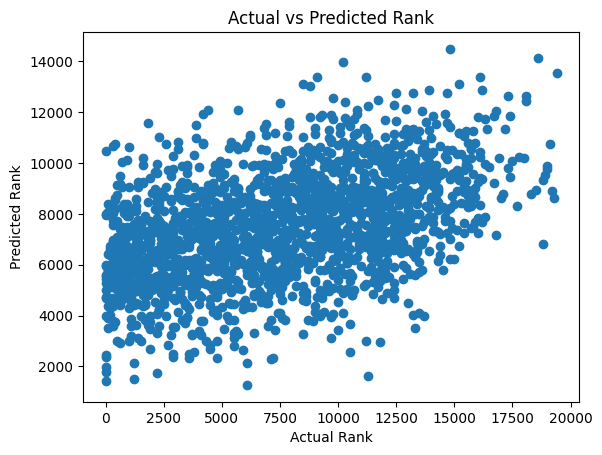

In [72]:
# check the model

# get r2 score
from sklearn.metrics import r2_score
# get predictions
# predictions = rank_model.predict(rank_model_data_read[rank_model_features])
predictions = standardized_predict(rank_model, rank_model_data_read[rank_model_features])
r2 = r2_score(rank_model_data_read['Rank'], predictions)
print('R2 Score: ', r2)

# plot the predictions
import matplotlib.pyplot as plt
plt.scatter(rank_model_data_read['Rank'], predictions)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Actual vs Predicted Rank')
plt.show()

In [73]:
rank_model_features

Index(['batting_order_P', 'batter_fp_mean_P',
       'batting_order_by_pitcher_handedness_P', 'est_slg_P', 'est_woba_P',
       'batter_fp_25_by_pitcher_handedness_P',
       'batter_fp_75_by_pitcher_handedness_P',
       'hr_friendly_launch_speed_freq_P', 'hr_friendly_launch_angle_freq_P',
       'WHIP_P', 'Stuff+_P', 'Location+_P', 'Pitching+_P',
       'hr_friendly_launch_speed_pitcher_P',
       'hr_friendly_launch_angle_pitcher_P',
       'pitcher_fp_75_by_batter_handedness_P', 'opp_team_fp_75_P',
       'batter_fp_25_by_batter_handedness_P',
       'batter_fp_75_by_batter_handedness_P', 'pitcher_avg_drafted_P',
       'batter_fp_pred_P', 'pitcher_fp_pred_P', 'teams_in_game_pk_P',
       'team_avg_drafted_pred_P', 'team_avg_drafted_P',
       'team_against_pitcher_avg_drafted_P',
       'team_against_pitcher_avg_drafted_pred_P',
       'pitcher_against_team_avg_drafted_P',
       'pitcher_against_team_avg_drafted_pred_P', 'team_batter_fp_pred_P',
       'team_batter_salary_P', 'ba

In [74]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
iterations = 500
lineups_to_build = 150
# def backtest_with_filter():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
bad_lineups = []
great_lineups = []
cashing_lineups = []
non_cashing_lineups = []
# create a table for earnings per day
earnings = pd.DataFrame(columns=['Date', 'Top Lineups Earnings', 'GeneratedAt', 'All Lineups Earnings'])
all_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if not (m == '06' and d == '02'):
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                # max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build 1500 lineups and predict rank based on model; get the 150 lineups with lowest predicted rank; otherwise same as above
                for i in tqdm(range(iterations)):
                    lineup = build_one_lineup(all_variables)                        # get only variables for players with names in lineup_players
                    #lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
                    lineup_names = lineup['Name'].to_list()
                    lineup_positions = lineup['position'].to_list()
                    # convert lineup to string formatted for get_lineup_summary
                    lineup_players = ''
                    for i in range(len(lineup_names)):
                        lineup_players += lineup_positions[i] + ',' + lineup_names[i].lower() + '/'

                    
                    # add a dummy column to lineup_vars to groupby
                    lineup_rank = 'dummy'
                    combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables.drop(columns=['ID']))
                    # positions = ['p ', 'c ', '1b ', '2b ', '3b ', 'ss ', 'of ']
                    # for position in positions:
                    #     lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
                    # lineup_players = lineup_players.replace(' /', '/')
                    # lineup_players = lineup_players.split('/')
                    
                    # if combined_vars is empty, skip to next iteration
                    if combined_vars.empty:
                        continue
                    
                    # get rank predictions
                    lineup_rank_prediction = standardized_predict(rank_model, combined_vars[rank_model_features]) #rank_model.predict(combined_vars[rank_model_features])
                    lineup_rank_prediction = lineup_rank_prediction[0]

                    # get actual fpts for lineup based on contest_player_results
                    lineup['fpts'] = lineup['Name'].map(contest_player_results)
                    lineup_fpts = lineup['fpts'].sum()

                    # get rank of lineup in leaderboard
                    lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)

                    # create a collection of lineups if they rank > 14000
                    if lineup_rank > 14000:
                        bad_lineups.append(lineup)

                    if lineup_rank < 100:
                        great_lineups.append(lineup)

                    if lineup_rank < 3500:
                        cashing_lineups.append(lineup)

                    if lineup_rank > 3500: 
                        non_cashing_lineups.append(lineup)

                    # get payoff based on rank
                    this_payoff = get_payoff(lineup_rank)

                    # add current results to arrays
                    all_sum_fpts.append(lineup['player_fp_pred'].sum())
                    all_lineup_ranks.append(lineup_rank)
                    all_lineup_payoffs.append(this_payoff)
                    #all_lineup_utilities.append(lineup['Utility'].sum())
                    all_lineup_rank_preds.append(lineup_rank_prediction)

                    # add to todays_lineups
                    todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])
                # get the 20 lineups with the lowest predicted rank
                todays_lineups = todays_lineups.sort_values(by='Rank_pred').head(lineups_to_build)

                payoff_total = todays_lineups['Payoff'].sum()


                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Top Lineups Earnings': [payoff_total], 'GeneratedAt': [timestamp], 'All Lineups Earnings': [payoff_total_all]})])
                if(payoff_total == lineups_to_build * (-15)):
                    print('Exiting loop. All entry fees lost on ', date, '.')
                    break

    #return all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups



Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_

100%|██████████| 500/500 [01:16<00:00,  6.50it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:18<00:00,  6.38it/s]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:16<00:00,  6.53it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, 

100%|██████████| 500/500 [01:19<00:00,  6.32it/s]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:08<00:00,  7.25it/s]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, 

100%|██████████| 500/500 [01:14<00:00,  6.70it/s]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:07<00:00,  7.42it/s]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:10<00:00,  7.11it/s]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:05<00:00,  7.69it/s]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:21<00:00,  6.15it/s]


Getting data for  06 12 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
Getting data for  06 13 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
Getting data for  06 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_

100%|██████████| 500/500 [01:13<00:00,  6.79it/s]


Getting data for  06 15 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:04<00:00,  7.77it/s]


Getting data for  06 16 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


Getting data for  06 17 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:10<00:00,  7.08it/s]


Getting data for  06 18 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Getting data for  06 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
Getting data for  06 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
Getting data for  06 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_

100%|██████████| 500/500 [01:07<00:00,  7.38it/s]


Getting data for  06 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:04<00:00,  7.78it/s]


Getting data for  07 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07142024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:27<00:00,  5.70it/s]


Getting data for  07 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07192024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:13<00:00,  6.81it/s]


Getting data for  07 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07202024.csv
Getting data for  07 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07212024.csv
Getting data for  07 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07222024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_

100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


Getting data for  07 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07232024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_sal

100%|██████████| 500/500 [01:15<00:00,  6.59it/s]


Getting data for  07 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07242024.csv
Getting data for  07 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07252024.csv
Getting data for  07 26 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07262024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_

100%|██████████| 500/500 [01:07<00:00,  7.42it/s]

Getting data for  07 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings07272024.csv


In [75]:
# check lowest 10 batter_drafted_delta players in all_variables
# all_variables['batter_drafted_delta'] = np.where(all_variables['position'] != 'P', all_variables['player_drafted_pred'] - all_variables['team_avg_drafted_pred'], 0)
# # map fpts to player names
# all_variables['fpts'] = all_variables['Name'].map(contest_player_results)
# all_variables[all_variables['position'] != 'P'].sort_values(by='fpts', ascending=False).head(20)
lineup

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,P,C,1B,2B,3B,SS,OF,build_pred,position_payoff_sum,likelihood,kelly,SF,NYY,BAL,ARI,BOS,KC,OAK,ATL,MIL,LAD,STL,LAA,HOU,WSH,COL,NYM,MIA,SD,CHC,SEA,is_stacked,is_selected_pitcher,end_of_lineup,var,fpts
70,george kirby,3,1B,R,R,7.272727,3.551724,0.450,0.326,0.75,8.00,0.209302,0.083721,0.98,108.0,106.0,107.0,0.139601,0.076923,23.0875,67.25,1.108696,8.673913,20.248205,23,0,6.211421,21.447450,3.760960,3.676278,1.444359,1.002323,24.151333,25.272924,41.290374,21900,2.798940,31.237487,6.632215,31.065131,0.971148,17.376438,andrew vaughn,george kirby,SP,George Kirby (35202548),35202548,P,9600.0,SEA@CWS 07/26/2024 08:10PM ET,SEA,18.66,george kirby,21.155598,31.065131,17.376438,CWS,5.898625,1,0,0,0,0,0,0,76.170028,479.617276,0.181340,-0.187585,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,var70,29.55
73,zac gallen,7,1B,R,L,8.538462,5.103448,0.391,0.299,0.00,7.00,0.203846,0.057692,1.25,100.0,99.0,100.0,0.160976,0.048780,22.2000,81.75,1.125000,9.390625,12.947500,23,0,4.836178,16.507049,5.262967,4.832403,1.831250,1.295562,12.570930,11.611512,47.791061,28900,1.157060,16.411366,7.421514,16.115765,1.776902,13.659843,rowdy tellez,zac gallen,SP,Zac Gallen (35202551),35202551,P,9100.0,PIT@ARI 07/26/2024 09:40PM ET,ARI,15.25,zac gallen,16.006503,16.115765,13.659843,PIT,5.973883,1,0,0,0,0,0,0,55.599720,479.617276,0.123936,-0.044372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,var73,18.10
44,patrick bailey,6,C,R,L,7.352941,4.800000,0.442,0.351,0.75,9.00,0.179310,0.089655,1.54,82.0,101.0,97.0,0.162304,0.052356,16.6750,123.50,0.714286,7.880952,4.745000,23,0,7.011609,8.136287,6.357611,6.123169,9.785556,9.445113,8.591530,7.212567,69.406942,29400,9.760649,4.050809,6.660629,4.631786,10.464209,8.708389,patrick bailey,kyle freeland,C,Patrick Bailey (35202714),35202714,C,3600.0,COL@SF 07/26/2024 10:15PM ET,SF,6.53,patrick bailey,7.011609,9.760649,6.660629,COL,9.120063,0,1,0,0,0,0,0,31.804214,302.874671,0.099360,0.001943,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,var44,7.00
49,david villar,4,1B,L,R,3.000000,6.000000,0.625,0.433,3.00,9.00,0.227273,0.045455,1.54,82.0,101.0,97.0,0.162304,0.052356,16.6750,123.50,0.714286,7.880952,4.745000,23,0,9.723826,9.823850,6.357611,6.123169,9.785556,9.445113,8.591530,7.212567,69.406942,29400,11.778284,5.047412,3.738414,4.631786,10.464209,8.708389,david villar,kyle freeland,1B,David Villar (35203125),35203125,1B,2000.0,COL@SF 07/26/2024 10:15PM ET,SF,6.33,david villar,9.723826,11.778284,3.738414,COL,9.120063,0,0,1,0,0,0,0,37.569422,289.628401,0.100056,-0.020094,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,var49,3.00
38,connor norby,8,2B,R,R,7.333333,8.666667,0.350,0.250,0.00,10.00,0.000000,0.300000,1.84,99.0,95.0,97.0,0.142857,0.061224,7.0500,91.50,0.900000,7.500000,0.744375,23,0,6.123053,6.539566,7.385814,6.661882,7.699375,7.966247,8.205323,9.037740,87.295742,39600,7.382150,2.036787,8.704114,0.297780,9.368898,2.676228,connor norby,adam mazur,2B,Connor Norby (35202993),352

In [76]:
earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,49765,11:31:50.249266,48345
0,05282024,1125,11:33:09.626533,4145
0,05292024,-590,11:34:27.359200,-2115
0,05312024,-510,11:35:47.653718,-1595
0,06032024,51250,11:37:03.826533,72735
0,06042024,-10,11:38:13.955765,105890
0,06052024,4400,11:39:23.160649,11265
0,06072024,-1525,11:40:38.748234,-5080
0,06082024,-1180,11:41:47.183245,-3885
0,06092024,530,11:42:58.514656,580


In [77]:
pct_earnings = earnings.copy()
pct_earnings['Top Lineups Earnings'] = pct_earnings['Top Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
pct_earnings['All Lineups Earnings'] = pct_earnings['All Lineups Earnings'].astype(float)/(iterations*15)*100
pct_earnings = pct_earnings.rename(columns={'Top Lineups Earnings': 'Top Lineups Earnings (%)', 'All Lineups Earnings': 'All Lineups Earnings (%)'})
print('Total top lineups earnings: ', pct_earnings['Top Lineups Earnings (%)'].sum(), 'Total all lineups earnings: ', pct_earnings['All Lineups Earnings (%)'].sum())
pct_earnings

Total top lineups earnings:  9288.0 Total all lineups earnings:  5630.666666666667


,Date,Top Lineups Earnings (%),GeneratedAt,All Lineups Earnings (%)
0,05272024,2211.777778,11:31:50.249266,644.600000
0,05282024,50.000000,11:33:09.626533,55.266667
0,05292024,-26.222222,11:34:27.359200,-28.200000
0,05312024,-22.666667,11:35:47.653718,-21.266667
0,06032024,2277.777778,11:37:03.826533,969.800000
0,06042024,-0.444444,11:38:13.955765,1411.866667
0,06052024,195.555556,11:39:23.160649,150.200000
0,06072024,-67.777778,11:40:38.748234,-67.733333
0,06082024,-52.444444,11:41:47.183245,-51.800000
0,06092024,23.555556,11:42:58.514656,7.733333


In [78]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


In [79]:
# Get a single lineup ranked as the best of num_lineups
# (use when entering single-bullet)
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# num_lineups = 100
# #optional = ''
# #all_variables = get_all_variables(year, month, day, optional=optional, df=df)
# # build num_lineups using build_one_lineup and get the best option
# def get_best_lineup(num_lineups, all_variables=all_variables, model=model):
#     best_lineup_rank = 100000
#     best_lineup = pd.DataFrame()
#     for i in range(num_lineups):
#         lineup = build_one_lineup(all_variables, all_variables)
#         # get only variables for players with names in lineup_players
#         lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

#         # add a dummy column to lineup_vars to groupby
#         lineup_vars['Rank'] = 'dummy'

#         lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#         lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#         lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
#         lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

#         # rename pitcher columns by suffixing with '_pitcher'
#         lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#         lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

#         # merge hitters and pitchers on Rank and Date
#         combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

#         # drop Rank
#         combined_vars = combined_vars.drop(columns='Rank')

#         # get rank predictions
#         lineup_rank_prediction = model.predict(combined_vars)
#         lineup_rank_prediction = lineup_rank_prediction[0]

#         if lineup_rank_prediction < best_lineup_rank:
#             best_lineup = lineup

#     return best_lineup

# top_lineup = get_best_lineup(num_lineups)

# # get top lineup
# top_lineup

(array([463., 408., 378., 343., 325., 325., 342., 305., 294., 323., 291.,
        266., 276., 264., 239., 226., 240., 248., 212., 220., 221., 232.,
        200., 231., 190., 193., 169., 199., 164., 197., 185., 159., 184.,
        175., 184., 155., 172., 159., 161., 123., 131., 143., 124., 154.,
        133., 154., 132., 103., 109.,  98., 108., 118., 104., 118.,  83.,
         78.,  63.,  66.,  39.,  56.,  37.,  32.,  15.,  25.,  37.,  23.,
          3.,   9.,   7.,   8.,   6.,   4.,   4.,   6.,   5.,   7.,   6.,
          5.,   3.,   3.]),
 array([1.0000000e+00, 2.4247500e+02, 4.8395000e+02, 7.2542500e+02,
        9.6690000e+02, 1.2083750e+03, 1.4498500e+03, 1.6913250e+03,
        1.9328000e+03, 2.1742750e+03, 2.4157500e+03, 2.6572250e+03,
        2.8987000e+03, 3.1401750e+03, 3.3816500e+03, 3.6231250e+03,
        3.8646000e+03, 4.1060750e+03, 4.3475500e+03, 4.5890250e+03,
        4.8305000e+03, 5.0719750e+03, 5.3134500e+03, 5.5549250e+03,
        5.7964000e+03, 6.0378750e+03, 6.279350

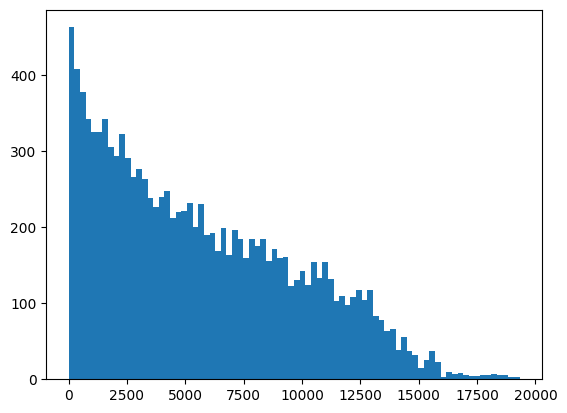

In [80]:
# histogram of all_lineups Ranks
plt.hist(all_lineups['Rank'], bins=80)

In [81]:
len(all_lineups)

12000

In [82]:
# how many in bad_lineups
len(bad_lineups)


343

In [83]:
len(great_lineups)

#great_lineups[2]

229

In [84]:
great_and_bad_lineups_hitters = pd.DataFrame()
great_and_bad_lineups_pitchers = pd.DataFrame()
great_and_bad_lineups = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'batter_payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(great_lineups)):
    # get each lineup individually
    this_lineup_avgs = great_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])

for i in range(len(bad_lineups)):
    # do the same but set great_lineup to 0
    this_lineup_avgs = bad_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 0
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)

    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()

    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])
    
    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={ 'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])


In [85]:
great_and_bad_lineups.head()

,player_drafted_pred,batter_payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup,player_drafted_pred_pitcher,batter_payoff_pred_pitcher,opp_mean_pred_pitcher,team_batter_fp_pred_pitcher,player_fp_pred_pitcher,WHIP_pitcher,est_woba_pitcher,est_slg_pitcher,hr_friendly_launch_speed_pitcher_pitcher,hr_friendly_launch_angle_pitcher_pitcher,batter_fp_pred_pitcher,pitcher_fp_pred_pitcher,team_batter_fp_pred_pitcher,team_batter_salary_pitcher,batter_drafted_pred_pitcher,pitcher_drafted_pred_pitcher,opp_pitcher_drafted_mean_pitcher,opp_batter_drafted_mean_pitcher,pitcher_payoff_pred_pitcher,Salary_pitcher,AvgPointsPerGame_pitcher
0,8.395078,9.553672,6.889419,73.664592,8.983565,1.754643,0.328520,0.419315,0.146764,0.103128,8.983565,6.926612,73.664592,36050.0,8.395078,0.727988,0.614966,7.861596,6.105531,4137.5,6.07000,1.0,17.316904,9.283015,6.182705,55.644349,16.988626,1.07,0.3415,0.4665,0.127238,0.065239,6.891978,15.775828,55.644349,32550.0,3.150607,16.661957,17.316904,4.330944,13.961003,8400.0,15.950
0,5.730392,8.508874,10.415901,70.084549,8.059737,1.471964,0.343375,0.444875,0.159231,0.083891,8.059737,10.557207,70.084549,38700.0,5.730392,7.467224,7.478158,5.601869,9.473223,4075.0,6.56750,1.0,19.288461,8.691027,6.382640,54.347767,17.508293,1.01,0.3175,0.4125,0.119541,0.068130,6.174204,17.765922,54.347767,34150.0,2.149636,19.427588,19.288461,2.450635,14.079600,8650.0,14.990
0,9.121355,8.904138,7.817916,71.643793,8.658345,1.716250,0.321625,0.409500,0.140094,0.099809,8.658345,8.013144,71.643793,34687.5,9.121355,1.088588,0.922449,8.852571,6.473677,3937.5,5.76250,1.0,25.735402,7.425526,6.347312,54.029818,16.934803,1.21,0.3070,0.4030,0.135941,0.062601,6.496278,18.190719,54.029818,28500.0,3.620252,26.413635,25.735402,1.639718,13.824769,9250.0,16.485
0,6.316484,7.811574,12.403985,62.209315,7.044401,1.318393,0.320875,0.399250,0.169282,0.067680,7.044401,13.200294,62.209315,38712.5,6.316484,13.546920,13.407213,5.272010,11.413537,3937.5,6.56500,1.0,25.735402,7.425526,6.347312,54.029818,16.934803,1.21,0.3070,0.4030,0.135941,0.062601,6.496278,18.190719,54.029818,28500.0,3.620252,26.413635,25.735402,1.639718,13.824769,9250.0,16.485
0,5.115241,8.394552,10.281780,71.782366,7.688215,1.486964,0.327500,0.418625,0.158390,0.086984,7.688215,10.730398,71.782366,39450.0,5.115241,7.227345,7.125730,5.138793,9.188253,3937.5,6.04375,1.0,25.735402,7.425526,6.347312,54.029818,16.934803,1.21,0.3070,0.4030,0.135941,0.062601,6.496278,18.190719,54.029818,28500.0,3.620252,26.413635,25.735402,1.639718,13.824769,9250.0,16.485


In [86]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 1]


,player_drafted_pred,batter_payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,8.395078,9.553672,6.889419,73.664592,8.983565,1.754643,0.328520,0.419315,0.146764,0.103128,8.983565,6.926612,73.664592,36050.0,8.395078,0.727988,0.614966,7.861596,6.105531,4137.5,6.07000,1.0
0,5.730392,8.508874,10.415901,70.084549,8.059737,1.471964,0.343375,0.444875,0.159231,0.083891,8.059737,10.557207,70.084549,38700.0,5.730392,7.467224,7.478158,5.601869,9.473223,4075.0,6.56750,1.0
0,9.121355,8.904138,7.817916,71.643793,8.658345,1.716250,0.321625,0.409500,0.140094,0.099809,8.658345,8.013144,71.643793,34687.5,9.121355,1.088588,0.922449,8.852571,6.473677,3937.5,5.76250,1.0
0,6.316484,7.811574,12.403985,62.209315,7.044401,1.318393,0.320875,0.399250,0.169282,0.067680,7.044401,13.200294,62.209315,38712.5,6.316484,13.546920,13.407213,5.272010,11.413537,3937.5,6.56500,1.0
0,5.115241,8.394552,10.281780,71.782366,7.688215,1.486964,0.327500,0.418625,0.158390,0.086984,7.688215,10.730398,71.782366,39450.0,5.115241,7.227345,7.125730,5.138793,9.188253,3937.5,6.04375,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,11.312642,8.481351,8.170880,77.018555,8.834207,1.439518,0.334625,0.447750,0.179192,0.089963,8.834207,8.542237,77.018555,40175.0,11.312642,5.496638,5.324347,10.333651,8.468929,4412.5,6.57750,1.0
0,6.158868,7.952025,12.176883,66.811197,8.544247,1.308115,0.334739,0.463081,0.159229,0.068681,8.544247,12.229593,66.811197,34625.0,6.158868,9.972487,9.962510,4.910395,10.302880,4187.5,7.02750,1.0
0,10.231358,8.777273,8.676903,74.850393,8.305071,1.420768,0.312151,0.401251,0.186469,0.085002,8.305071,9.273136,74.850393,40037.5,10.231358,3.555073,3.428781,9.585026,8.738484,4162.5,6.17875,1.0
0,11.567403,8.102987,7.220725,75.831488,8.635444,1.513509,0.329625,0.435250,0.191218,0.085299,8.635444,7.626576,75.831488,38850.0,11.567403,2.964703,2.761884,10.680614,7.850146,4250.0,6.44750,1.0


In [87]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 0]


,player_drafted_pred,batter_payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,7.300333,8.570247,14.097151,57.647438,7.437602,1.301250,0.328750,0.434875,0.195924,0.056202,7.437602,13.859298,57.647438,34025.0,7.300333,8.037621,8.166069,6.224005,12.059293,4125.0,7.26500,0.0
0,6.369930,8.666767,11.603489,67.216940,8.428996,1.443393,0.335117,0.436279,0.157480,0.083152,8.428996,11.192989,67.216940,33937.5,6.369930,4.167855,4.326375,5.406069,9.913520,4150.0,6.93625,0.0
0,8.634988,7.649478,14.859931,58.734012,8.027671,1.218750,0.345250,0.465125,0.155450,0.065111,8.027671,14.567515,58.734012,32112.5,8.634988,6.617200,6.775113,6.759043,12.300299,4300.0,7.43250,0.0
0,7.878122,7.908634,11.633129,64.409056,8.323129,1.354464,0.331367,0.452404,0.155601,0.076163,8.323129,12.108461,64.409056,36900.0,7.878122,3.479266,3.442073,6.269840,10.272428,4262.5,5.87750,0.0
0,7.031207,8.026492,14.163899,60.943606,7.355053,1.250000,0.323750,0.422250,0.157803,0.068702,7.355053,13.620330,60.943606,33262.5,7.031207,6.984491,7.278034,6.861666,11.911890,4250.0,6.90625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,7.289152,7.994103,11.700026,71.728807,7.731563,1.265394,0.324271,0.422542,0.109060,0.060602,7.731563,11.403644,71.728807,38087.5,7.289152,6.579021,6.775057,6.558255,9.240551,4237.5,7.30000,0.0
0,6.519999,8.178787,9.206177,77.032101,9.175254,1.455000,0.330390,0.445591,0.116059,0.072215,9.175254,8.445969,77.032101,32925.0,6.519999,16.503173,16.795387,6.092960,7.887261,4237.5,6.86125,0.0
0,8.222832,7.330496,11.223917,64.248680,8.097653,1.288750,0.322381,0.420033,0.118411,0.068287,8.097653,11.264097,64.248680,33462.5,8.222832,8.726900,8.805950,7.118931,9.569958,4062.5,6.73875,0.0
0,6.334772,8.301044,11.714850,63.153170,8.087162,1.297961,0.343824,0.446360,0.171766,0.075803,8.087162,11.414726,63.153170,33875.0,6.334772,6.673775,6.848799,5.894477,10.485511,4275.0,7.00625,0.0


In [88]:
def get_classifier_model(df, target, features):
    output = df[target]
    model_features = df[features]
    
    model = LogisticRegression()
    model.fit(model_features, output)
    return model


In [89]:
# commenting out 'great_lineup' prediction model since it does not seem to be working correctly

# create a model to predict if a lineup is a great lineup based on pregame factors
# # target is great_lineup, features are pregame factors
target = great_and_bad_lineups['great_lineup']
# # # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = great_and_bad_lineups.columns[great_and_bad_lineups.columns != 'great_lineup']
# features = great_and_bad_lineups[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup = LinearRegression()

# # fit the model
# model_is_great_lineup.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # importance of each feature
# importance = model_is_great_lineup.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# do the above for a decision tree classifier model

# # establish a model
# model_is_great_lineup = DecisionTreeClassifier()

# # fit the model
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
# model_is_great_lineup.fit(X_train, y_train)
# importance = model_is_great_lineup.feature_importances_

# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# select best features
great_lineup_features, great_lineup_data = select_best_features(great_and_bad_lineups.drop(columns='great_lineup'), target)

# classifier model
model_is_great_lineup = get_classifier_model(great_and_bad_lineups, 'great_lineup', great_lineup_features)

# save the model
filename = 'C:\\Users\\jorda\\Downloads\\great_lineup_model.sav'
pickle.dump(model_is_great_lineup, open(filename, 'wb'))

# check the model with confusion matrix
# get predictions
predictions = model_is_great_lineup.predict(great_and_bad_lineups[great_lineup_features])
# get confusion matrix
confusion_matrix_result = confusion_matrix(great_and_bad_lineups['great_lineup'], predictions)
print('Confusion Matrix: ', confusion_matrix_result)



Confusion Matrix:  [[272  71]
 [ 96 133]]


In [90]:


# build a classification model to predict if a lineup is a great lineup
# # target is great_lineup, features are pregame factors
# target = great_and_bad_lineups_pitchers['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = [ 'opp_mean_pred', 'player_fp_pred', 'WHIP', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'batter_payoff_pred', 'Salary']
# features = great_and_bad_lineups_pitchers[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup_pitchers = LogisticRegression()

# # fit the model
# model_is_great_lineup_pitchers.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup_pitchers.predict(X_test)

# confusion_matrix(y_test, y_pred)



In [91]:
lineups_hitters = pd.DataFrame()
lineups_pitchers = pd.DataFrame()
cashing_or_not = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'batter_payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = non_cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 0
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])



In [127]:
this_lineup['position'].to_list()

['P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']

In [130]:
cashing_or_not = pd.DataFrame()

for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup = cashing_lineups[i]
    # get a string of player names for get_lineup_summary
    lineup_players = ''
    for j in range(len(this_lineup)):
        lineup_players += this_lineup['position'].to_list()[j] + ',' + this_lineup['Name'].to_list()[j].lower() + '/'
    this_lineup = get_lineup_summary(lineup_players, 'dummy', 'date', this_lineup)
    this_lineup['cashing_lineup'] = 1
    cashing_or_not = pd.concat([cashing_or_not, this_lineup])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup = non_cashing_lineups[i]
    # get a string of player names for get_lineup_summary
    lineup_players = ''
    for j in range(len(this_lineup)):
        lineup_players += this_lineup['position'].to_list()[j] + ',' + this_lineup['Name'].to_list()[j].lower() + '/'
    this_lineup = get_lineup_summary(lineup_players, 'dummy', 'date', this_lineup)
    this_lineup['cashing_lineup'] = 0
    cashing_or_not = pd.concat([cashing_or_not, this_lineup])



,Rank,Date,batting_order_1B,batter_fp_mean_1B,batting_order_by_pitcher_handedness_1B,est_slg_1B,est_woba_1B,batter_fp_25_by_pitcher_handedness_1B,batter_fp_75_by_pitcher_handedness_1B,hr_friendly_launch_speed_freq_1B,hr_friendly_launch_angle_freq_1B,WHIP_1B,Stuff+_1B,Location+_1B,Pitching+_1B,hr_friendly_launch_speed_pitcher_1B,hr_friendly_launch_angle_pitcher_1B,pitcher_fp_75_by_batter_handedness_1B,opp_team_fp_75_1B,batter_fp_25_by_batter_handedness_1B,batter_fp_75_by_batter_handedness_1B,pitcher_avg_drafted_1B,teams_in_game_pk_1B,batter_fp_pred_1B,pitcher_fp_pred_1B,team_avg_drafted_pred_1B,team_avg_drafted_1B,team_against_pitcher_avg_drafted_1B,team_against_pitcher_avg_drafted_pred_1B,pitcher_against_team_avg_drafted_1B,pitcher_against_team_avg_drafted_pred_1B,team_batter_fp_pred_1B,team_batter_salary_1B,batter_drafted_pred_1B,pitcher_drafted_pred_1B,batter_payoff_pred_1B,opp_pitcher_drafted_mean_1B,opp_batter_drafted_mean_1B,pitcher_payoff_pred_1B,ID_1B,Salary_1B,AvgPointsPerGame_1B,player_fp_pred_1B,player_drafted_pred_1B,opp_mean_pred_1B,build_pred_1B,position_payoff_sum_1B,likelihood_1B,kelly_1B,fpts_1B,batting_order_2B,batter_fp_mean_2B,batting_order_by_pitcher_handedness_2B,est_slg_2B,est_woba_2B,batter_fp_25_by_pitcher_handedness_2B,batter_fp_75_by_pitcher_handedness_2B,hr_friendly_launch_speed_freq_2B,hr_friendly_launch_angle_freq_2B,WHIP_2B,Stuff+_2B,Location+_2B,Pitching+_2B,hr_friendly_launch_speed_pitcher_2B,hr_friendly_launch_angle_pitcher_2B,pitcher_fp_75_by_batter_handedness_2B,opp_team_fp_75_2B,batter_fp_25_by_batter_handedness_2B,batter_fp_75_by_batter_handedness_2B,pitcher_avg_drafted_2B,teams_in_game_pk_2B,batter_fp_pred_2B,pitcher_fp_pred_2B,team_avg_drafted_pred_2B,team_avg_drafted_2B,team_against_pitcher_avg_drafted_2B,team_against_pitcher_avg_drafted_pred_2B,pitcher_against_team_avg_drafted_2B,pitcher_against_team_avg_drafted_pred_2B,team_batter_fp_pred_2B,team_batter_salary_2B,batter_drafted_pred_2B,pitcher_drafted_pred_2B,batter_payoff_pred_2B,opp_pitcher_drafted_mean_2B,opp_batter_drafted_mean_2B,pitcher_payoff_pred_2B,ID_2B,Salary_2B,AvgPointsPerGame_2B,player_fp_pred_2B,player_drafted_pred_2B,opp_mean_pred_2B,build_pred_2B,position_payoff_sum_2B,likelihood_2B,kelly_2B,fpts_2B,batting_order_3B,batter_fp_mean_3B,batting_order_by_pitcher_handedness_3B,est_slg_3B,est_woba_3B,batter_fp_25_by_pitcher_handedness_3B,batter_fp_75_by_pitcher_handedness_3B,hr_friendly_launch_speed_freq_3B,hr_friendly_launch_angle_freq_3B,WHIP_3B,Stuff+_3B,Location+_3B,Pitching+_3B,hr_friendly_launch_speed_pitcher_3B,hr_friendly_launch_angle_pitcher_3B,pitcher_fp_75_by_batter_handedness_3B,opp_team_fp_75_3B,batter_fp_25_by_batter_handedness_3B,batter_fp_75_by_batter_handedness_3B,pitcher_avg_drafted_3B,teams_in_game_pk_3B,batter_fp_pred_3B,pitcher_fp_pred_3B,team_avg_drafted_pred_3B,team_avg_drafted_3B,team_against_pitcher_avg_drafted_3B,team_against_pitcher_avg_drafted_pred_3B,pitcher_against_team_avg_drafted_3B,pitcher_against_team_avg_drafted_pred_3B,team_batter_fp_pred_3B,team_batter_salary_3B,batter_drafted_pred_3B,pitcher_drafted_pred_3B,batter_payoff_pred_3B,opp_pitcher_drafted_mean_3B,opp_batter_drafted_mean_3B,pitcher_payoff_pred_3B,ID_3B,Salary_3B,AvgPointsPerGame_3B,player_fp_pred_3B,player_drafted_pred_3B,opp_mean_pred_3B,build_pred_3B,position_payoff_sum_3B,likelihood_3B,kelly_3B,fpts_3B,batting_order_C,batter_fp_mean_C,batting_order_by_pitcher_handedness_C,est_slg_C,est_woba_C,batter_fp_25_by_pitcher_handedness_C,batter_fp_75_by_pitcher_handedness_C,hr_friendly_launch_speed_freq_C,hr_friendly_launch_angle_freq_C,WHIP_C,Stuff+_C,Location+_C,Pitching+_C,hr_friendly_launch_speed_pitcher_C,hr_friendly_launch_angle_pitcher_C,pitcher_fp_75_by_batter_handedness_C,opp_team_fp_75_C,batter_fp_25_by_batter_handedness_C,batter_fp_75_by_batter_handedness_C,pitcher_avg_drafted_C,teams_in_game_pk_C,batter_fp_pred_C,pitcher_fp_pred_C,team_avg_drafted_pred_C,team_avg_drafted_C,team_against_pitcher_avg_drafted_C,team_against_pi

In [141]:
cashing_or_not.head()


,batting_order_P,batter_fp_mean_P,batting_order_by_pitcher_handedness_P,est_slg_P,est_woba_P,batter_fp_25_by_pitcher_handedness_P,batter_fp_75_by_pitcher_handedness_P,hr_friendly_launch_speed_freq_P,hr_friendly_launch_angle_freq_P,WHIP_P,Stuff+_P,Location+_P,Pitching+_P,hr_friendly_launch_speed_pitcher_P,hr_friendly_launch_angle_pitcher_P,pitcher_fp_75_by_batter_handedness_P,opp_team_fp_75_P,batter_fp_25_by_batter_handedness_P,batter_fp_75_by_batter_handedness_P,pitcher_avg_drafted_P,teams_in_game_pk_P,batter_fp_pred_P,pitcher_fp_pred_P,team_avg_drafted_pred_P,team_avg_drafted_P,team_against_pitcher_avg_drafted_P,team_against_pitcher_avg_drafted_pred_P,pitcher_against_team_avg_drafted_P,pitcher_against_team_avg_drafted_pred_P,team_batter_fp_pred_P,team_batter_salary_P,batter_drafted_pred_P,pitcher_drafted_pred_P,batter_payoff_pred_P,opp_pitcher_drafted_mean_P,opp_batter_drafted_mean_P,pitcher_payoff_pred_P,Salary_P,AvgPointsPerGame_P,player_fp_pred_P,player_drafted_pred_P,opp_mean_pred_P,build_pred_P,position_payoff_sum_P,likelihood_P,kelly_P,fpts_P,batting_order_hitters,batter_fp_mean_hitters,batting_order_by_pitcher_handedness_hitters,est_slg_hitters,est_woba_hitters,batter_fp_25_by_pitcher_handedness_hitters,batter_fp_75_by_pitcher_handedness_hitters,hr_friendly_launch_speed_freq_hitters,hr_friendly_launch_angle_freq_hitters,WHIP_hitters,Stuff+_hitters,Location+_hitters,Pitching+_hitters,hr_friendly_launch_speed_pitcher_hitters,hr_friendly_launch_angle_pitcher_hitters,pitcher_fp_75_by_batter_handedness_hitters,opp_team_fp_75_hitters,batter_fp_25_by_batter_handedness_hitters,batter_fp_75_by_batter_handedness_hitters,pitcher_avg_drafted_hitters,teams_in_game_pk_hitters,batter_fp_pred_hitters,pitcher_fp_pred_hitters,team_avg_drafted_pred_hitters,team_avg_drafted_hitters,team_against_pitcher_avg_drafted_hitters,team_against_pitcher_avg_drafted_pred_hitters,pitcher_against_team_avg_drafted_hitters,pitcher_against_team_avg_drafted_pred_hitters,team_batter_fp_pred_hitters,team_batter_salary_hitters,batter_drafted_pred_hitters,pitcher_drafted_pred_hitters,batter_payoff_pred_hitters,opp_pitcher_drafted_mean_hitters,opp_batter_drafted_mean_hitters,pitcher_payoff_pred_hitters,Salary_hitters,AvgPointsPerGame_hitters,player_fp_pred_hitters,player_drafted_pred_hitters,opp_mean_pred_hitters,build_pred_hitters,position_payoff_sum_hitters,likelihood_hitters,kelly_hitters,fpts_hitters,cashing_lineup
0,9,18,8,1,1,4,21,0,0,2,195,202,200,0,0,43,151,2,18,44,28,14,30,9,8,10,11,37,40,118,65900,10,52,17,52,7,27,15200,24,30,52,13,165,883,0,-0,54,41,69,35,4,3,16,80,2,1,11,700,812,771,1,1,119,454,10,65,41,112,62,97,48,46,44,53,70,70,526,296300,44,29,70,28,41,83,34400,56,62,44,100,284,3942,1,0,74,1
0,16,20,8,1,1,3,23,0,0,2,206,202,199,0,0,43,132,2,17,35,28,14,32,13,11,11,10,25,28,111,65100,6,33,19,35,9,28,16800,32,34,35,12,148,883,0,-0,46,38,70,40,4,3,18,78,1,1,11,710,808,767,1,1,109,526,8,66,76,112,63,93,50,47,45,52,69,75,565,314800,44,60,71,59,42,78,32800,52,63,44,91,280,3988,1,0,89,1
0,4,16,10,1,1,1,19,0,0,2,194,206,203,0,0,44,148,2,17,45,28,13,36,7,8,7,6,33,34,108,57000,7,53,15,51,3,28,18500,33,34,51,13,148,883,0,-0,59,36,68,38,4,3,16,72,2,1,10,802,817,788,1,1,140,511,8,64,68,112,60,118,52,50,47,58,78,83,505,298800,49,53,67,52,44,94,31300,50,60,49,116,273,3847,1,0,53,1
0,16,23,7,1,1,6,27,0,0,2,184,202,197,0,0,39,145,2,17,47,28,15,23,11,11,13,15,26,28,123,73700,9,42,20,44,11,26,14200,24,28,44,14,167,883,0,-0,45,36,75,34,4,3,15,86,2,1,10,780,817,795,1,1,123,582,7,65,44,112,62,115,55,51,55,64,88,92,497,303600,59,38,71,38,55,93,35800,57,62,59,115,280,3914,1,0,69,1
0,5,19,9,1,1,3,21,0,0,2,194,206,202,0,0,45,154,2,17,42,28,13,36,8,9,5,4,23,24,103,59800,5,41,18,40,3,28,18900,37,35,40,13,167,883,0,-0,36,37,70,42,4,3,12,74,2,1,10,733,818,784,1,1,138,540,8,68,88,112,57,109,50,46,43,50,80,81,526,300100,44,77,68,75,40,89,30700,51,57,44,106,325,3909,1,0,81,1


In [146]:
# classification model to predict if a lineup is a cashing lineup
# drop anything with _ID or that does not include _P or _hitters
cashing_or_not = cashing_or_not.loc[:,cashing_or_not.columns.str.contains('_P|_hitters|cashing_lineup') & ~cashing_or_not.columns.str.contains('ID') & ~cashing_or_not.columns.str.contains('fpts|likelihood|kelly')]
# target is cashing_lineup, features are pregame factors
target = cashing_or_not['cashing_lineup']
# feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = cashing_or_not.columns[cashing_or_not.columns != 'cashing_lineup']
# features = cashing_or_not[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_cashing_lineup = DecisionTreeClassifier()

# # fit the model
# model_is_cashing_lineup.fit(X_train, y_train)
# importance = model_is_cashing_lineup.feature_importances_
# names = model_is_cashing_lineup.feature_names_in_

# # summarize feature importance
# for i,v in enumerate(importance):
#     # print feature name
#     print('Feature: %s, Score: %.5f' % (names[i],v))
#     #print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# # predict the model
# y_pred = model_is_cashing_lineup.predict(X_test)
# confusion_matrix(y_test, y_pred)

# select best features
cashing_lineup_features, cashing_lineup_data = select_best_features(cashing_or_not.drop(columns='cashing_lineup'), target)

# classifier model
model_is_cashing_lineup = get_classifier_model(cashing_or_not, 'cashing_lineup', cashing_lineup_features)

# save the model
filename = 'C:\\Users\\jorda\\Downloads\\cashing_lineup_model.sav'
pickle.dump(model_is_cashing_lineup, open(filename, 'wb'))

# check the model with confusion matrix
# get predictions
predictions = model_is_cashing_lineup.predict(cashing_or_not[cashing_lineup_features])
# get confusion matrix
confusion_matrix_result = confusion_matrix(cashing_or_not['cashing_lineup'], predictions)
print('Confusion Matrix: ', confusion_matrix_result)


Confusion Matrix:  [[6615  663]
 [4042  679]]


In [147]:
cashing_lineup_features

Index(['batting_order_P', 'batter_fp_mean_P', 'est_slg_P', 'Pitching+_P',
       'hr_friendly_launch_angle_pitcher_P', 'batter_fp_pred_P',
       'team_against_pitcher_avg_drafted_P',
       'team_against_pitcher_avg_drafted_pred_P',
       'pitcher_against_team_avg_drafted_P',
       'pitcher_against_team_avg_drafted_pred_P', 'batter_drafted_pred_P',
       'pitcher_drafted_pred_P', 'opp_pitcher_drafted_mean_P',
       'opp_batter_drafted_mean_P', 'pitcher_payoff_pred_P', 'Salary_P',
       'AvgPointsPerGame_P', 'player_fp_pred_P', 'player_drafted_pred_P'],
      dtype='object')

In [148]:
# change to True to run the following code
if False:
    best_lineup = pd.DataFrame()
    best_lineup_rank = 100000

    for i in range(150):
        lineup = build_one_lineup(all_variables)
        # get only variables for players with names in lineup_players
        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

        # add a dummy column to lineup_vars to groupby
        lineup_vars['Rank'] = 'dummy'

        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

        # rename pitcher columns by suffixing with '_pitcher'
        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

        # merge hitters and pitchers on Rank and Date
        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

        # drop Rank
        combined_vars = combined_vars.drop(columns='Rank')
        
        # get rank predictions
        lineup_rank_prediction = model.predict(combined_vars)
        lineup_rank_prediction = lineup_rank_prediction[0]

        if lineup_rank_prediction < best_lineup_rank:
            best_lineup = lineup

    best_lineup

In [149]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
lineups_to_build = 100
# def backtest_with_models():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
keepers = []
# create a table for earnings per day
earnings = pd.DataFrame()
all_lineups = pd.DataFrame()

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if not (m == '06' and d == '02'):
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                # max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build lineups until lineups_to_build is reached
                pbar = tqdm(desc="while loop", total=lineups_to_build)
                i= 0
                while i < lineups_to_build:
                    lineup = build_one_lineup(all_variables, all_variables)                        # get only variables for players with names in lineup_players
                    #lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
                    lineup_names = lineup['Name'].to_list()
                    lineup_positions = lineup['position'].to_list()
                    # convert lineup to string formatted for get_lineup_summary
                    lineup_players = ''
                    for i in range(len(lineup_names)):
                        lineup_players += lineup_positions[i] + ',' + lineup_names[i].lower() + '/'

                    
                    # add a dummy column to lineup_vars to groupby
                    lineup_rank = 'dummy'
                    combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables.drop(columns=['ID']))
                    # positions = ['p ', 'c ', '1b ', '2b ', '3b ', 'ss ', 'of ']
                    # for position in positions:
                    #     lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
                    # lineup_players = lineup_players.replace(' /', '/')
                    # lineup_players = lineup_players.split('/')
                    
                    # if combined_vars is empty, skip to next iteration
                    if combined_vars.empty:
                        continue
                    
                    # get rank predictions
                    lineup_rank_prediction = standardized_predict(rank_model, combined_vars[rank_model_features]) #rank_model.predict(combined_vars[rank_model_features])
                    lineup_rank_prediction = lineup_rank_prediction[0]

                    # get actual fpts for lineup based on contest_player_results
                    lineup['fpts'] = lineup['Name'].map(contest_player_results)
                    lineup_fpts = lineup['fpts'].sum()

                    # get rank of lineup in leaderboard
                    lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                    cashing_lineup_prediction = model_is_cashing_lineup.predict(combined_vars[cashing_lineup_features])[0]

                    if great = 0 | cashing_lineup_prediction == 0:
                        continue
                    else:
                        # get actual fpts for lineup based on contest_player_results
                        lineup['fpts'] = lineup['Name'].map(contest_player_results)
                        lineup_fpts = lineup['fpts'].sum()

                        # get rank of lineup in leaderboard
                        lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                        keepers.append(lineup)

                        # get payoff based on rank
                        this_payoff = get_payoff(lineup_rank)

                        # add current results to arrays
                        all_sum_fpts.append(lineup['player_fp_pred'].sum())
                        all_lineup_ranks.append(lineup_rank)
                        all_lineup_payoffs.append(this_payoff)
                        #all_lineup_utilities.append(lineup['Utility'].sum())
                        all_lineup_rank_preds.append(lineup_rank_prediction)

                        # add to todays_lineups
                        todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                        i = len(todays_lineups)

                    pbar.update(1)
                pbar.close()
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])

                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'GeneratedAt': [timestamp], 'Filtered Lineups Earnings': [payoff_total_all]})])

# return all_lineups, earnings, keepers

# lineups, earnings, keepers = backtest_with_models()
earnings

Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_

while loop:   0%|          | 0/100 [00:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
len(keepers)

1900

In [ ]:
earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-120,12:27:14.650320,-1020
0,05282024,-150,12:28:30.032439,-1080
0,05292024,-240,12:29:38.961797,-970
0,05312024,-180,12:31:05.341271,-770
0,06032024,-150,12:32:17.819607,-1320
0,06042024,-270,12:33:42.725947,-1260
0,06052024,-270,12:34:58.741982,-1230
0,06072024,5,12:36:25.911433,-1075
0,06082024,-90,12:37:48.691983,-840
0,06092024,-270,12:39:12.971396,19295


In [150]:
# get all variables - refreshes default data before building

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


# pregame_data = get_pregame_info(df, year, month, day)
# all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

# all_variables = get_all_variables(year, month, day, optional='', df=df)

In [151]:
# get all variables with name contains Travis
all_variables[all_variables['Name_lower'].str.contains('travis')]

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred


In [152]:
# save models to disk
pickle.dump(model_is_great_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'wb'))
pickle.dump(model_is_cashing_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'wb'))

Mass Multi Entry Builder

In [160]:

# build a csv of dk lineups using get_best_lineup

# Number of lineups at the end
lineups_to_build = 40
iterations = lineups_to_build * 10
# Number of lineups to build, of which we select the best ranked lineups_to_build
# iterations = 200
# banned players by name
bans = ['CHC', 'CIN']
# Max percent of lineups that should include a single player
# max_own_goal = 0.7
# sets the standard deviation for the normal distribution used to select players
stdev = .28

# year, month day, optional and df are all defined above
optional = ''
# def build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df):
# get all variables - refreshes default data before building

all_variables = get_all_variables(year, month, day, optional, df=df)
all_variables['ID'] = all_variables['ID'].astype(str)
# bans = ['William Contreras', 'Connor Wong', 'Jose Trevino', 'TB', 'MIN']

# all_variables = all_variables[~all_variables['Name'].isin(bans)]
# all_variables = all_variables[~all_variables['team'].isin(bans)]

temp_col_names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 'Rank_pred', 'key']
column_names = ['P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
lineups = pd.DataFrame(columns=temp_col_names)
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
model_is_cashing_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'rb'))
model_is_great_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'rb'))

# # create a dictionary to store number of times each id is in a lineup
# id_counts = dict.fromkeys(all_variables['ID'], 0)
# # get max number of times a player can be in a lineup
# max_id_count = int(lineups_to_build * max_own_goal)

pbar = tqdm(total=iterations)
i = 0
counter = 0
while i < iterations:
    # add progress bar to loop with tqdm
    pbar.update(1)
    counter += 1
    lineup = build_one_lineup(all_variables, bans=bans, stdev=stdev)
    
    #lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
    lineup_names = lineup['Name'].to_list()
    lineup_positions = lineup['position'].to_list()
    # convert lineup to string formatted for get_lineup_summary
    lineup_players = ''
    for i in range(len(lineup_names)):
        lineup_players += lineup_positions[i] + ',' + lineup_names[i].lower() + '/'

    
    # add a dummy column to lineup_vars to groupby
    lineup_rank = 'dummy'
    combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables.drop(columns=['ID']))
    # positions = ['p ', 'c ', '1b ', '2b ', '3b ', 'ss ', 'of ']
    # for position in positions:
    #     lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
    # lineup_players = lineup_players.replace(' /', '/')
    # lineup_players = lineup_players.split('/')
    
    # if combined_vars is empty, skip to next iteration
    if combined_vars.empty:
        continue
    
    # get rank predictions
    lineup_rank_prediction = standardized_predict(rank_model, combined_vars[rank_model_features]) #rank_model.predict(combined_vars[rank_model_features])
    lineup_rank_prediction = lineup_rank_prediction[0]

    if True: #great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
    #     continue
    # else:
    # alphabetize IDs, concatenate as single string, add to lineup as key
        alphabetized_ids = lineup['ID'].astype(str).sort_values().tolist()
        alphabetized_ids = ''.join(alphabetized_ids)

        # add lineup prediction to lineup ids
        ids = lineup['ID'].tolist()

        ids.append(lineup_rank_prediction)
        ids.append(alphabetized_ids)
        
        lineups = pd.concat([lineups, pd.DataFrame([ids], columns=temp_col_names)])
        # drop duplicates
        lineups = lineups.drop_duplicates(subset='key') 
        i = len(lineups)

pbar.close()

# # get the best 'lineups_to_build' lineups based on rank prediction
lineups = lineups.sort_values(by='Rank_pred').head(lineups_to_build)

# get lineup ids
lineups = lineups.drop(columns=['Rank_pred', 'key'])

# rename columns
lineups.columns = column_names
# return lineups

# lineups = build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
# save lineups to csv
lineups.to_csv('C:\\Users\\jorda\\Downloads\\lineups.csv', index=False)



Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_75_by_batter_handedness, pitcher_avg_drafted, teams_in_game_pk, is_of, batter_fp_pred, pitcher_fp_pred, team_avg_drafted_pred, team_avg_drafted, team_against_pitcher_avg_drafted, team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted, pitcher_against_team_avg_drafted_pred, team_batter_fp_pred, team_batter_salary, batter_drafted_pred, pitcher_drafted_pred, batter_payoff_pred, opp_pitcher_drafted_mean, opp_batter_draf

401it [00:52,  7.69it/s]                         


In [161]:
lineups

,P,P,C,1B,2B,3B,SS,OF,OF,OF
0,35237433,35237435,35237467,35237571,35237493,35237489,35237498,35237568,35237643,35237558
0,35237438,35237435,35237610,35237470,35237485,35237461,35237458,35237730,35237487,35237622
0,35237432,35237438,35237490,35237632,35237583,35237461,35237485,35237519,35237605,35237541
0,35237434,35237440,35237606,35237576,35237572,35237489,35237498,35237466,35237468,35237529
0,35237433,35237438,35237490,35237483,35237485,35237489,35237541,35237564,35237582,35237730
0,35237432,35237434,35237606,35237511,35237485,35237461,35237620,35237564,35237590,35237605
0,35237432,35237435,35237470,35237483,35237524,35237551,35237498,35237617,35237568,35237627
0,35237438,35237434,35237606,35237576,35237493,35237551,35237457,35237466,35237519,35237590
0,35237432,35237433,35237574,35237527,35237583,35237559,35237498,35237617,35237480,35237605
0,35237432,35237438,35237490,35237632,35237583,35237461,35237458,35237564,35237605,35237541


In [162]:

# print('Great lineup prediction: ', great_lineup_prediction, '\nCashing lineup prediction: ', cashing_lineup_prediction, '\nLineups for export: ', len(lineups), '\nLineups built: ', counter)


In [163]:
for i in range(len(lineups)):
    c_id = lineups.iloc[i][2]
    lineup_catcher = all_variables[all_variables['ID'] == c_id]
    # c_name = lineup_catcher['Name'].values[0]
    # print(i, c_id, c_name)
    print(lineup_catcher['Name'])


136    william contreras
Name: Name, dtype: object
37    freddy fermin
Name: Name, dtype: object
16    cal raleigh
Name: Name, dtype: object
122    sean murphy
Name: Name, dtype: object
16    cal raleigh
Name: Name, dtype: object
122    sean murphy
Name: Name, dtype: object
121    salvador perez
Name: Name, dtype: object
122    sean murphy
Name: Name, dtype: object
38    gabriel moreno
Name: Name, dtype: object
16    cal raleigh
Name: Name, dtype: object
37    freddy fermin
Name: Name, dtype: object
38    gabriel moreno
Name: Name, dtype: object
121    salvador perez
Name: Name, dtype: object
122    sean murphy
Name: Name, dtype: object
37    freddy fermin
Name: Name, dtype: object
73    keibert ruiz
Name: Name, dtype: object
122    sean murphy
Name: Name, dtype: object
38    gabriel moreno
Name: Name, dtype: object
122    sean murphy
Name: Name, dtype: object
37    freddy fermin
Name: Name, dtype: object
73    keibert ruiz
Name: Name, dtype: object
121    salvador perez
Name: Name, dt

In [164]:
def write_to_entries():
    # import from DKEntriesMLB.csv
    # use columns  0 - 16
    entries = pd.read_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', sep=",", header=0, names=range(14), usecols=range(14))
    # change column names to original
    entries = entries.drop(columns=range(4, 14))
   
    # replace columns 4-13 with IDs from 'C:\\Users\\jorda\\Downloads\\lineups.csv'
    new_lineups = pd.read_csv('C:\\Users\\jorda\\Downloads\\lineups.csv')
    # make new_lineups all strings
    new_lineups = new_lineups.astype(str)
    entries = entries.astype(str)
    entries = pd.concat([entries, new_lineups], axis=1)
    # remove NaNs
    entries.columns = ['Entry ID', 'Contest Name', 'Contest ID', 'Entry Fee', 'P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    entries = entries.dropna()
     # remove decimals from first column if there is a decimal
    entries.replace('\.0', '', regex=True, inplace=True)

    # remove scientific notation
    pd.options.display.float_format = '{:.0f}'.format
    # write to csv, do not include index
    entries.to_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', index=False)
    return entries
entries = write_to_entries()

In [165]:
def check_ownership(lineups, top_own = 20):
    num_built = lineups.shape[0]
    # check number of times each player is in lineups and sort by most to least
    ownership = lineups.stack().value_counts().reset_index()
    ownership = ownership.rename(columns={'index': 'ID', 0: 'count'})
    ownership = ownership.sort_values(by='count', ascending=False)
    ownership = pd.merge(ownership, all_variables[['ID', 'Name', 'team', 'position']], on='ID')
    # calculate percentage of lineups each player is in, rounded to 2 decimal places
    ownership['percentage'] = (ownership['count'] / num_built) * 100
    print(ownership.head(top_own))

check_ownership(lineups, top_own=40)


          ID  count                Name team position  percentage
0   35237438     22          alec marsh   KC        P          55
1   35237432     21         paul skenes  PIT        P          52
2   35237498     19        willy adames  MIL       SS          48
3   35237617     12         alek thomas  ARI       OF          30
4   35237568     12     jackson chourio  MIL       OF          30
5   35237433     11       logan gilbert  SEA        P          28
6   35237606     11         sean murphy  ATL        C          28
7   35237489     10        mark vientos  NYM       3B          25
8   35237576      9          juan yepez  WSH       1B          22
9   35237434      9      nathan eovaldi  TEX        P          22
10  35237583      9       jorge polanco  SEA       2B          22
11  35237435      9        nick pivetta  BOS        P          22
12  35237627      9    garrett mitchell  MIL       OF          22
13  35237572      8         jeff mcneil  NYM    2B/OF          20
14  352375